In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

from functools import partial
from itertools import chain
from tqdm import tqdm
from collections import defaultdict

from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve

In [2]:
BASE_DATA_DIR = '/home/mikhail/bioinformatics/data/fragment_data'

Напишем общие функции для запуска RandomForest.

In [3]:
def run_random_forest(features, target, folds):
    pred_proba = np.zeros_like(target, dtype=np.float32)
    feature_importances = []

    for train_index, test_index in tqdm(folds):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = target[train_index], target[test_index]

        model = RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=8)
        model.fit(X_train, y_train)

        pred_proba[test_index] = model.predict_proba(X_test)[:, 1]
        feature_importances.append(model.feature_importances_)
    
    return pred_proba, np.mean(feature_importances, axis=0)


def draw_results(target, pred_proba):
    plt.figure(figsize=(20, 10))

    precision, recall, thresholds = precision_recall_curve(target, pred_proba)
    plt.plot(precision, recall, c='r')
    
    xs = np.arange(0, 1.01, 0.1)
    plt.scatter(xs, xs)
    
    plt.figure(figsize=(20, 10))

    plt.hist(pred_proba[target], color='r', alpha=0.5, bins=100, density=True);
    plt.hist(pred_proba[~target], color='b', alpha=0.5, bins=100, density=True);
    
    plt.show()

In [4]:
def group_folds(features, target, group_labels, n_splits=5):
    group_kfold = GroupKFold(n_splits=n_splits)
    
    return group_kfold.split(features, target, group_labels)
    

def stratified_folds(features, target, n_splits=5):
    stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    
    return stratified_kfold.split(features, target)

In [5]:
def load_dataset(data_dir):
    features = np.load(os.path.join(data_dir, 'features.npy'))
    target = np.load(os.path.join(data_dir, 'target.npy'))
    pdb_ids = np.load(os.path.join(data_dir, 'pdb_ids.npy'))
    chain_ids = np.load(os.path.join(data_dir, 'chain_ids.npy'))
    
    with open(os.path.join(data_dir, 'description.pickle'), 'rb') as infile:
        feature_description = pickle.load(infile)
    
    return features, target, pdb_ids, chain_ids, feature_description

In [6]:
datasets = {}

for folder in os.listdir(BASE_DATA_DIR):
    data_dir = os.path.join(BASE_DATA_DIR, folder)
    datasets[folder] = load_dataset(data_dir)

In [7]:
class Experiment:
    def __init__(self, dataset, dataset_description):
        self.features, self.target, self.pdb_ids, self.chain_ids, self.feature_description = dataset
        self.experiment_description = [dataset_description]
        self.chain_labels = np.array(['{}_{}'.format(pdb_id, chain_id) 
                                      for pdb_id, chain_id in zip(self.pdb_ids, self.chain_ids)])
    
    def make_experiment(self):
        raise NotImplementedError
    
    def run(self):
        features, target, folds = self.make_experiment()
        
        description = 'Experiment {}'.format('//'.join(self.experiment_description))
        print(description)
        print('target.mean={}'.format(target.mean()))
        
        pred_proba, feature_importances = run_random_forest(features, target, folds)

        draw_results(target, pred_proba)

        return target, pred_proba, description, feature_importances

    
    
class SmallChainsExperiment(Experiment):
    def make_experiment(self):
        keys = ['4y4o', '6qzp']
        
        self.experiment_description.append('pdb_ids={} excluded'.format(keys))
        
        mask = ~np.isin(self.pdb_ids, keys)
        
        features = self.features[mask]
        target = self.target[mask]
        group_labels = self.chain_labels[mask]
        folds = group_folds(features, target, group_labels)
        
        return features, target, folds


class StratifiedSmallChainsExperiment(Experiment):
    def make_experiment(self):
        keys = ['4y4o', '6qzp']
        
        self.experiment_description.append('stratified pdb_ids={} excluded'.format(keys))
        
        mask = ~np.isin(self.pdb_ids, keys)
        
        features = self.features[mask]
        target = self.target[mask]
        folds = stratified_folds(features, target)
        
        return features, target, folds


class AllDataStratifiedExperiment(Experiment):
    def make_experiment(self):
        self.experiment_description.append('all data stratified')
        
        folds = stratified_folds(self.features, self.target)
        
        return self.features, self.target, folds


class ChainPairExperiment(Experiment):
    def __init__(self, dataset, dataset_description, chain_pair):
        super(ChainPairExperiment, self).__init__(dataset, dataset_description)
        
        self.chain_pair = chain_pair
    
    def make_experiment(self):
        self.experiment_description.append('chain pair experiment for chains {}, {}'.format(*self.chain_pair))
        
        mask = np.isin(self.chain_labels, self.chain_pair)
        features = self.features[mask]
        target = self.target[mask]
        chain_labels = self.chain_labels[mask]
        
        indices = [chain_labels == ch for ch in self.chain_pair]
        folds = [[indices[0], indices[1]], [indices[1], indices[0]]]
        
        return features, target, folds


class LongChainExperiment(Experiment):
    def __init__(self, dataset, dataset_description, chain_label):
        super(LongChainExperiment, self).__init__(dataset, dataset_description)
        
        self.chain_label = chain_label
    
    def make_experiment(self):
        self.experiment_description.append('chain experiment for chain {}'.format(self.chain_label))
        
        mask = self.chain_labels == self.chain_label
        features = self.features[mask]
        target = self.target[mask]
        folds = stratified_folds(features, target)
        
        return features, target, folds


class CrossShortLongChainExperiment(Experiment):
    def make_experiment(self):
        self.experiment_description.append('cross chain short -> long')
        
        mask = np.isin(self.pdb_ids, ['4y4o', '6qzp'])
        
        folds = [[~mask, mask]]
        
        return self.features, self.target, folds

    
class CrossLongShortChainExperiment(Experiment):
    def make_experiment(self):
        self.experiment_description.append('cross chain long -> short')
        
        mask = np.isin(self.pdb_ids, ['4y4o', '6qzp'])
        
        folds = [[mask, ~mask]]
        
        return self.features, self.target, folds

Теперь будем запускать RandomForest. Без distance фичей.

1) Будем запускать для разных таргетов: граница по distance 8 и 20  
2) Будем запускать для всех 4-х датасетов  
3) Будем запускать для 9 экспериментов.  

Эксперименты следующие:  
1) Все структуры кроме 6qzp, 4y4o с GroupKFold  
2) Все структуры кроме 6qzp, 4y4o со StratifiedKFold  
3) Все структуры. Тут кросс валидацию придется сделать просто stratified -- т.е positive rate в каждом фолде будет один и тот же, но при этом в один фолд могут попадать пары из разных цепочек. Это все потому что если делать GroupKFold, то 4 больших цепочки все портят.  
4) По 4y4o_1a предсказываем 6qzp_S2 и наоборот  
5) По 4y4o_2A предсказываем 6qzp_L5 и наоборот  
6) Предсказываем 4y4o_1a по самой себе, StratifiedKFold  
7) Предсказываем 4y4o_2A по самой себе, StratifiedKFold  
8) Предсказываем 6qzp_S2 по самой себе, StratifiedKFold  
9) Предсказываем 6qzp_L5 по самой себе, StratifiedKFold  
10) Предсказываем короткие цепочки по длинным  
11) Предсказываем длинные цепочки по коротким

Эксперименты 4-5 нужны для того, чтобы понять степень схожести данных пар цепочек. 6-9, чтобы сравнить с результатами 4-5 и сделать вывод о том, насколько часто мотивы внутри и между цепочек повторяются. Эксперимент 3 непонятно зачем нужен. 

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow_wo_distance//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.1683381088825215


5it [00:02,  2.06it/s]


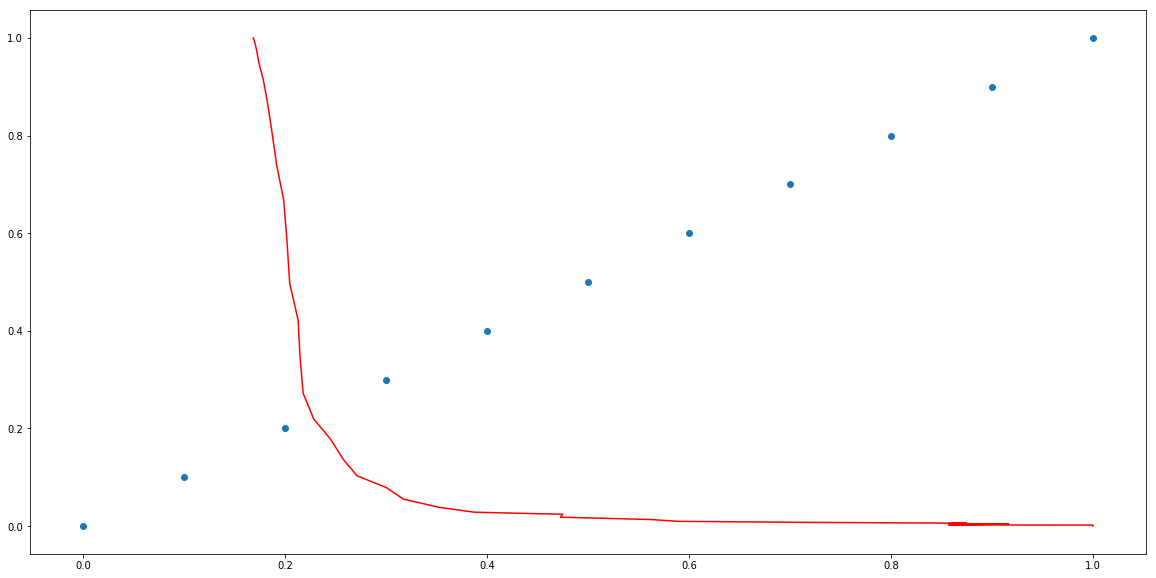

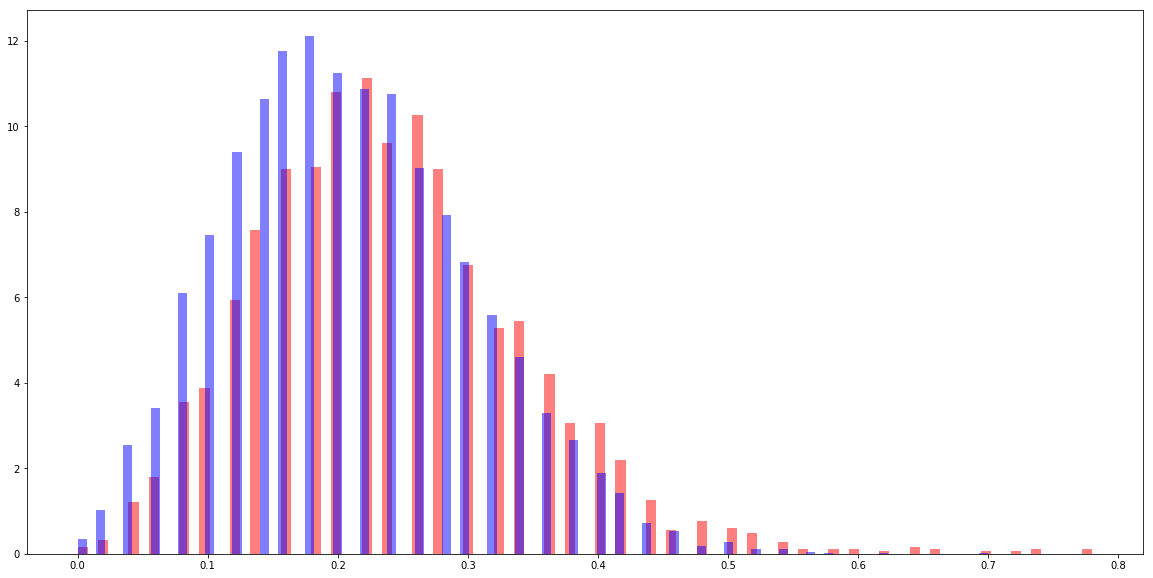

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow_wo_distance//all data stratified
target.mean=0.015558644194568837


5it [02:42, 32.49s/it]


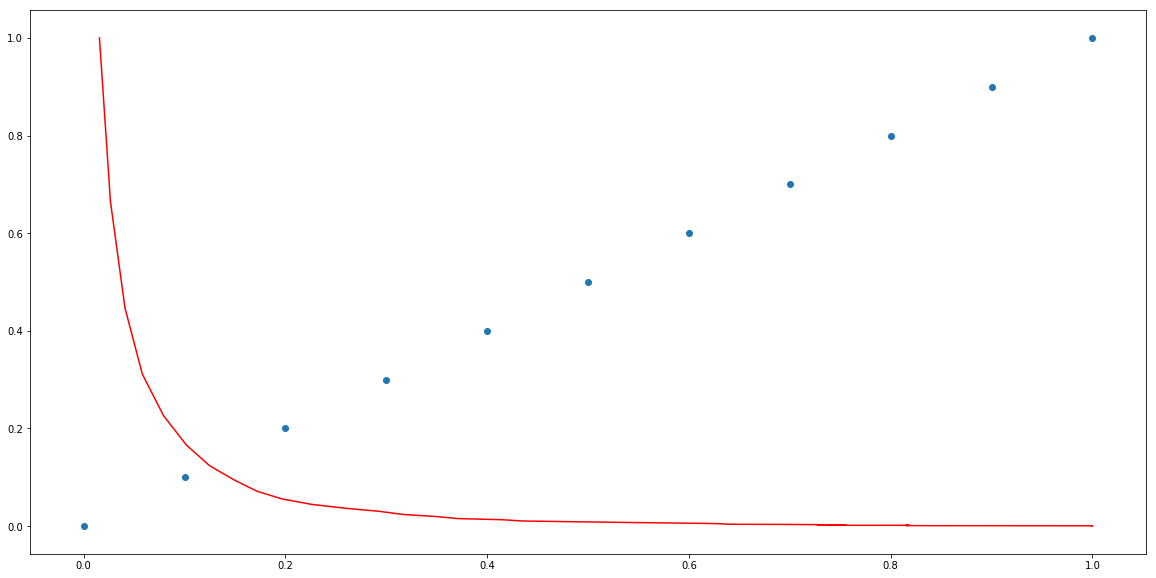

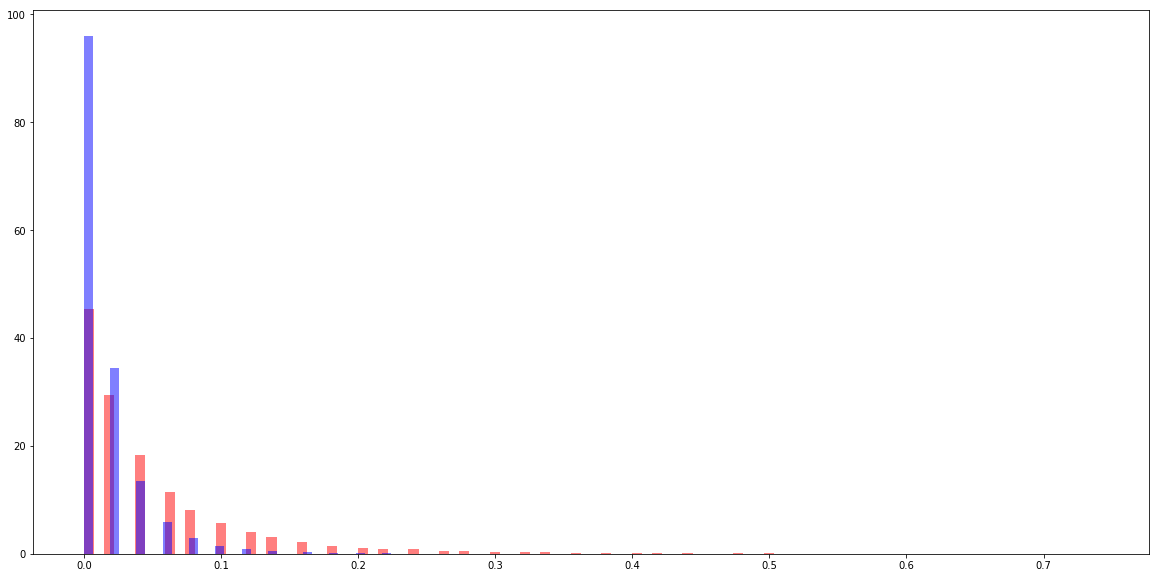

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow_wo_distance//stratified pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.1683381088825215


5it [00:02,  2.11it/s]


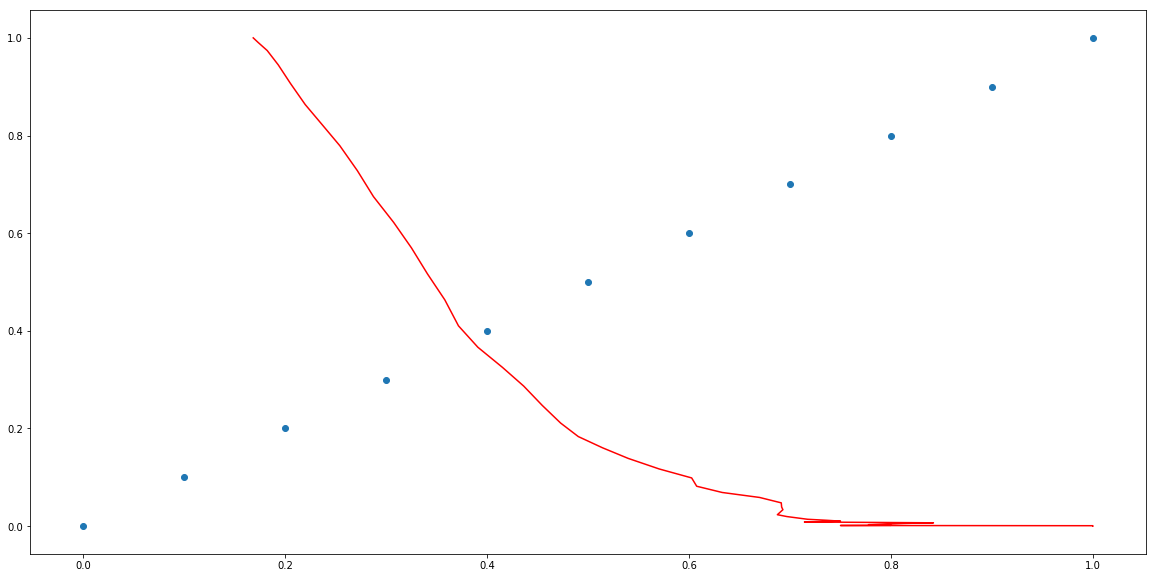

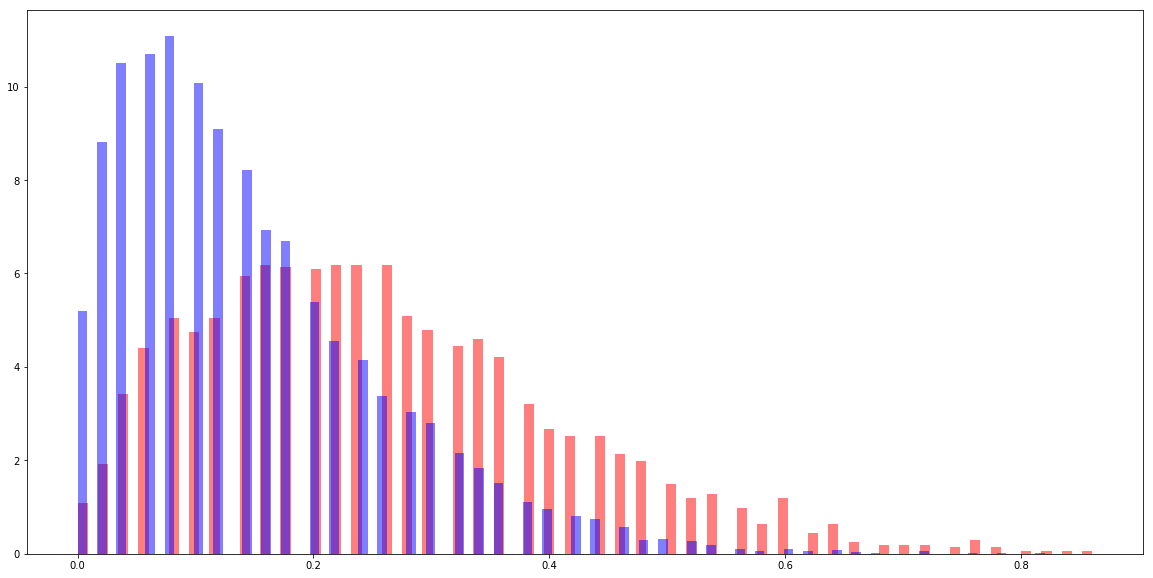

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow_wo_distance//cross chain short -> long
target.mean=0.015558644194568837


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


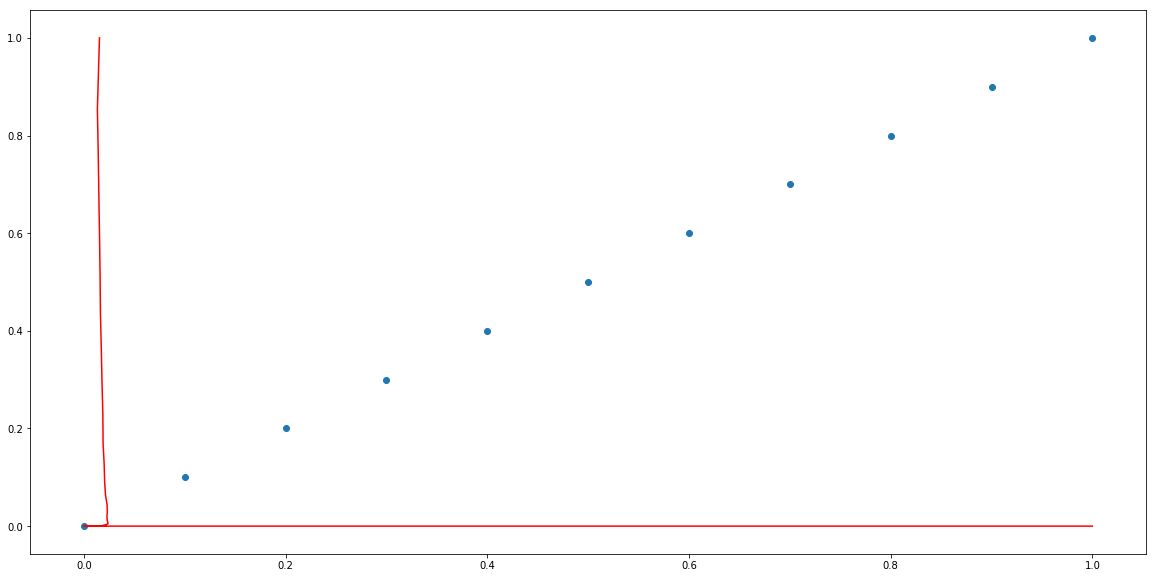

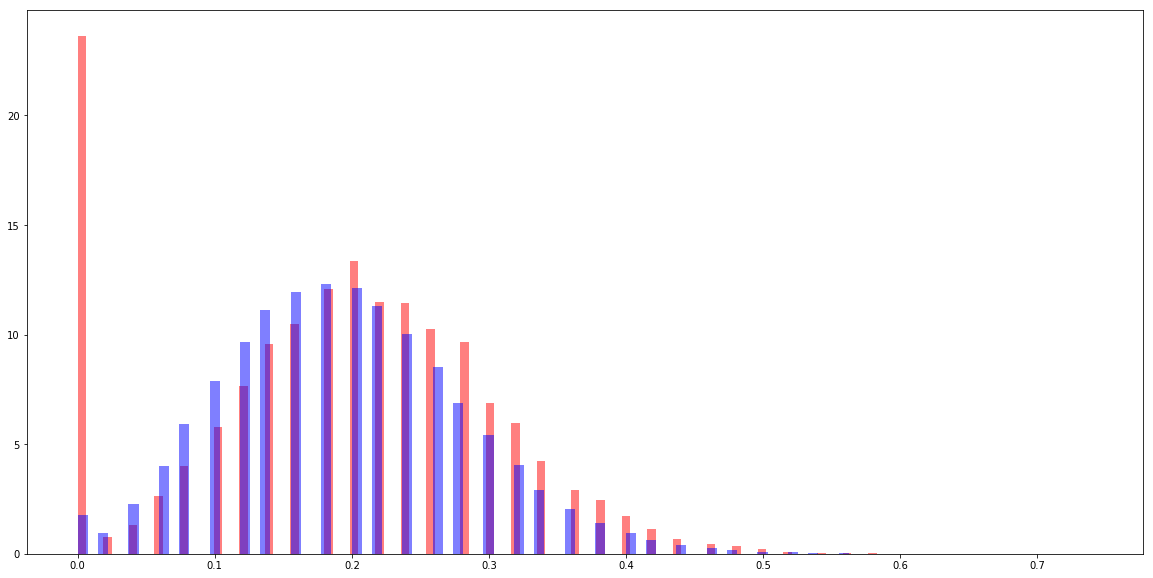

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow_wo_distance//cross chain long -> short
target.mean=0.015558644194568837


100%|██████████| 1/1 [00:35<00:00, 35.88s/it]


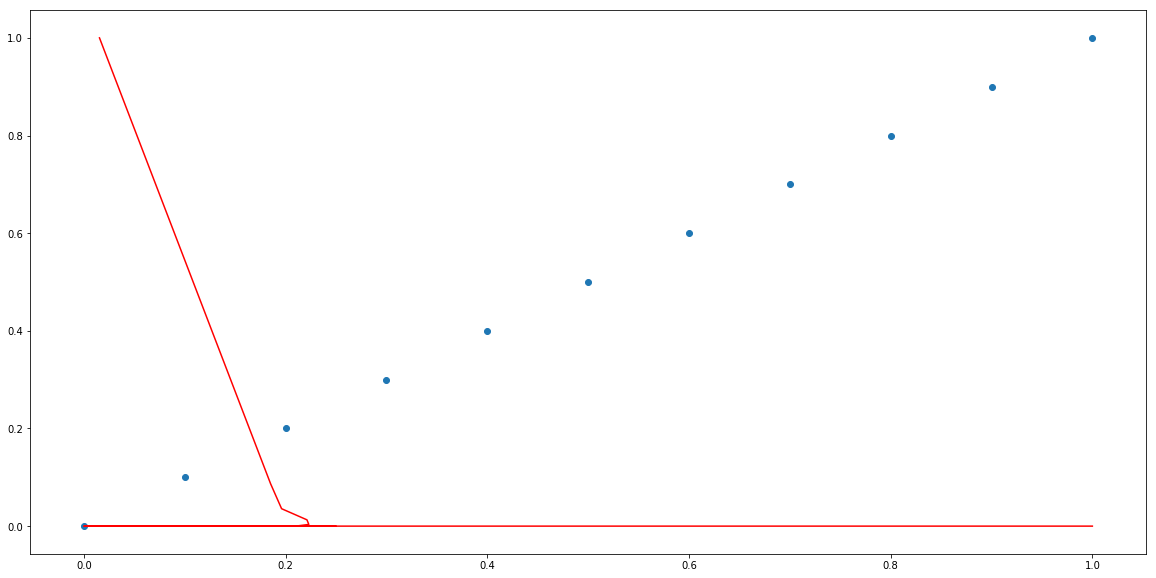

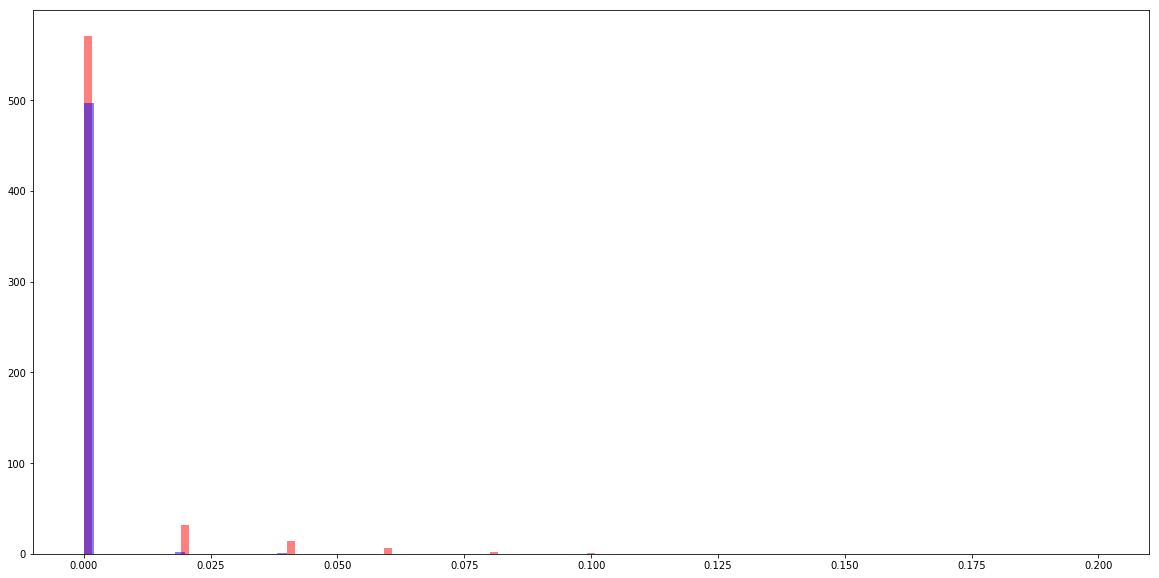

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow_wo_distance//chain pair experiment for chains 4y4o_1a, 6qzp_S2
target.mean=0.01991013071895425


100%|██████████| 2/2 [00:05<00:00,  3.00s/it]


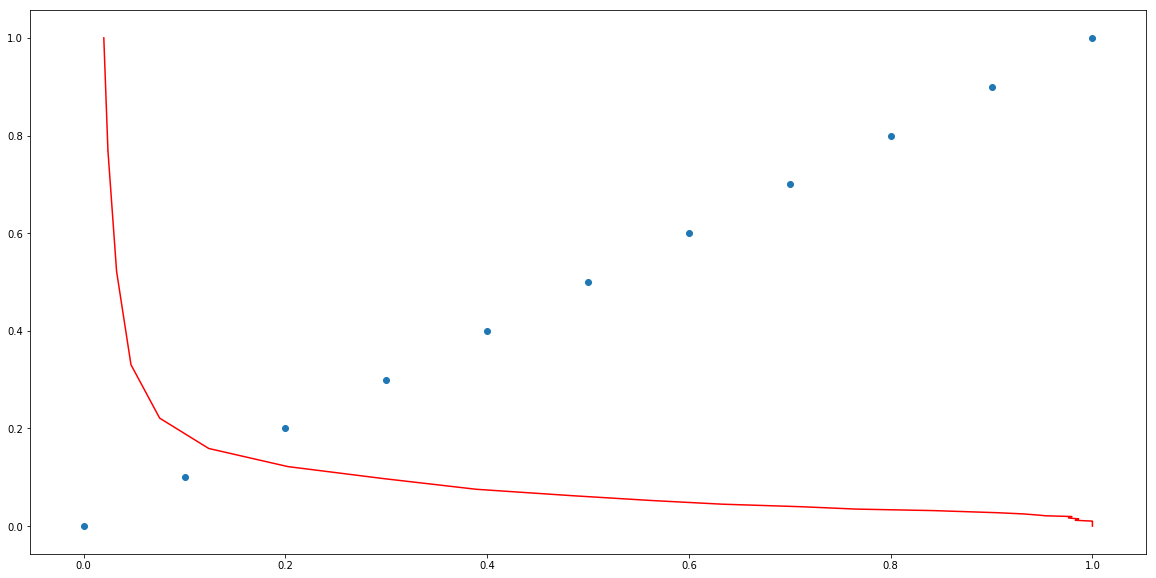

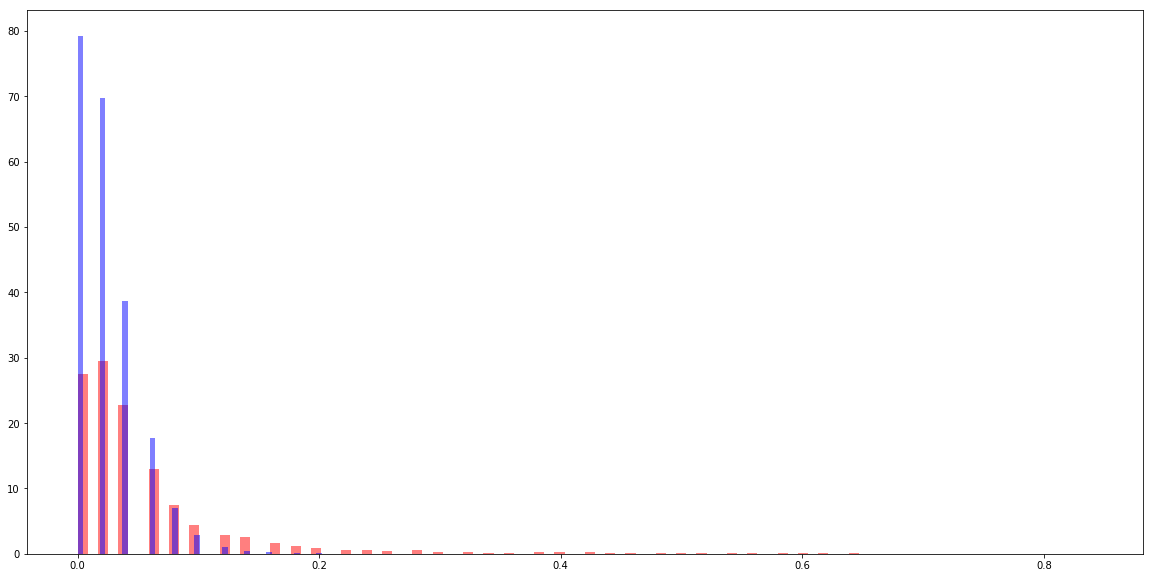

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow_wo_distance//chain pair experiment for chains 4y4o_2A, 6qzp_L5
target.mean=0.011332005906534747


100%|██████████| 2/2 [00:21<00:00, 10.68s/it]


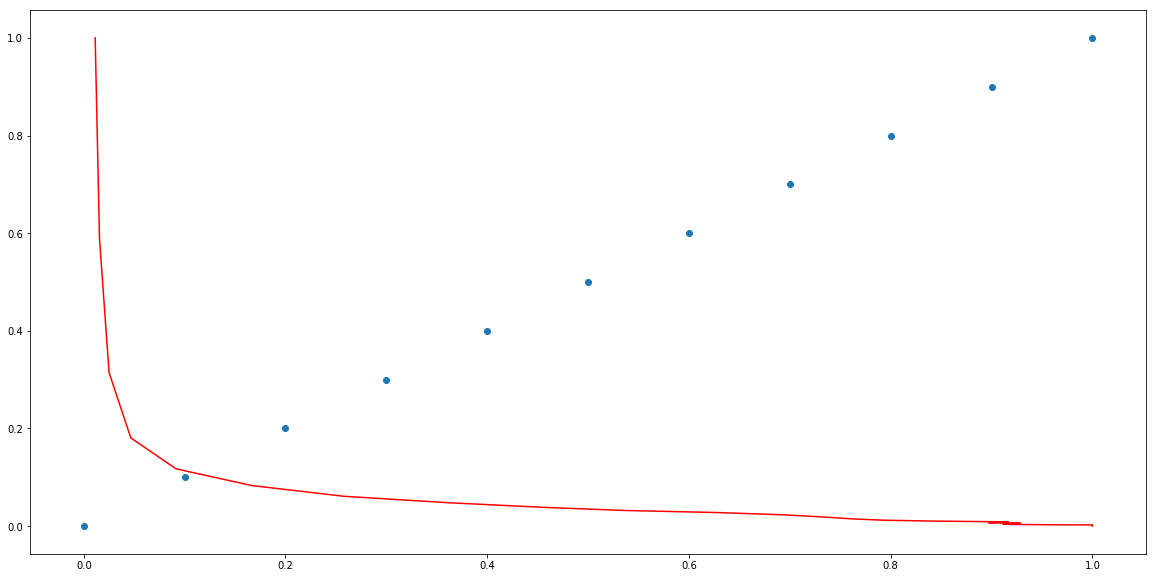

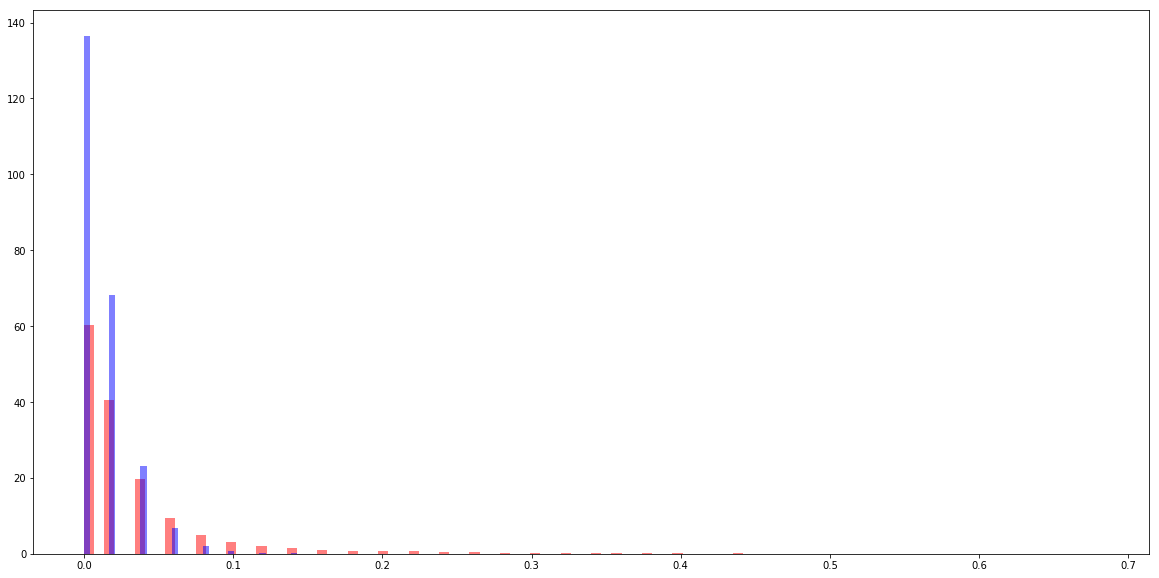

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow_wo_distance//chain experiment for chain 4y4o_1a
target.mean=0.022257092870154933


5it [00:08,  1.77s/it]


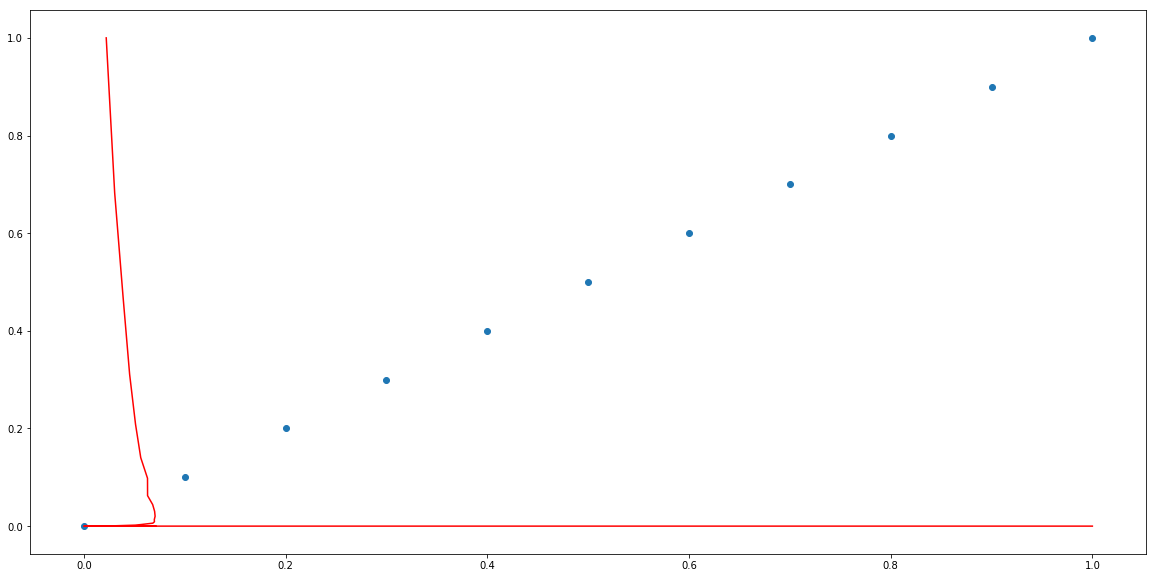

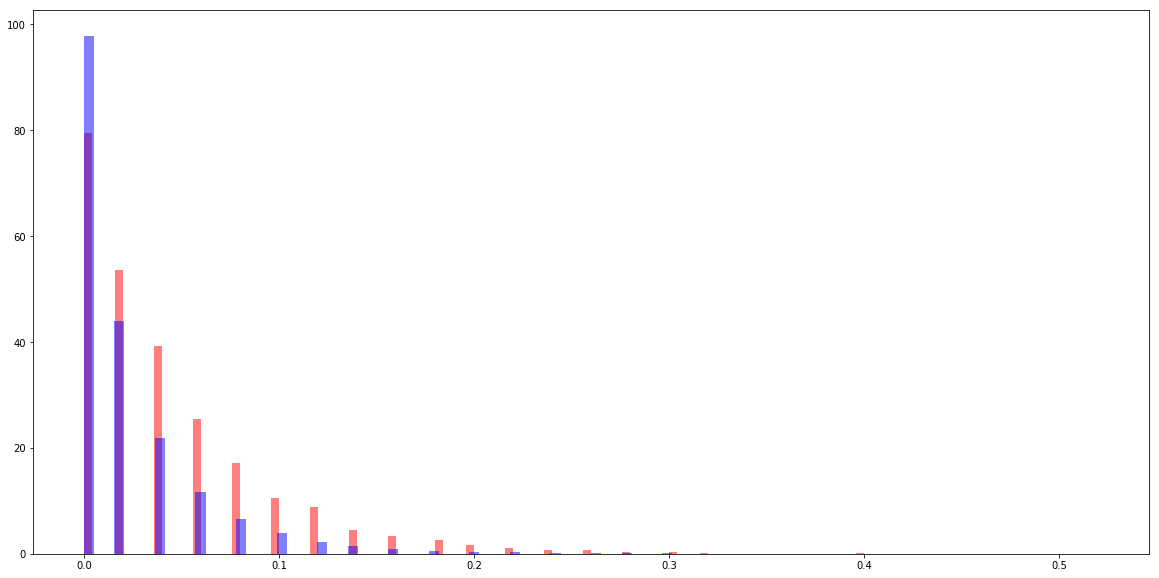

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow_wo_distance//chain experiment for chain 6qzp_S2
target.mean=0.017966754782920383


5it [00:11,  2.40s/it]


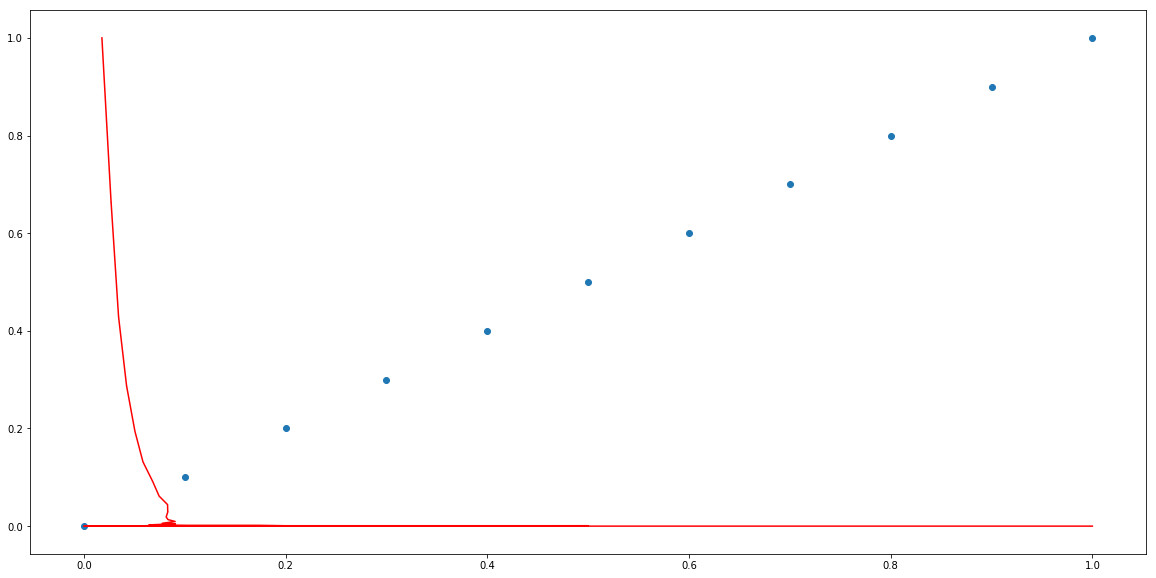

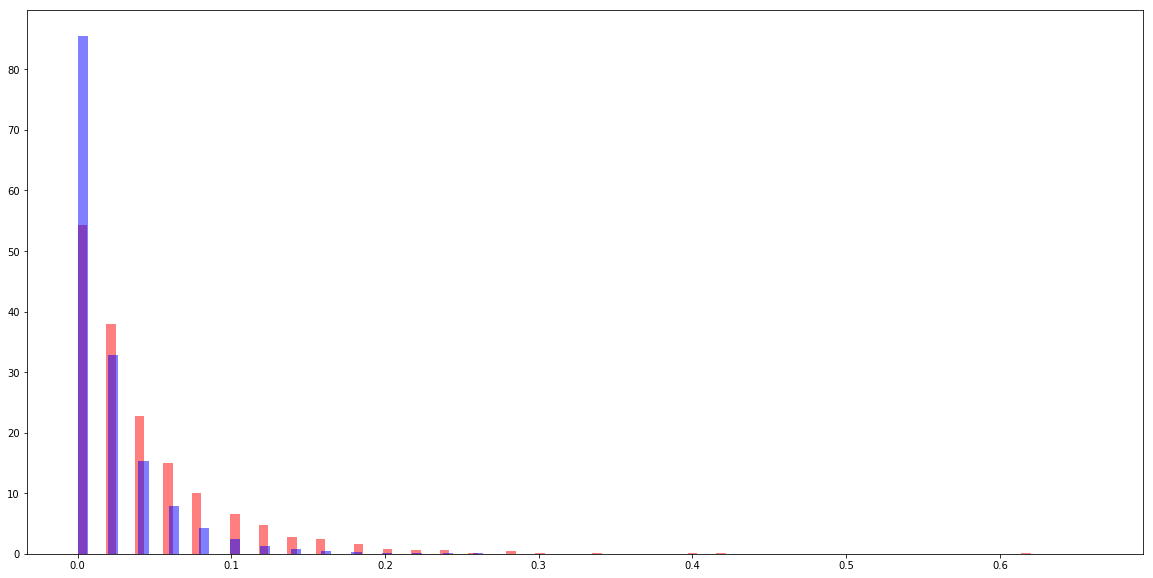

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow_wo_distance//chain experiment for chain 4y4o_2A
target.mean=0.01352007084541385


5it [00:34,  6.97s/it]


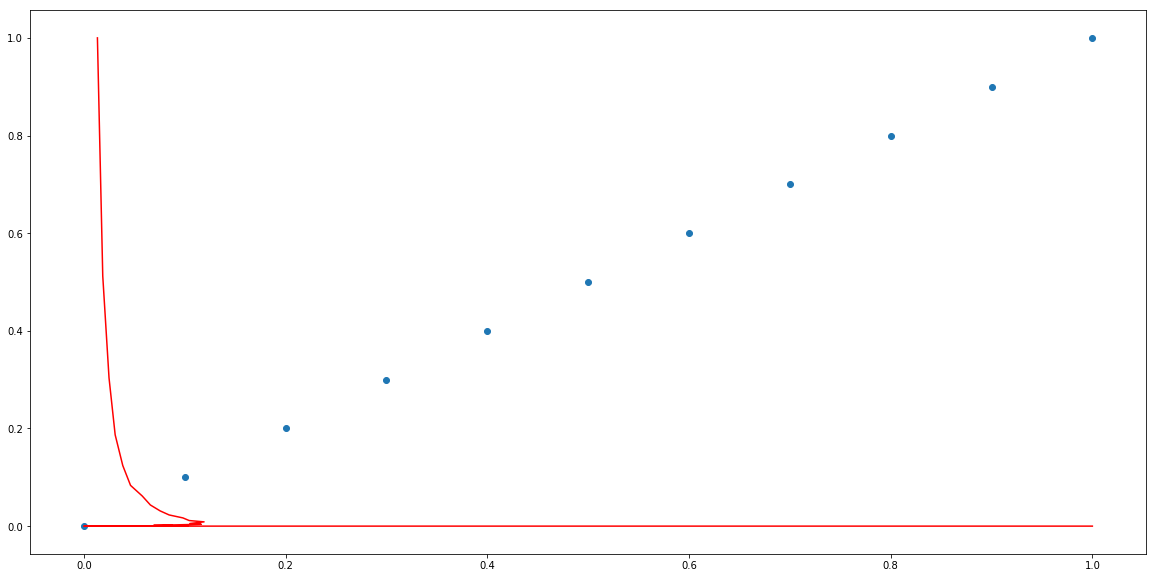

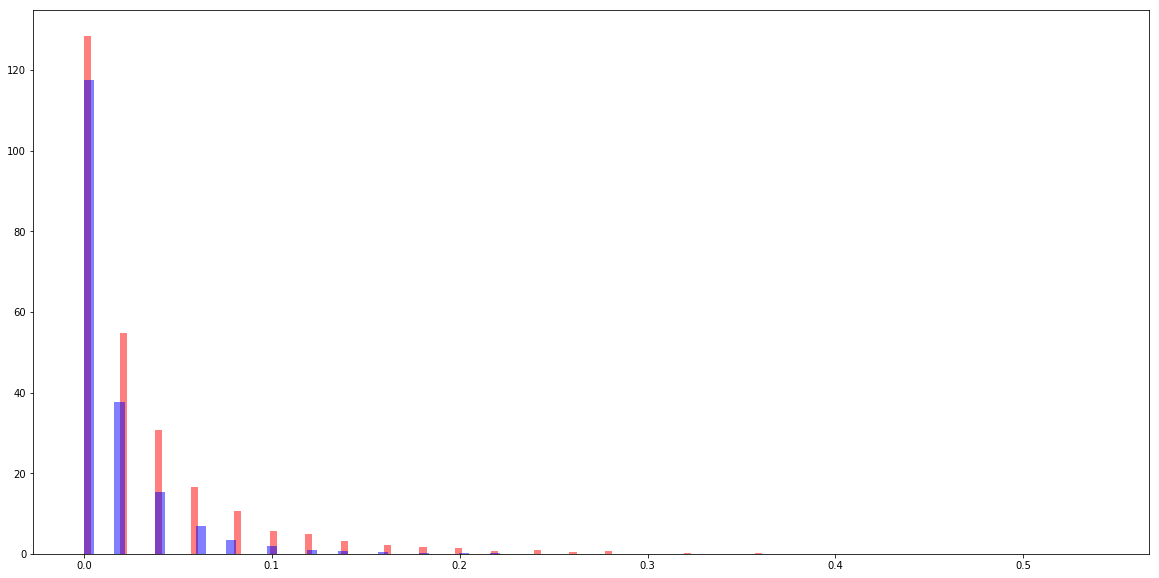

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow_wo_distance//chain experiment for chain 6qzp_L5
target.mean=0.009720534629404616


5it [00:46,  9.33s/it]


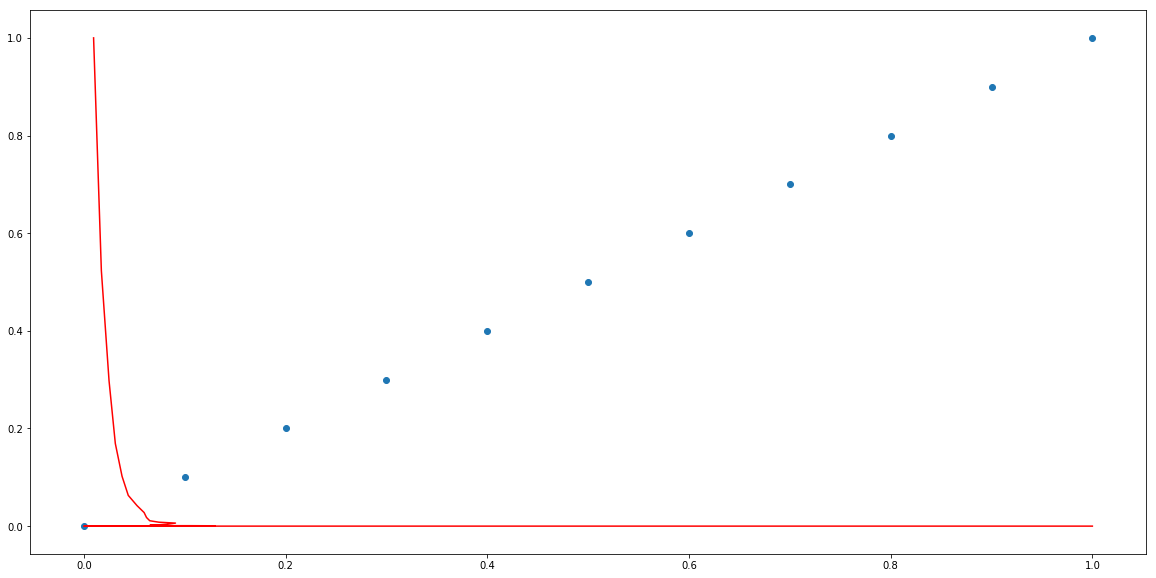

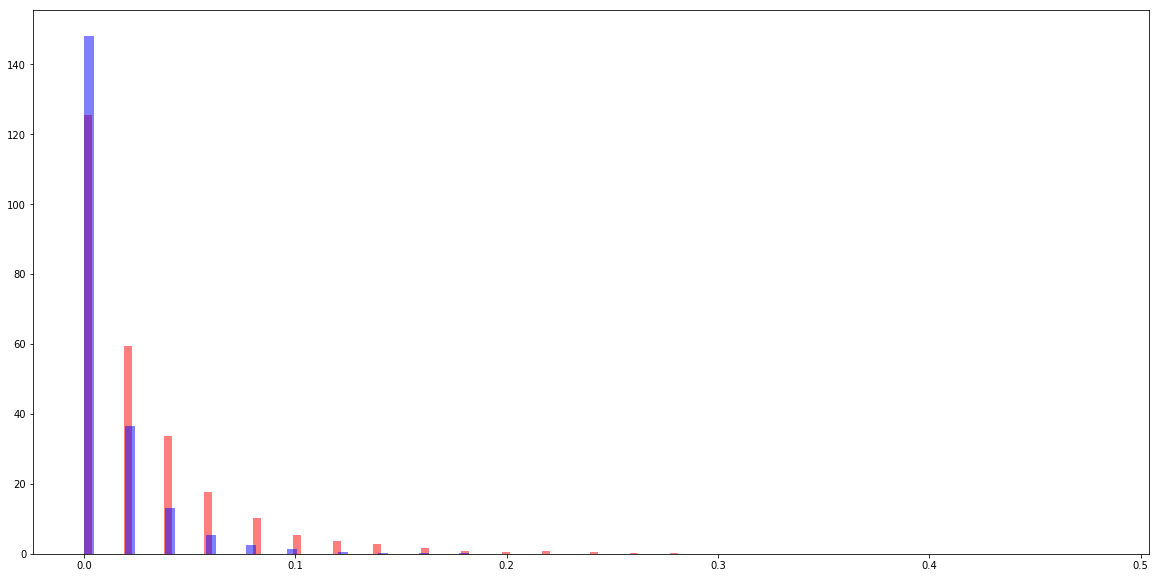

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.04419889502762431


5it [00:02,  2.10it/s]


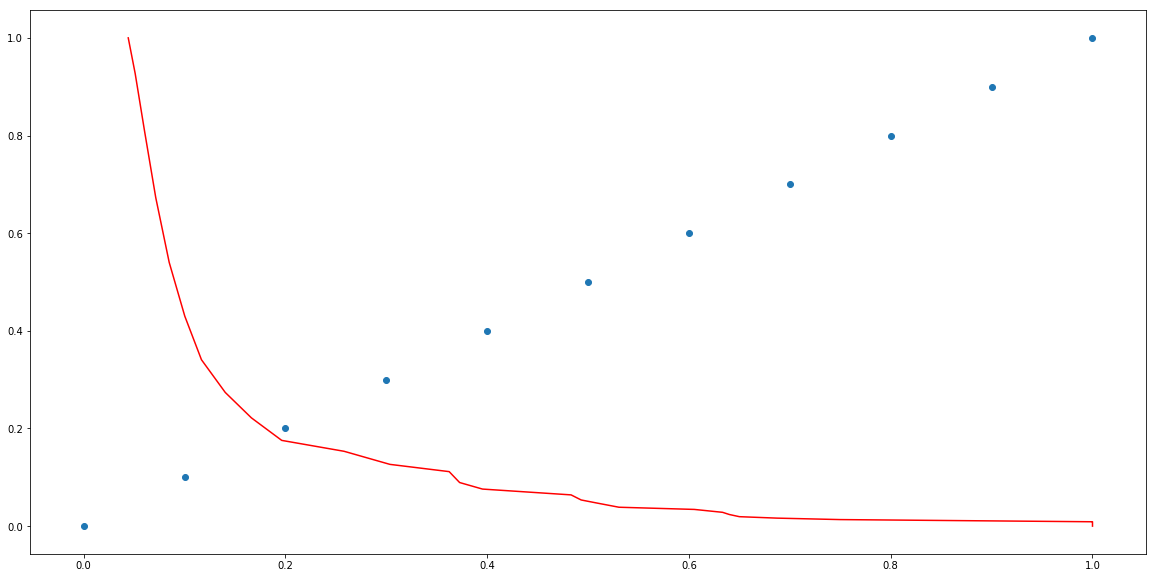

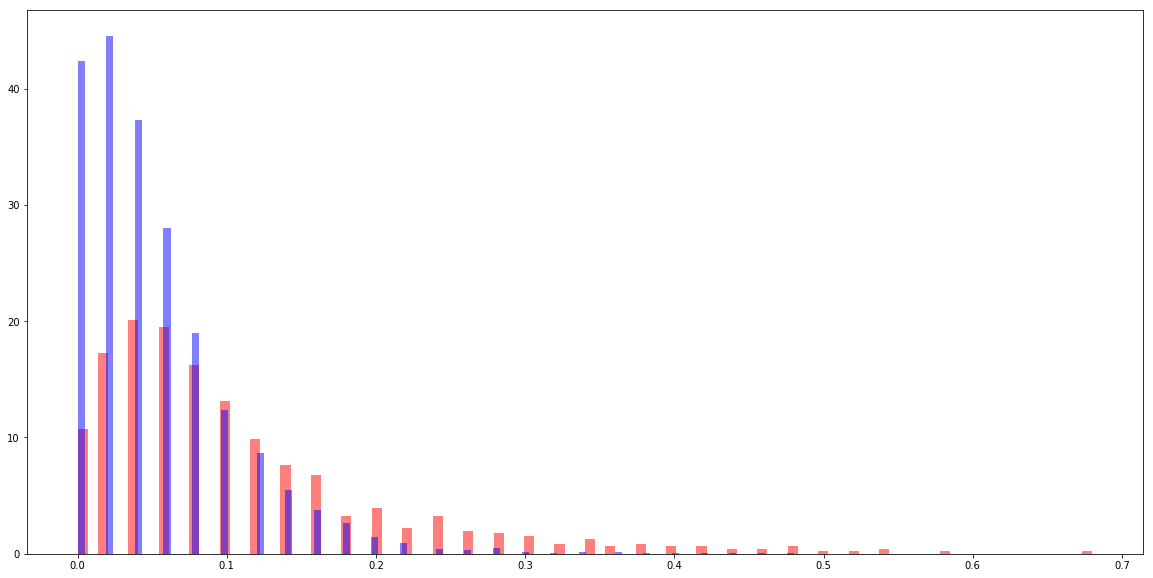

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow//all data stratified
target.mean=0.003705031213881696


5it [02:07, 25.53s/it]


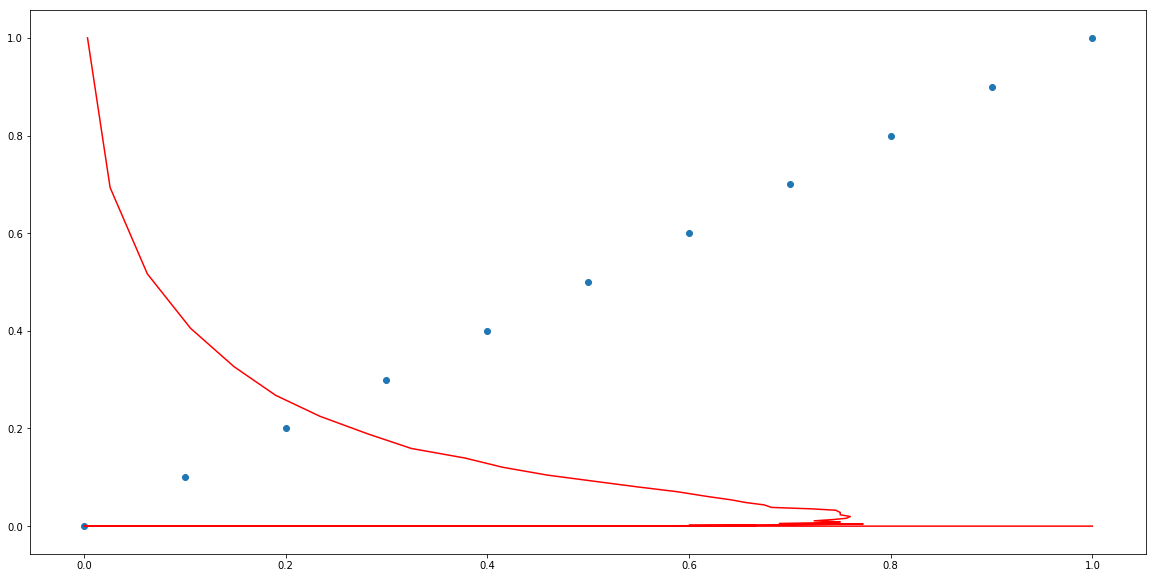

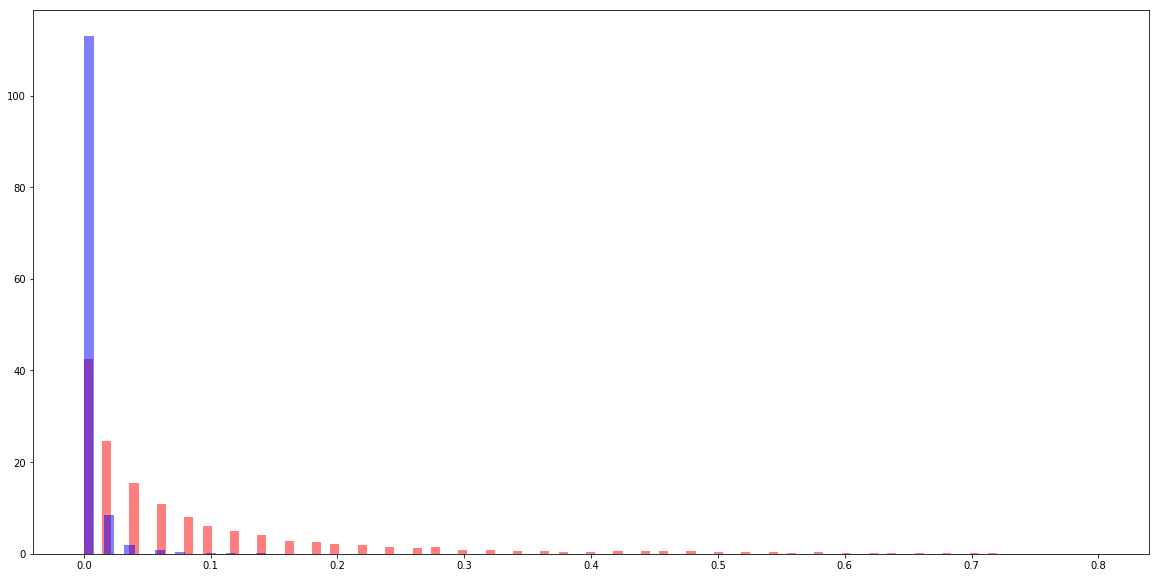

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow//stratified pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.04419889502762431


5it [00:02,  2.12it/s]


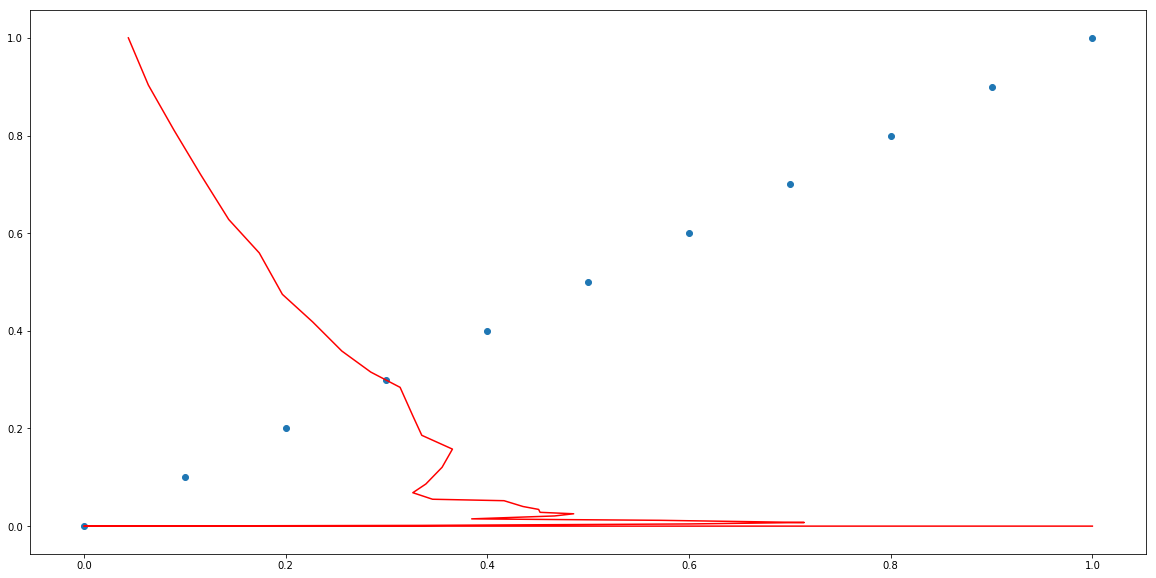

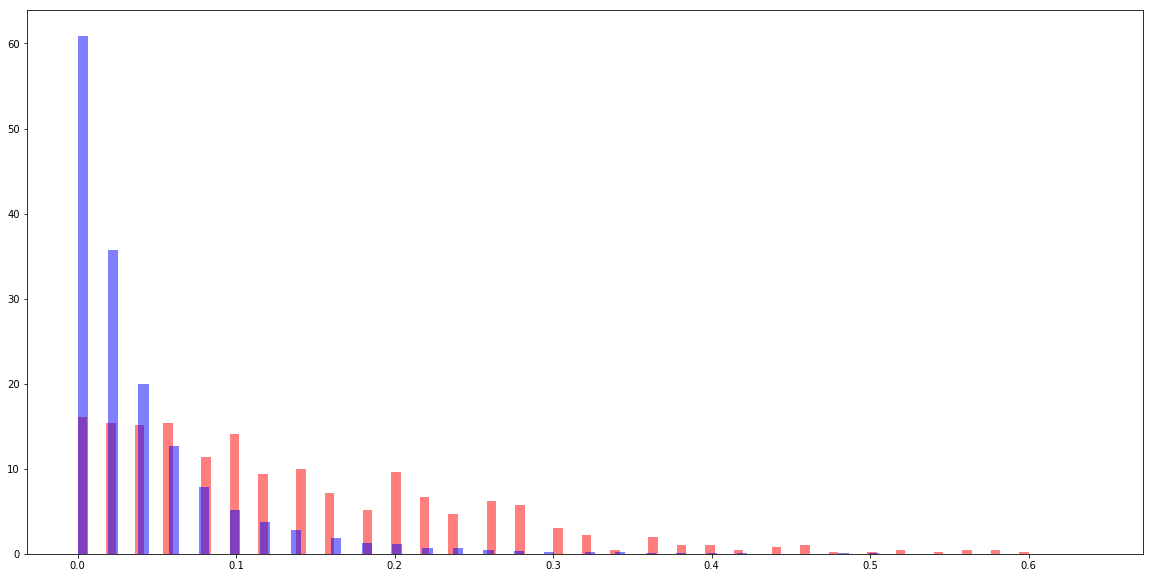

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow//cross chain short -> long
target.mean=0.003705031213881696


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


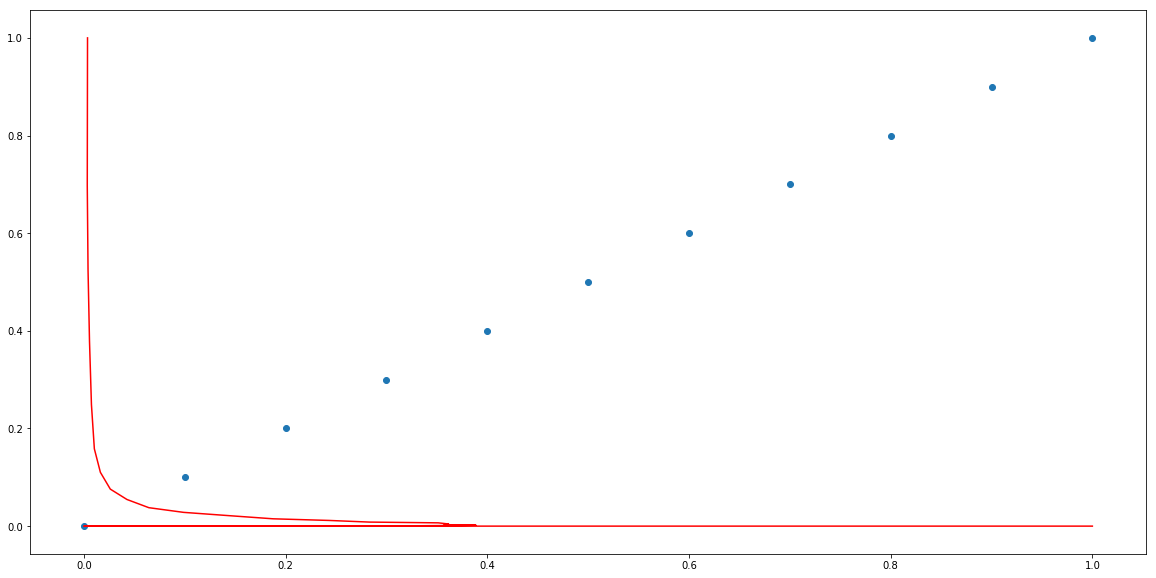

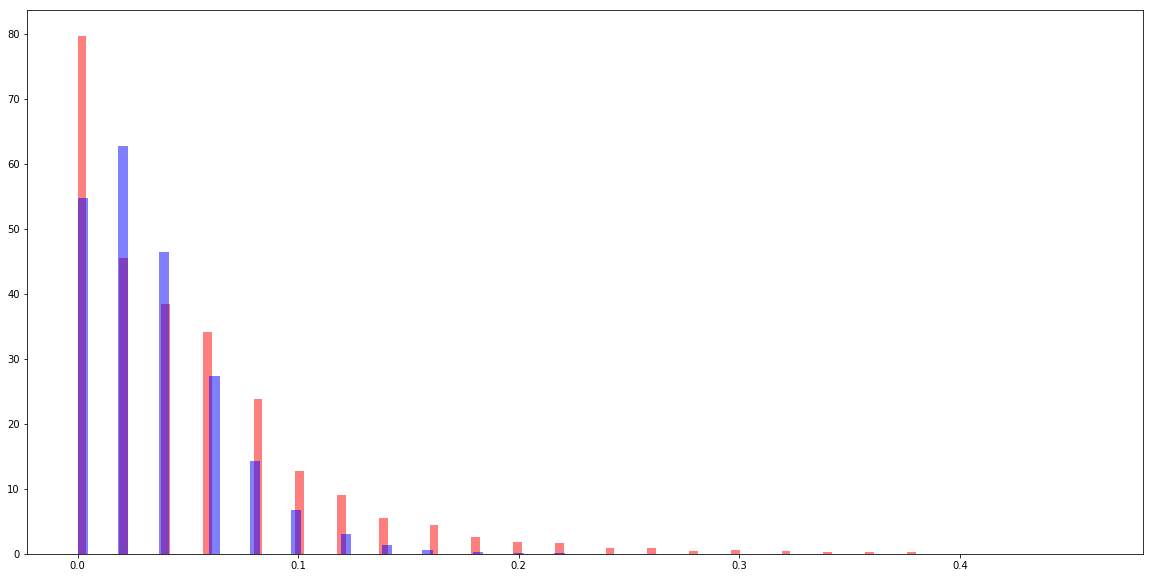

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow//cross chain long -> short
target.mean=0.003705031213881696


100%|██████████| 1/1 [00:31<00:00, 31.28s/it]


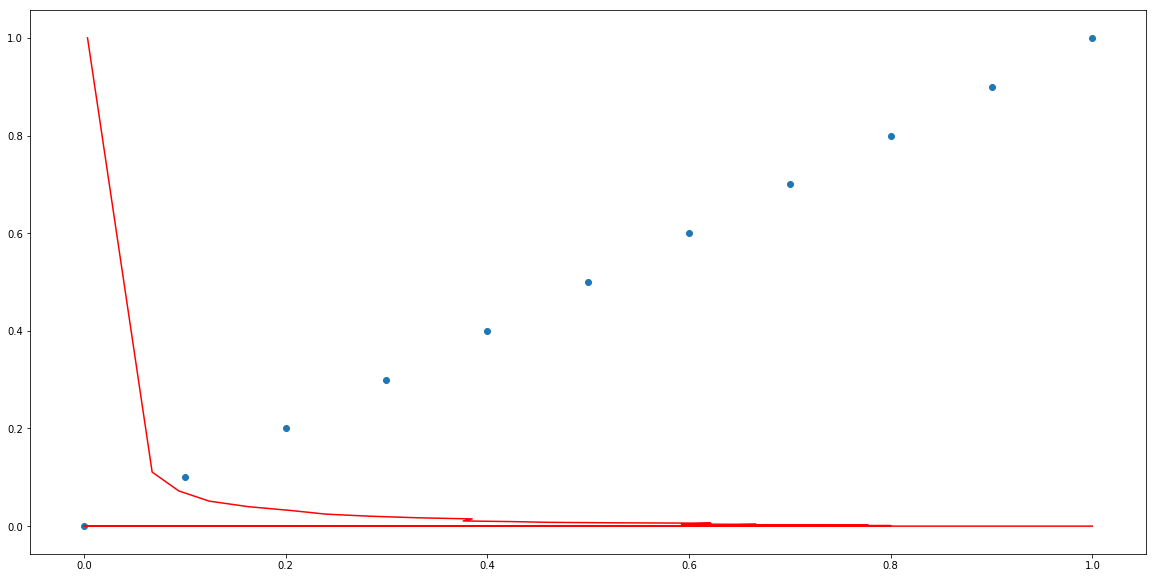

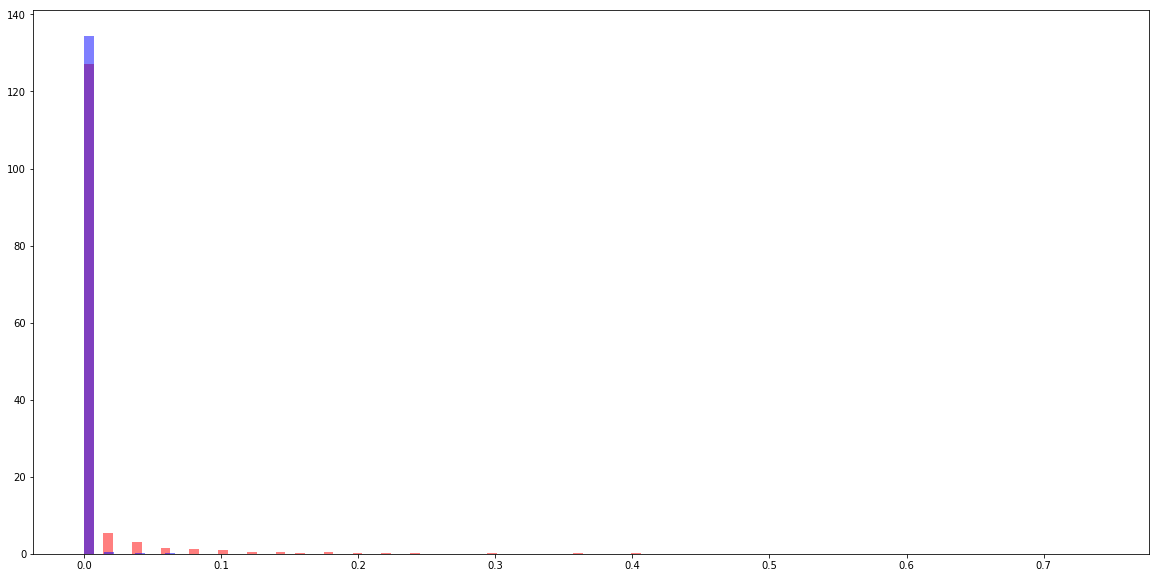

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow//chain pair experiment for chains 4y4o_1a, 6qzp_S2
target.mean=0.004850392167995523


100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


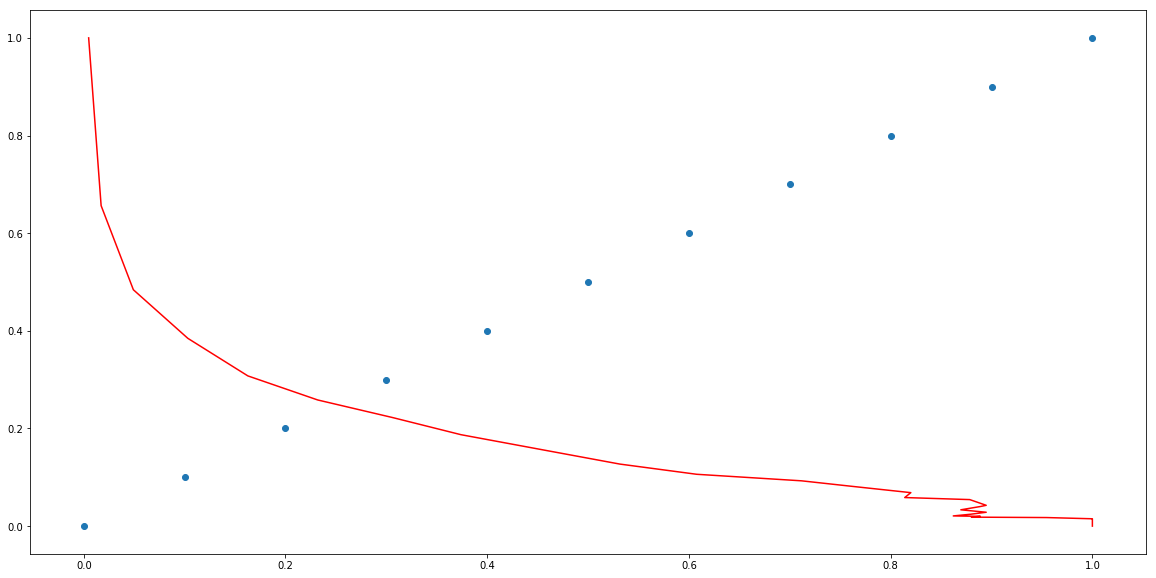

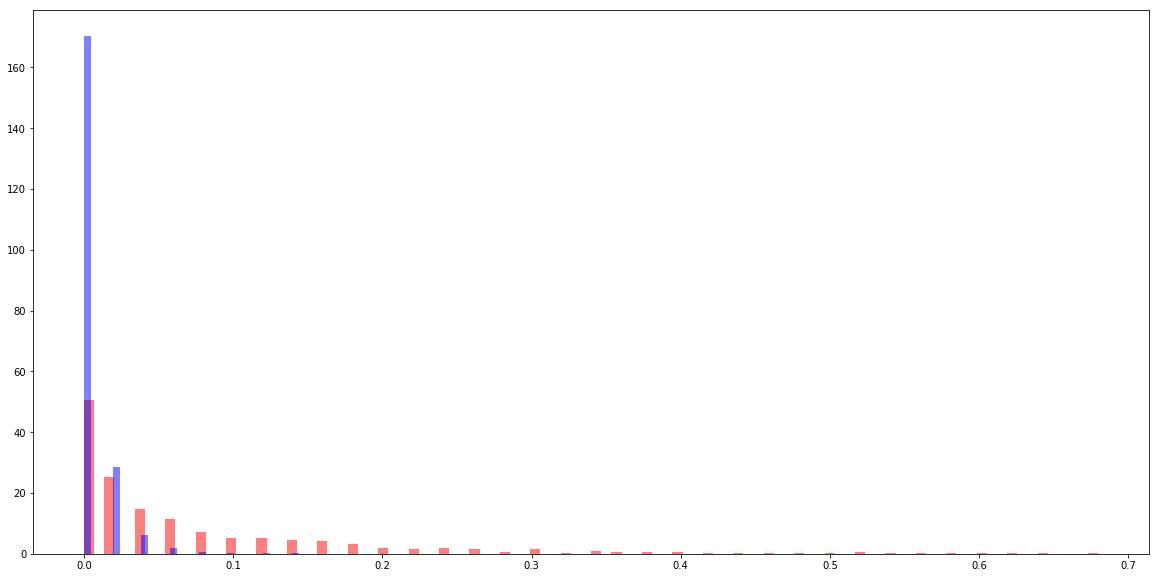

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow//chain pair experiment for chains 4y4o_2A, 6qzp_L5
target.mean=0.002537693723437524


100%|██████████| 2/2 [00:19<00:00,  9.60s/it]


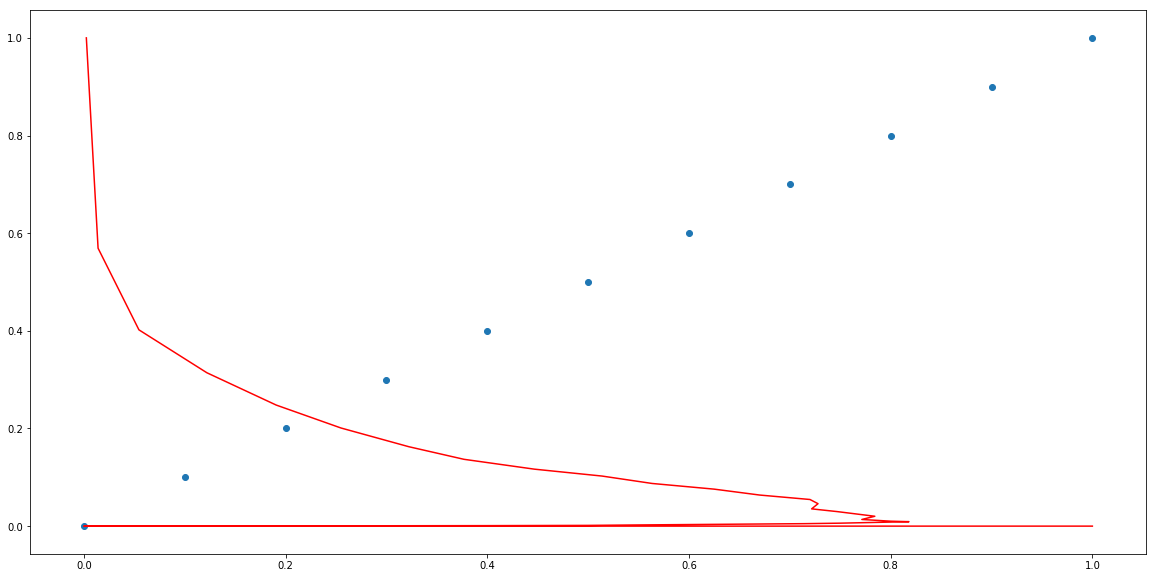

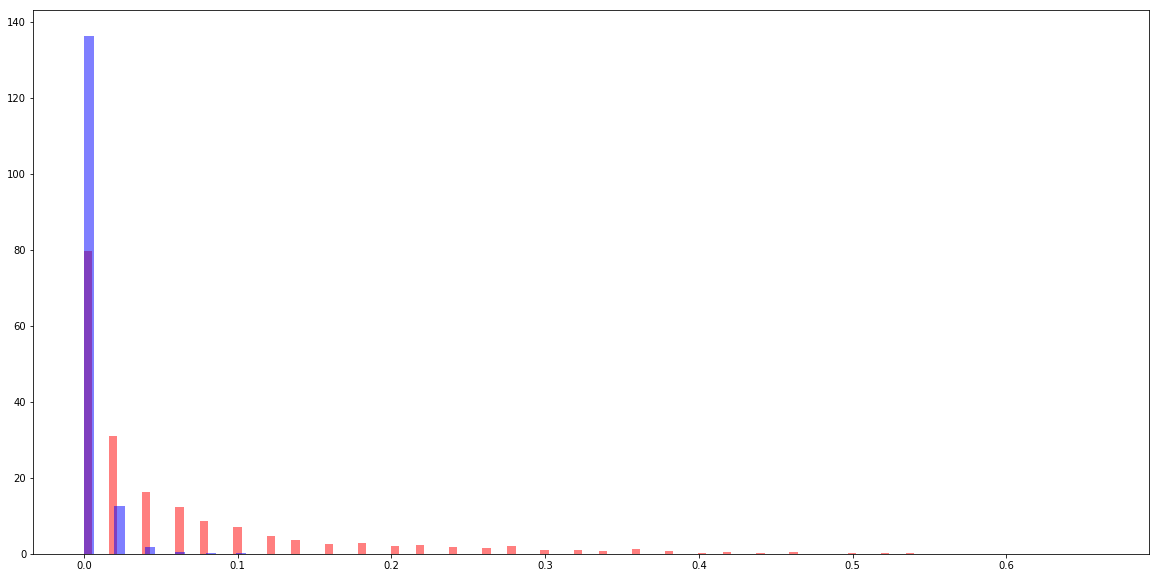

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow//chain experiment for chain 4y4o_1a
target.mean=0.00549666977010671


5it [00:08,  1.69s/it]


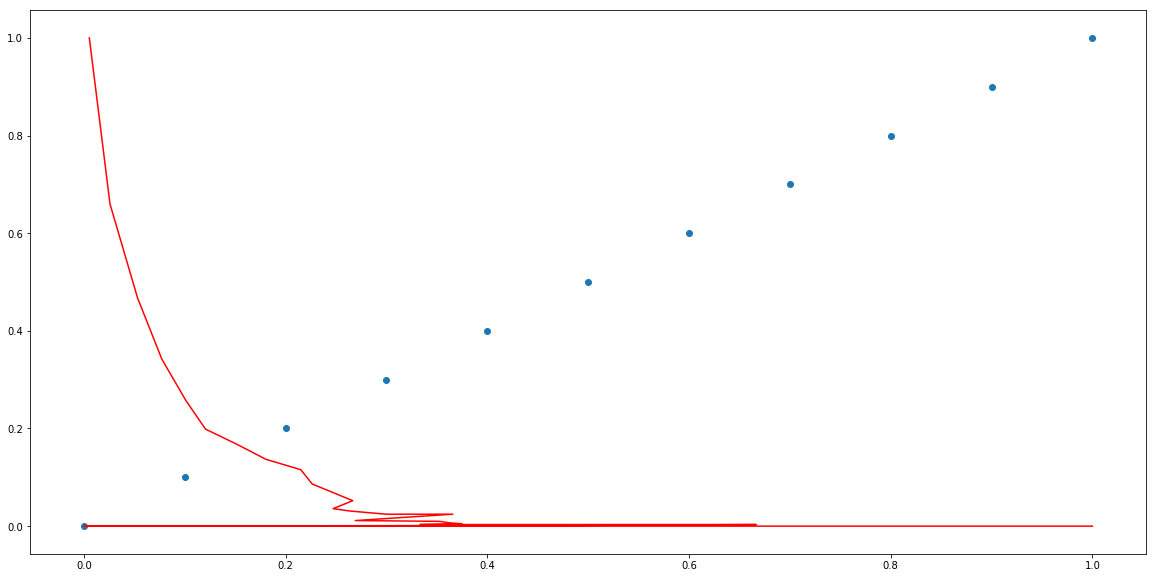

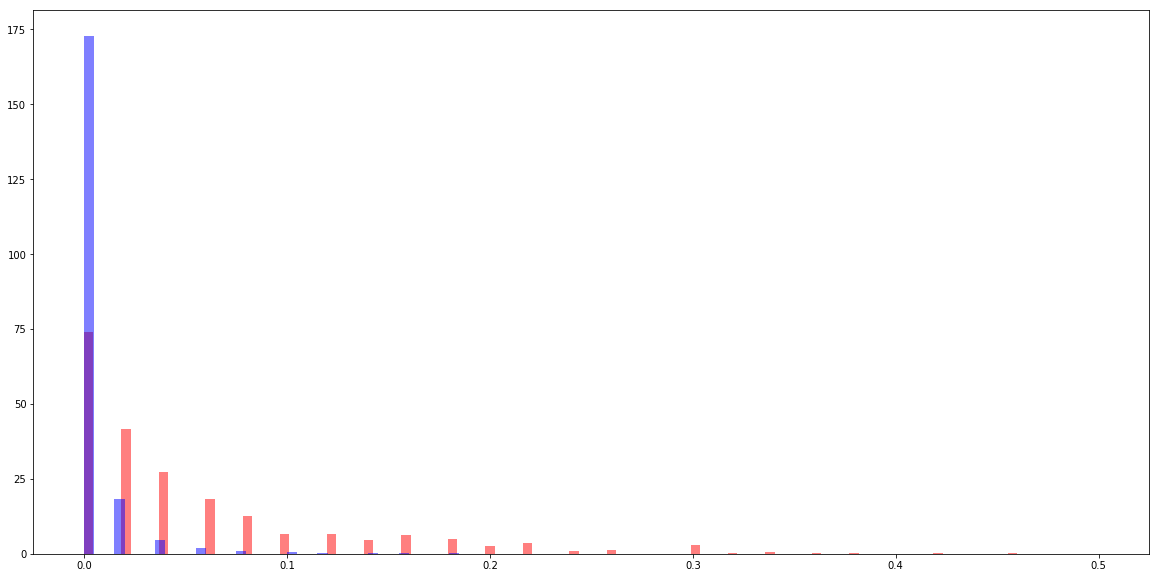

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow//chain experiment for chain 6qzp_S2
target.mean=0.004315138573779973


5it [00:10,  2.07s/it]


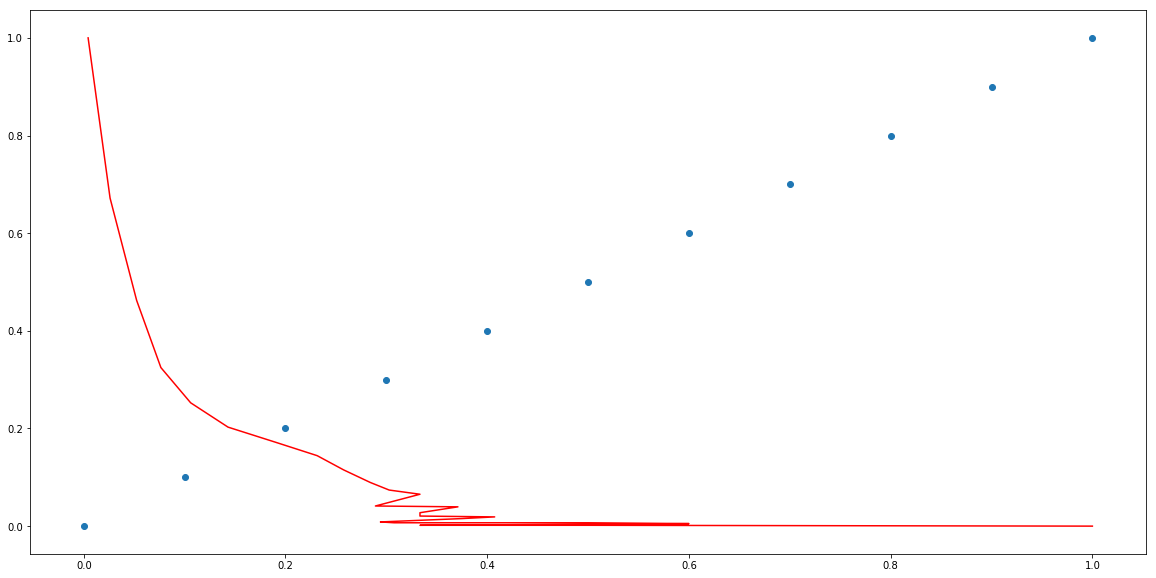

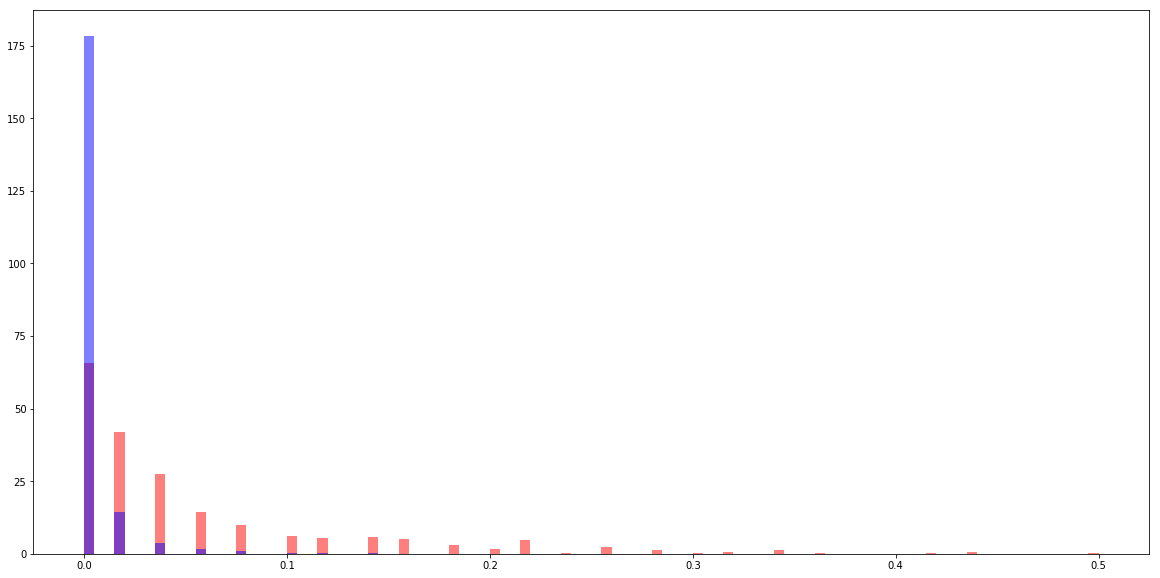

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow//chain experiment for chain 4y4o_2A
target.mean=0.0030810683453454724


5it [00:30,  6.05s/it]


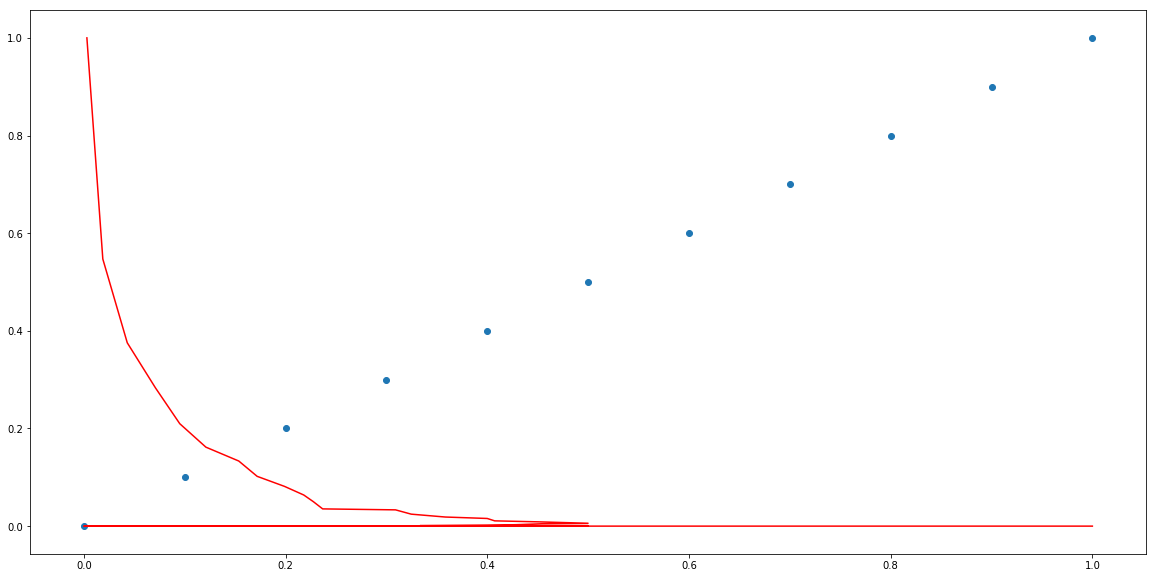

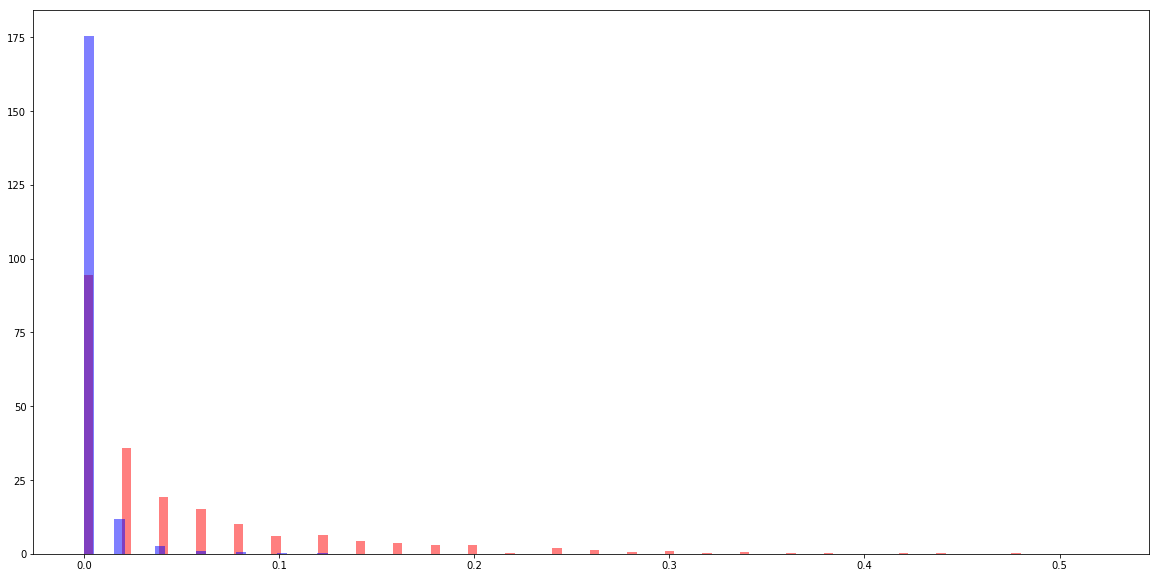

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow//chain experiment for chain 6qzp_L5
target.mean=0.0021372183213040595


5it [00:39,  7.97s/it]


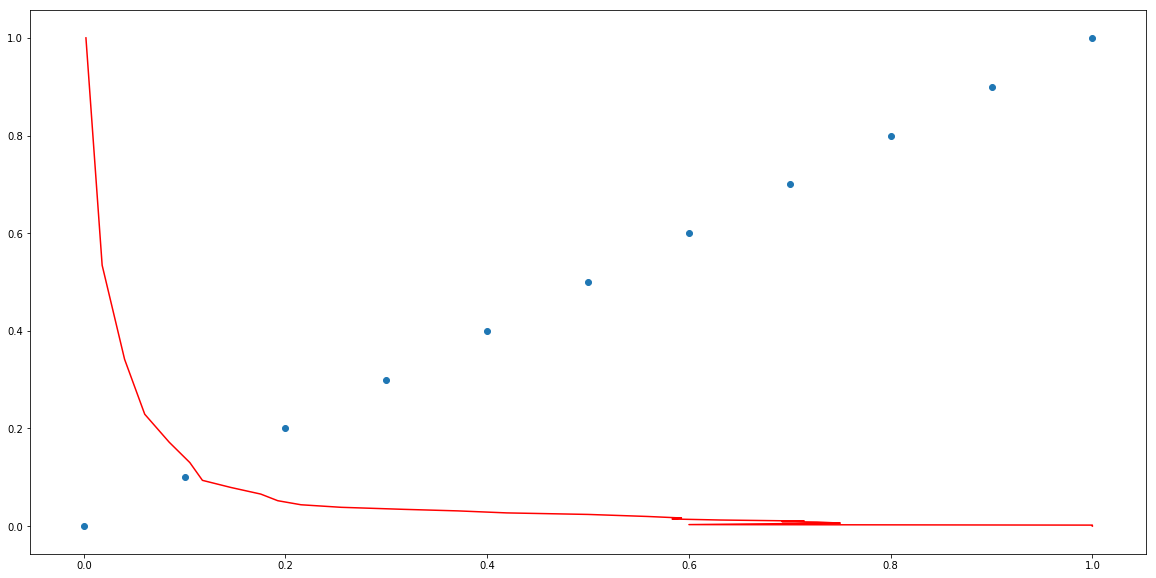

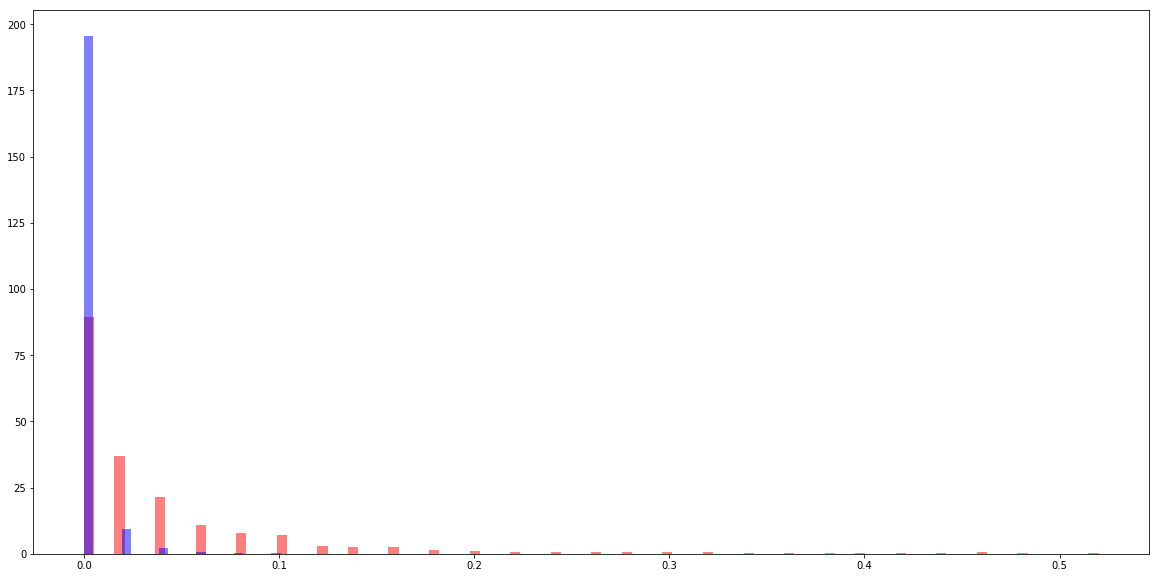

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.10186941208344621


5it [00:02,  2.11it/s]


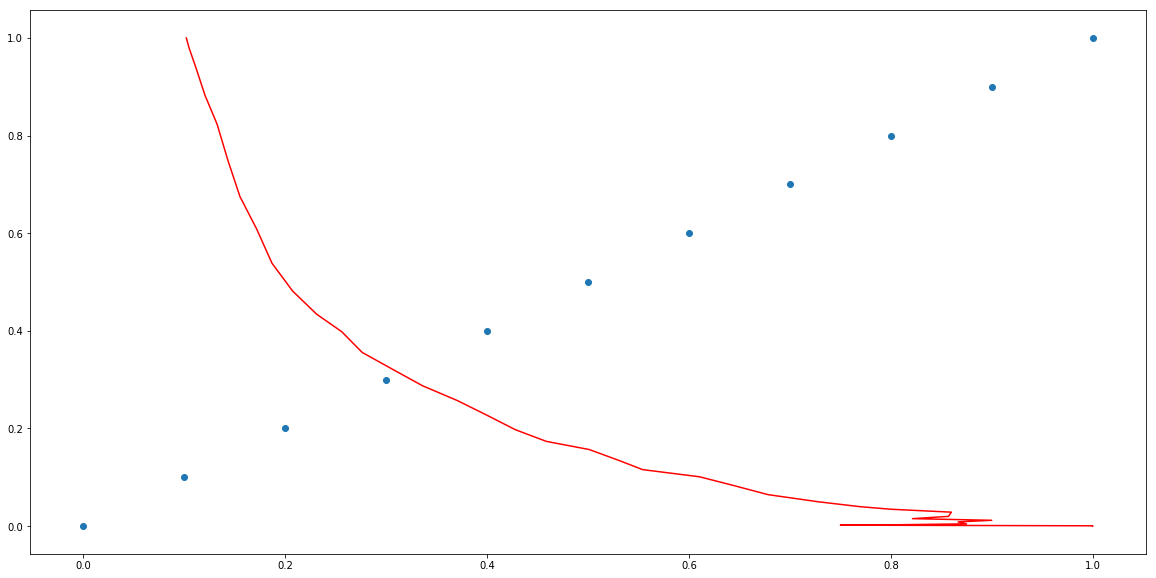

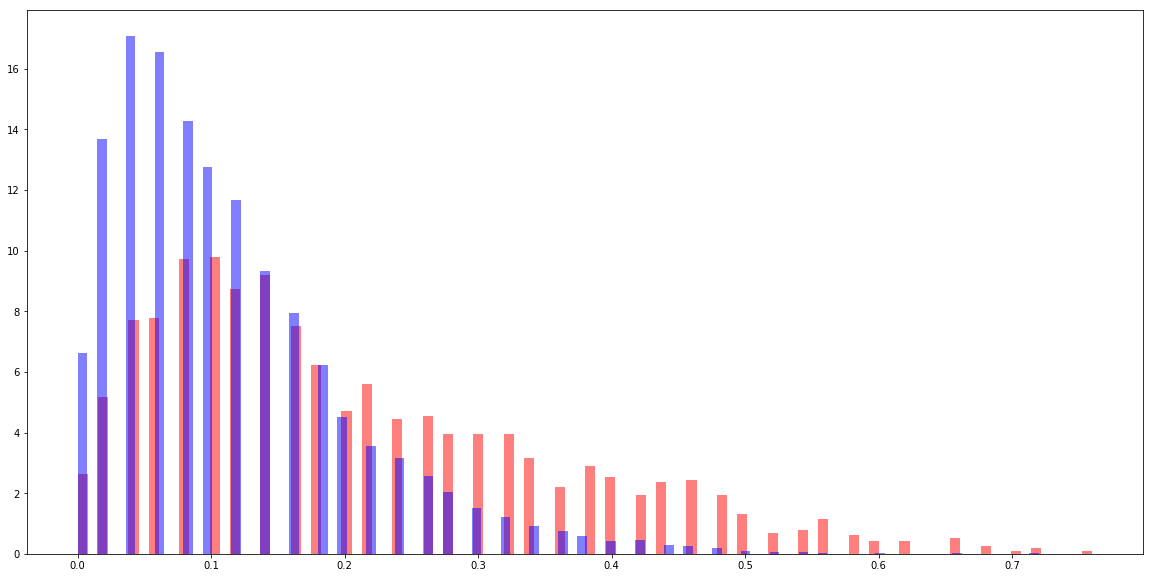

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow//all data stratified
target.mean=0.009263313973141575


5it [02:17, 27.59s/it]


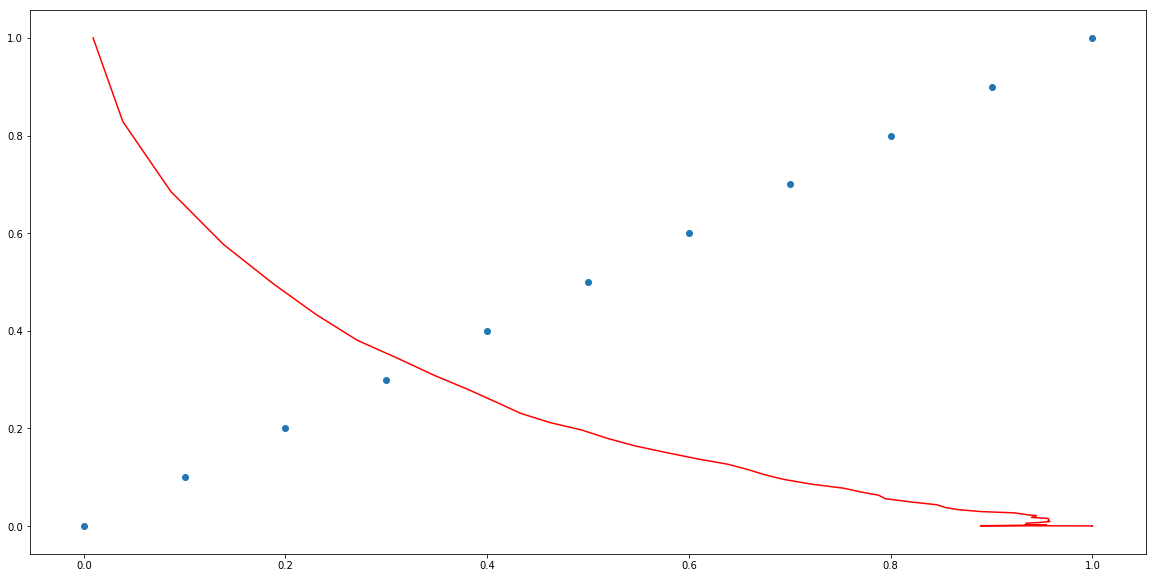

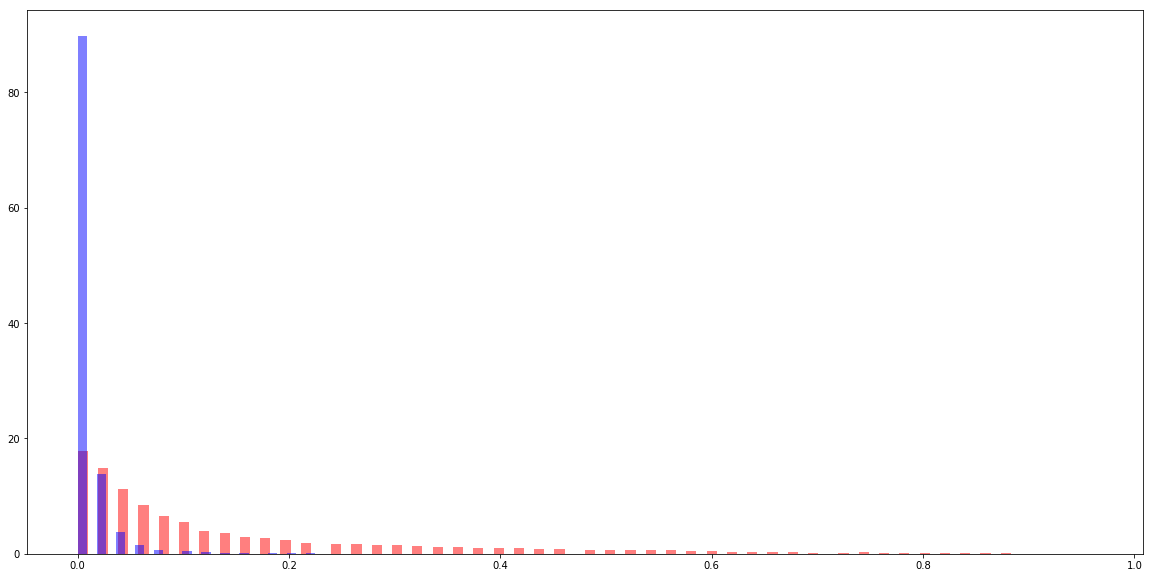

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow//stratified pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.10186941208344621


5it [00:02,  2.12it/s]


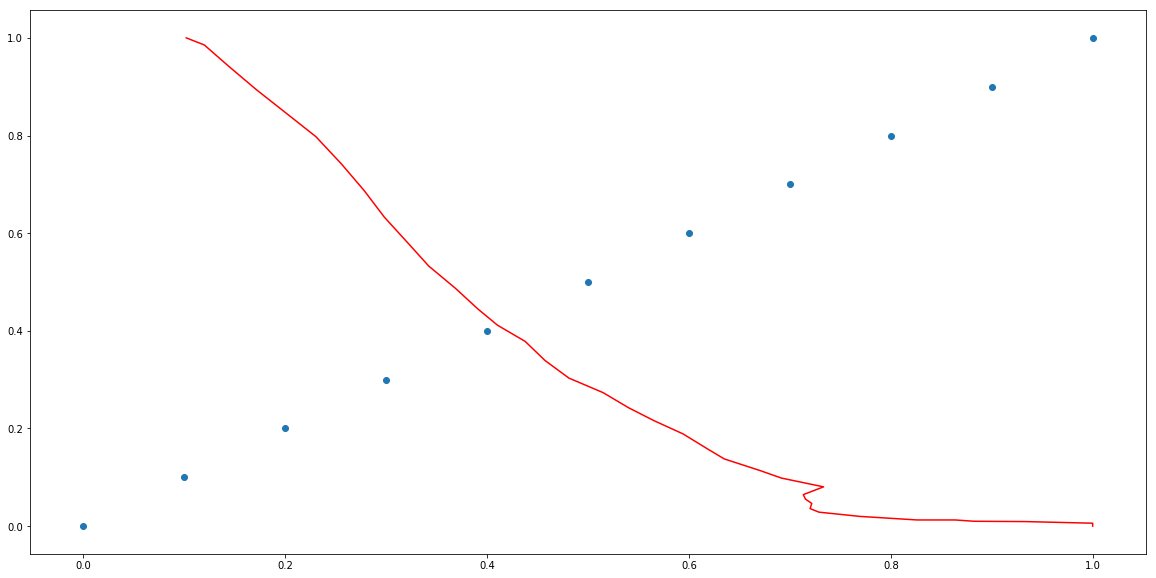

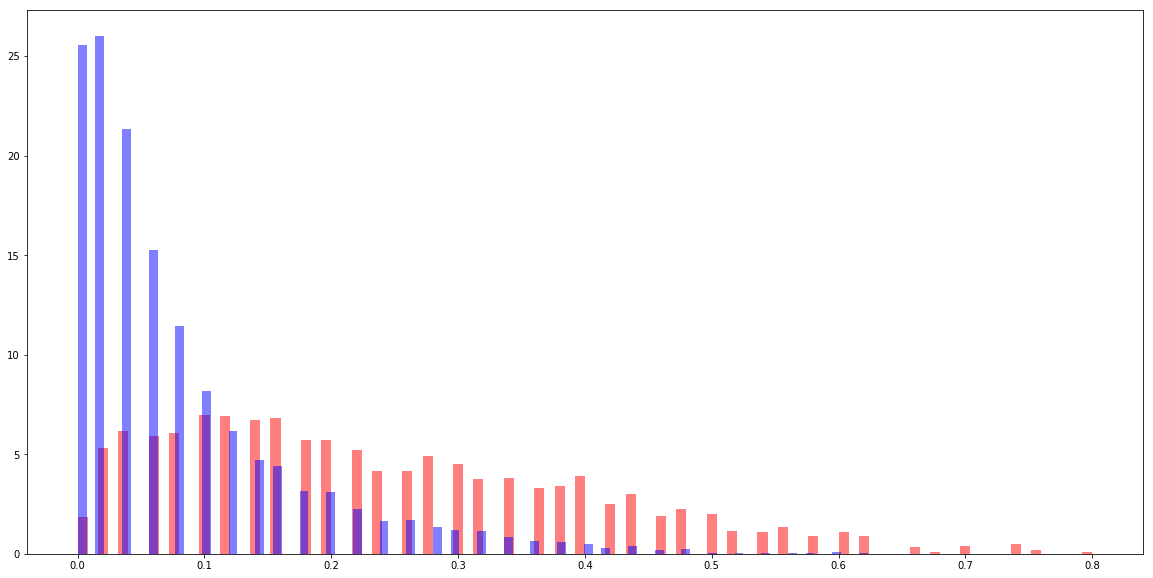

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow//cross chain short -> long
target.mean=0.009263313973141575


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


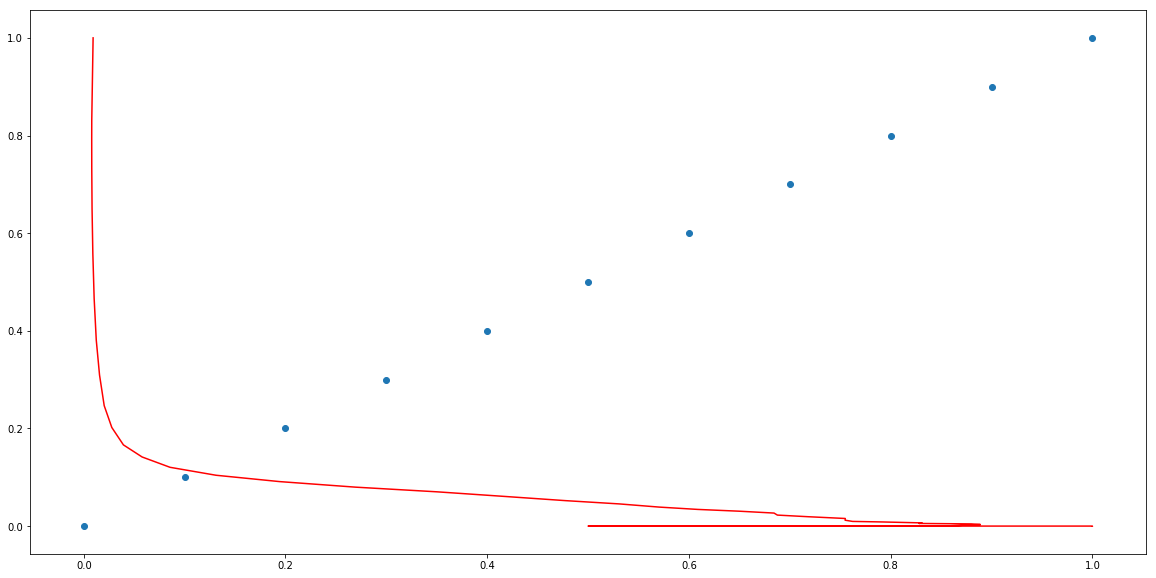

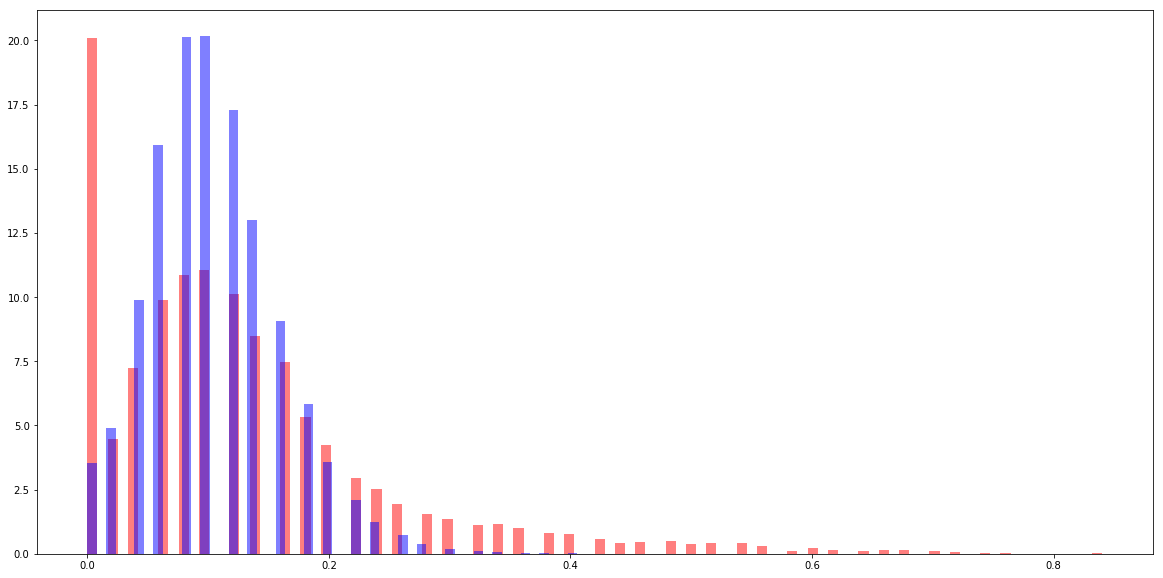

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow//cross chain long -> short
target.mean=0.009263313973141575


100%|██████████| 1/1 [00:34<00:00, 34.18s/it]


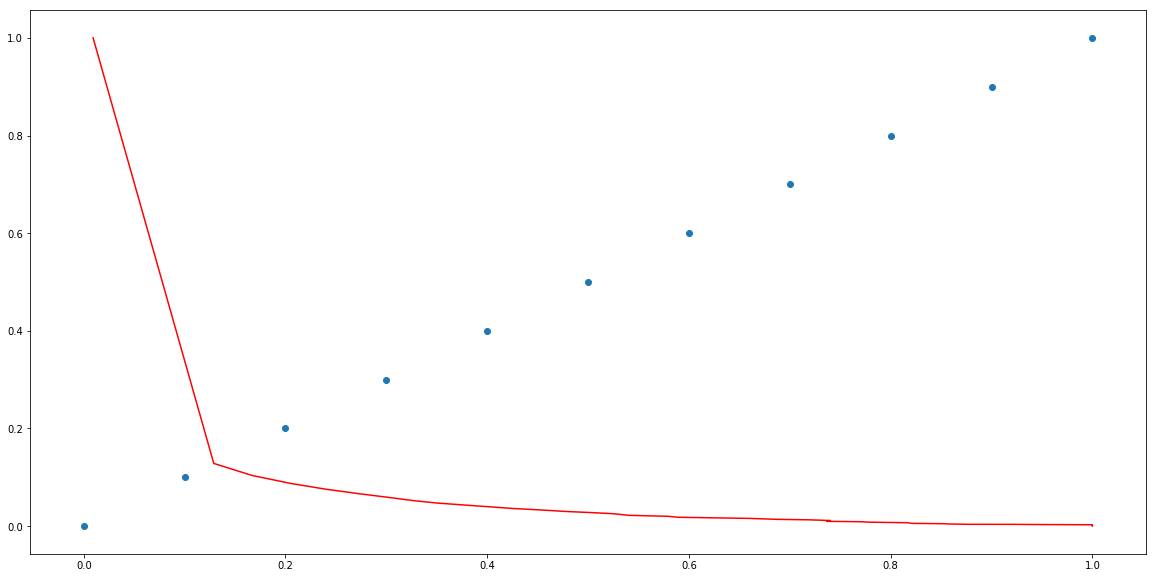

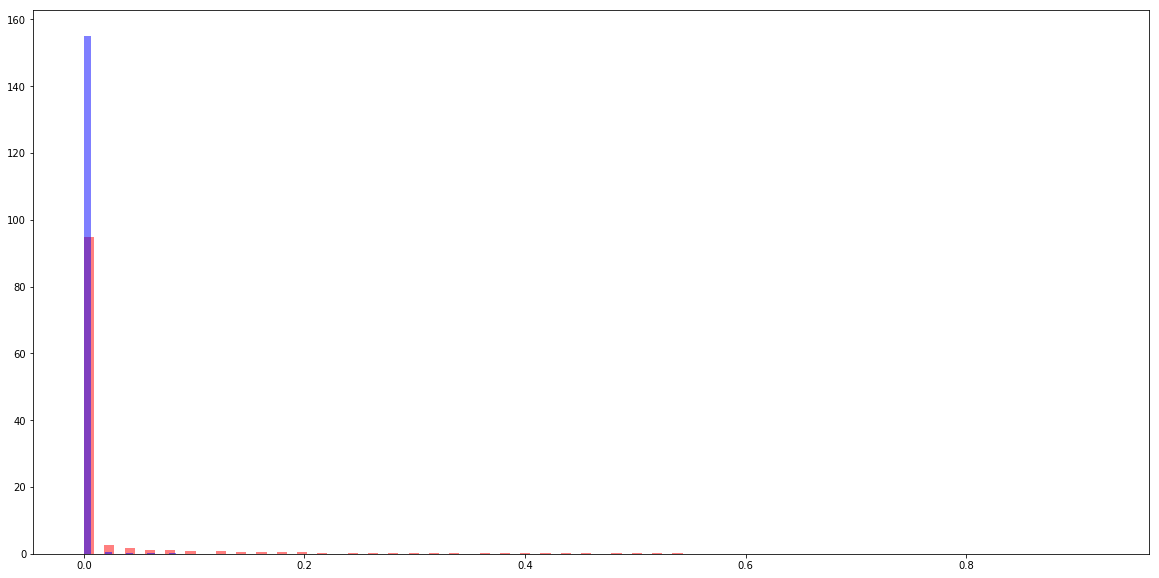

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow//chain pair experiment for chains 4y4o_1a, 6qzp_S2
target.mean=0.012053386253283775


100%|██████████| 2/2 [00:05<00:00,  2.80s/it]


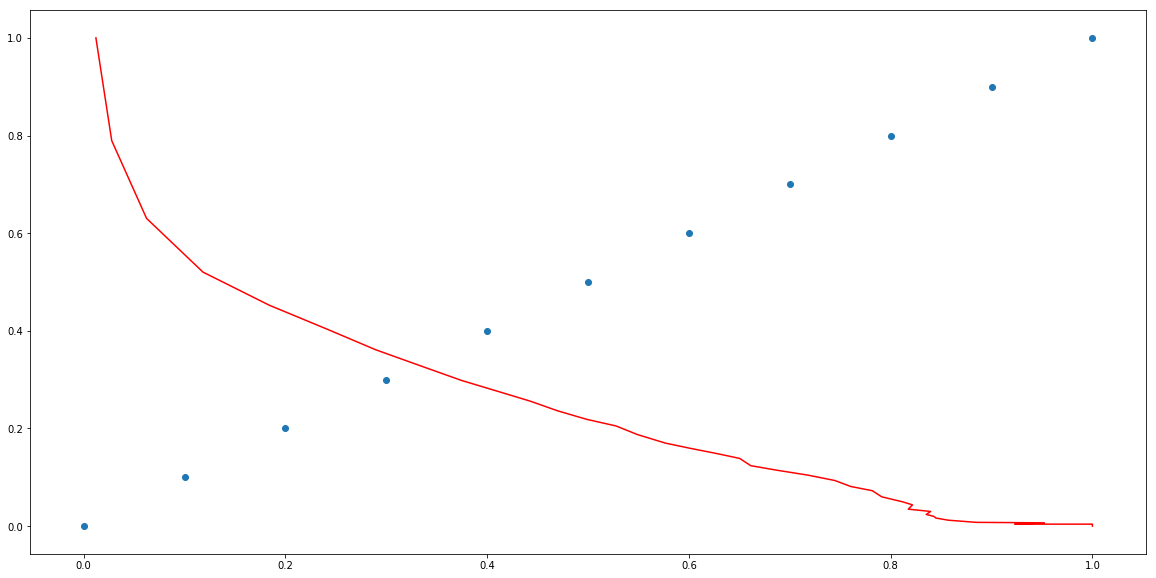

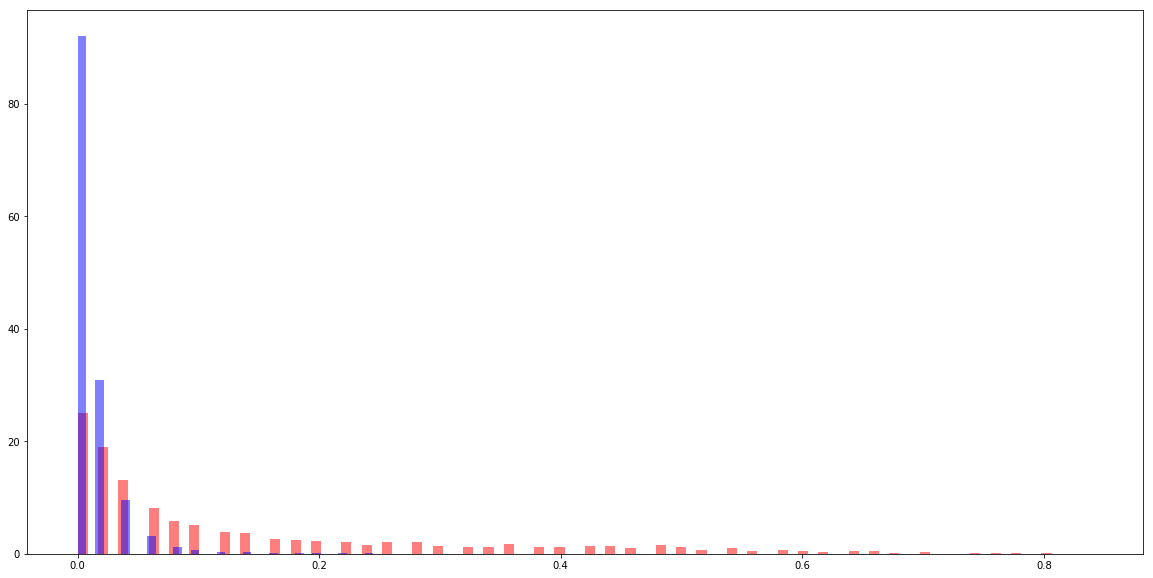

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow//chain pair experiment for chains 4y4o_2A, 6qzp_L5
target.mean=0.006552370197366732


100%|██████████| 2/2 [00:21<00:00, 10.64s/it]


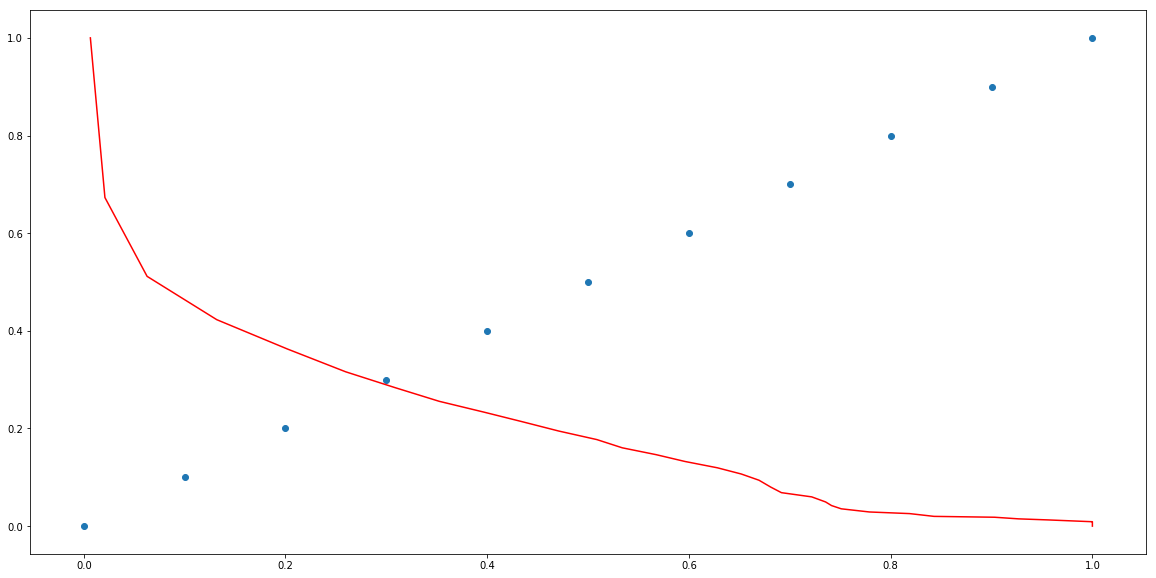

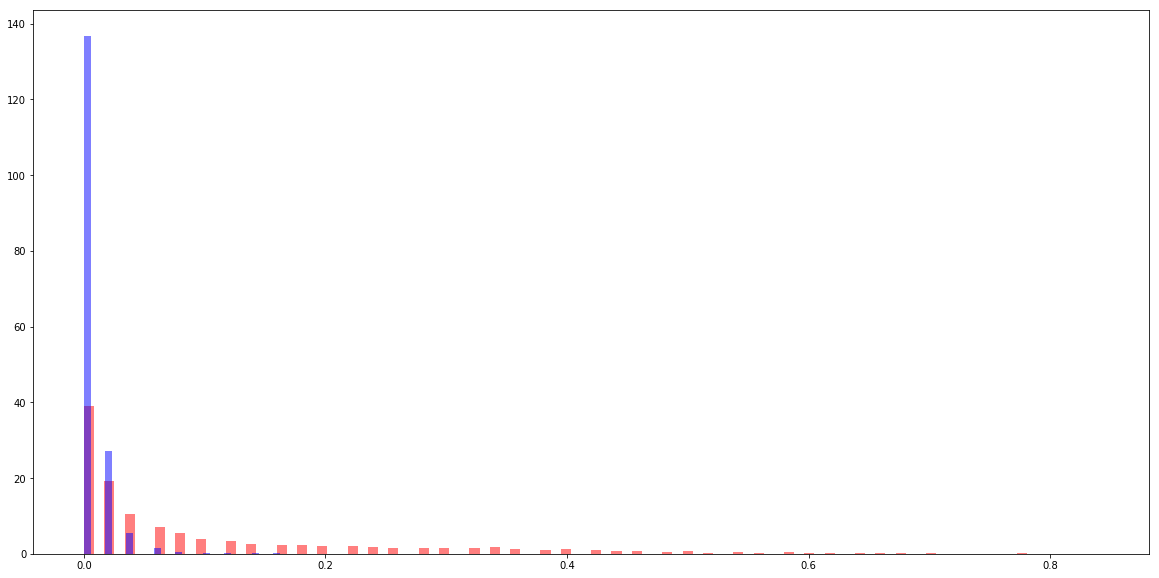

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow//chain experiment for chain 4y4o_1a
target.mean=0.013284265326272327


5it [00:08,  1.80s/it]


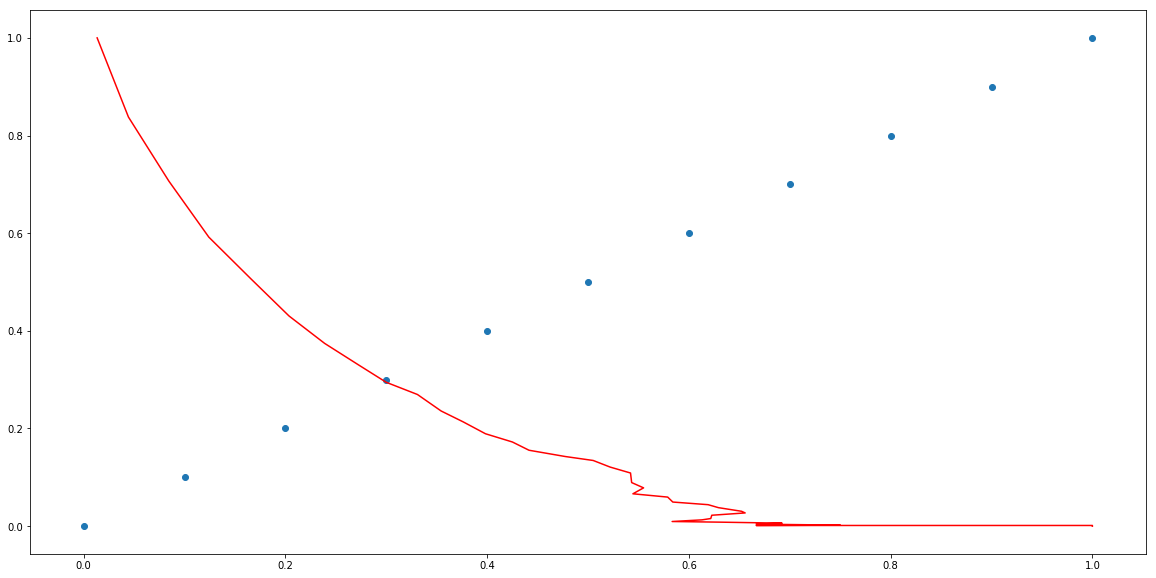

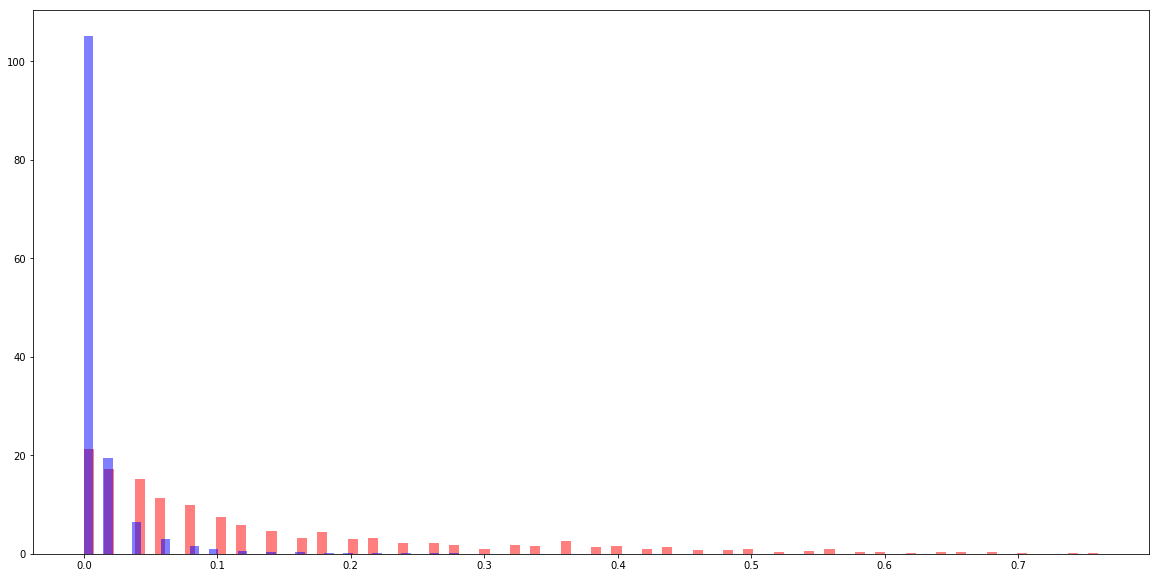

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow//chain experiment for chain 6qzp_S2
target.mean=0.011033785391387104


5it [00:11,  2.28s/it]


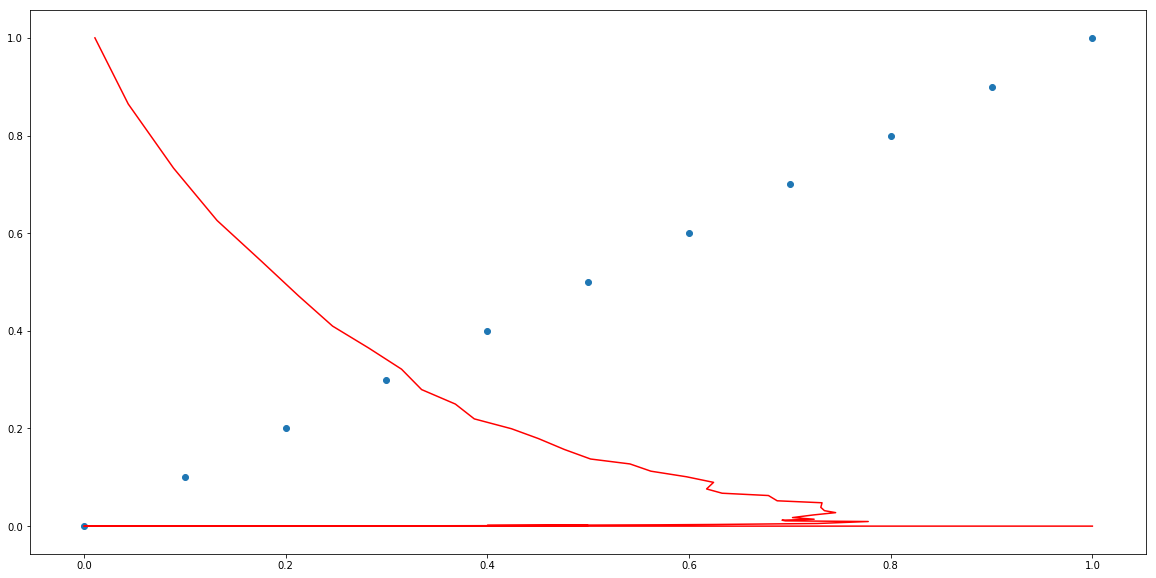

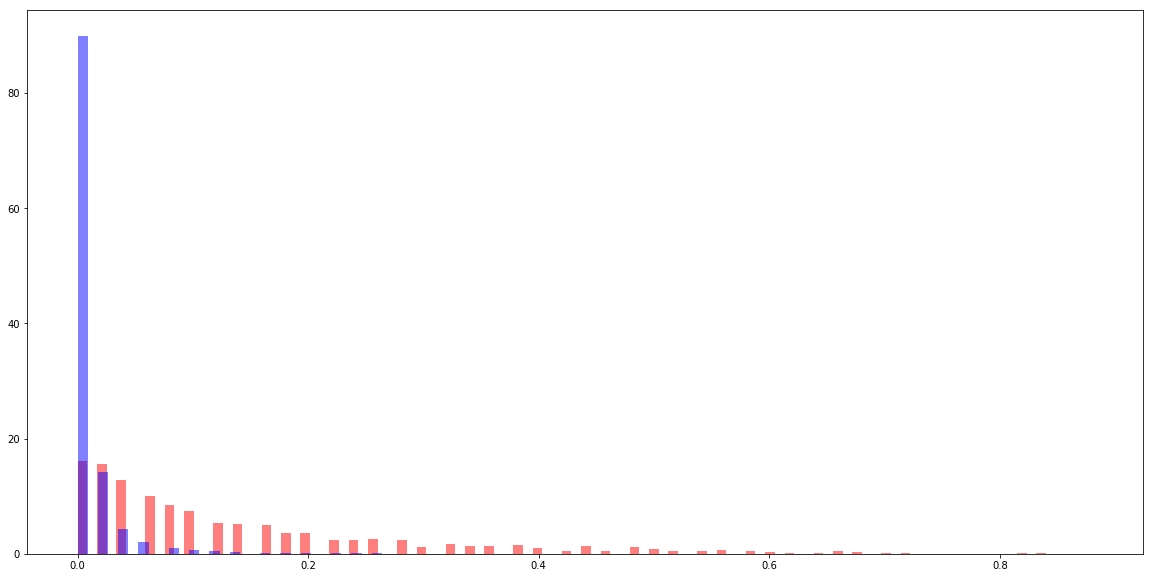

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow//chain experiment for chain 4y4o_2A
target.mean=0.007840053234929372


5it [00:34,  6.94s/it]


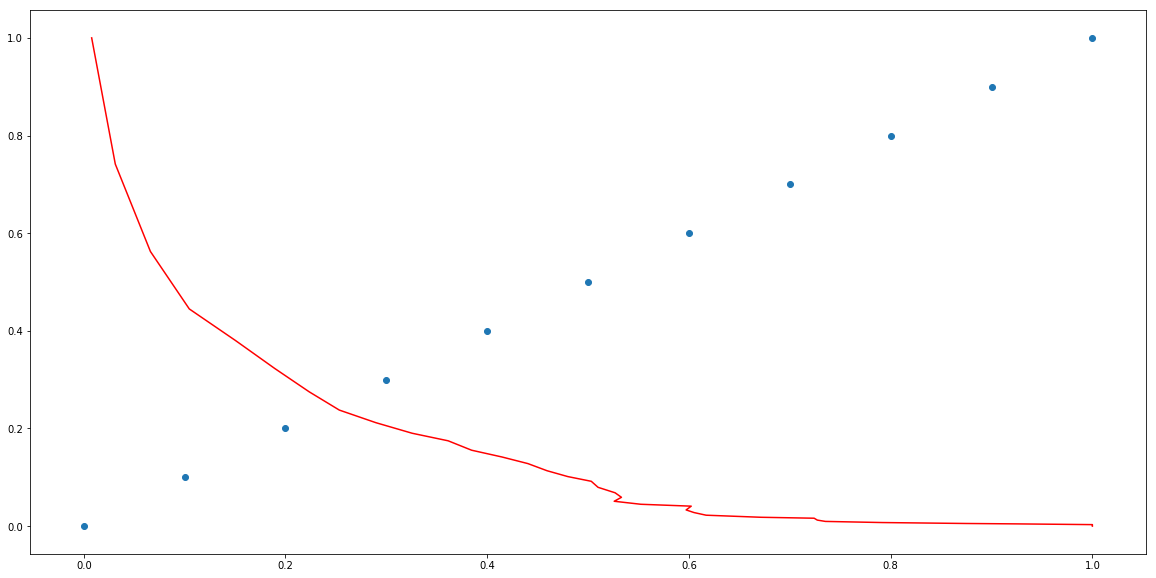

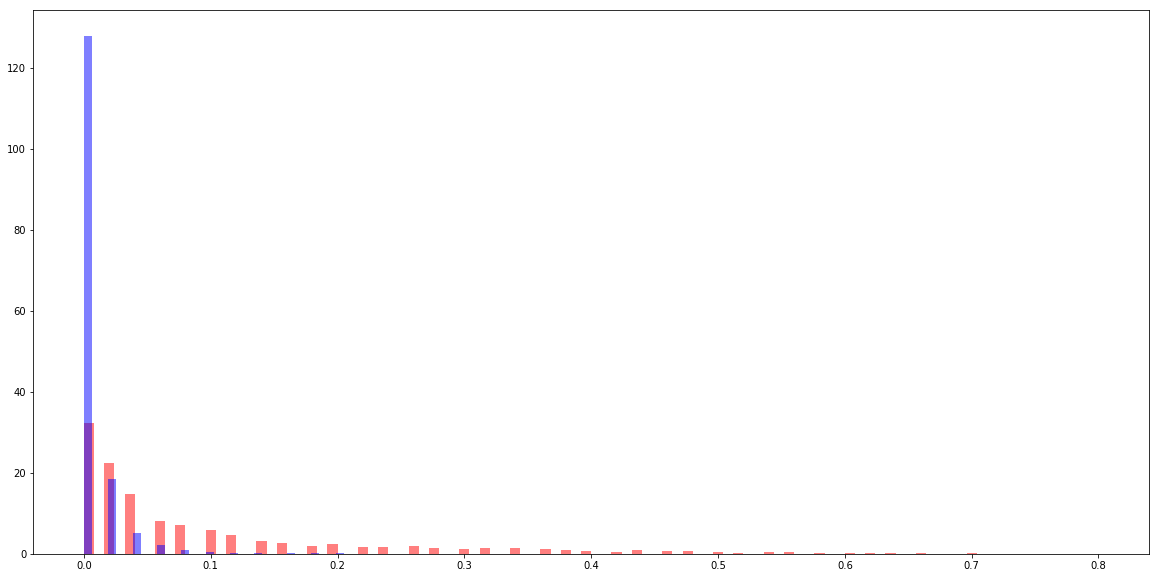

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow//chain experiment for chain 6qzp_L5
target.mean=0.0056034770979605485


5it [00:45,  9.15s/it]


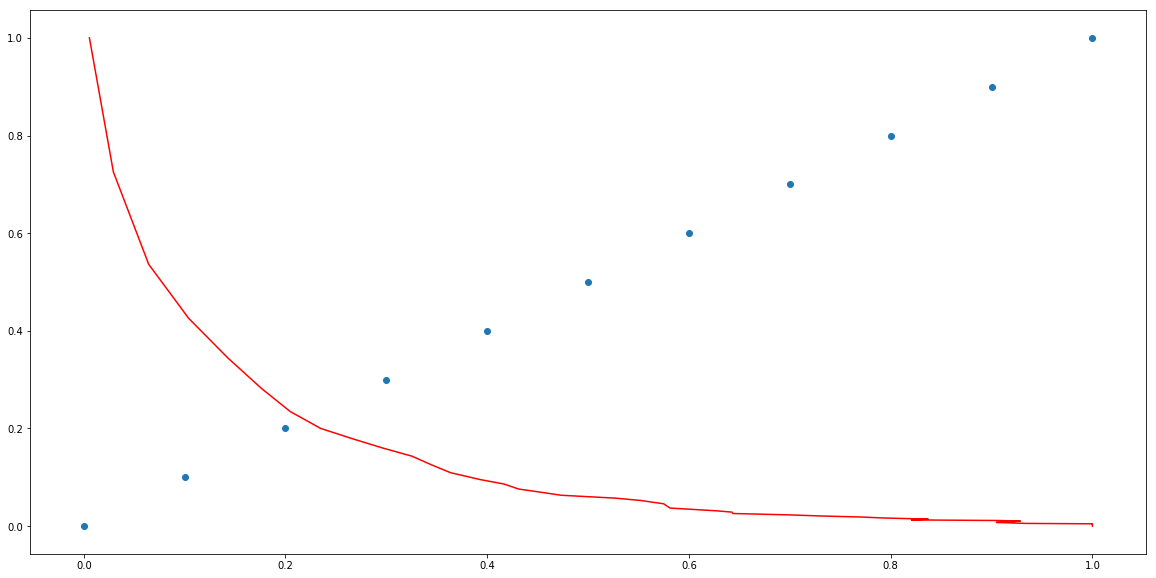

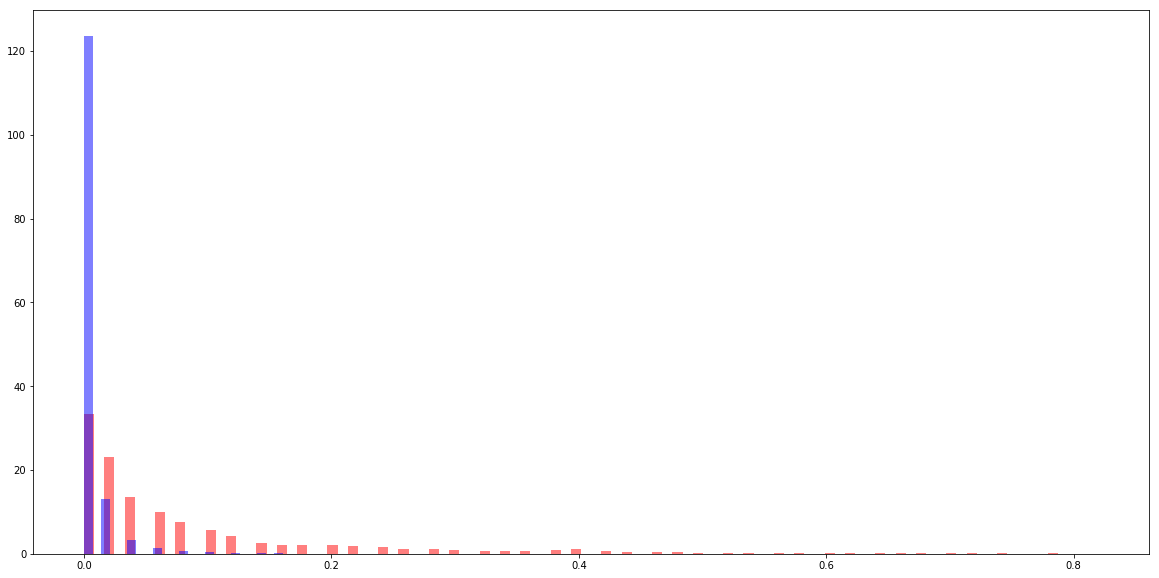

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow_wo_distance//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.04419889502762431


5it [00:02,  2.11it/s]


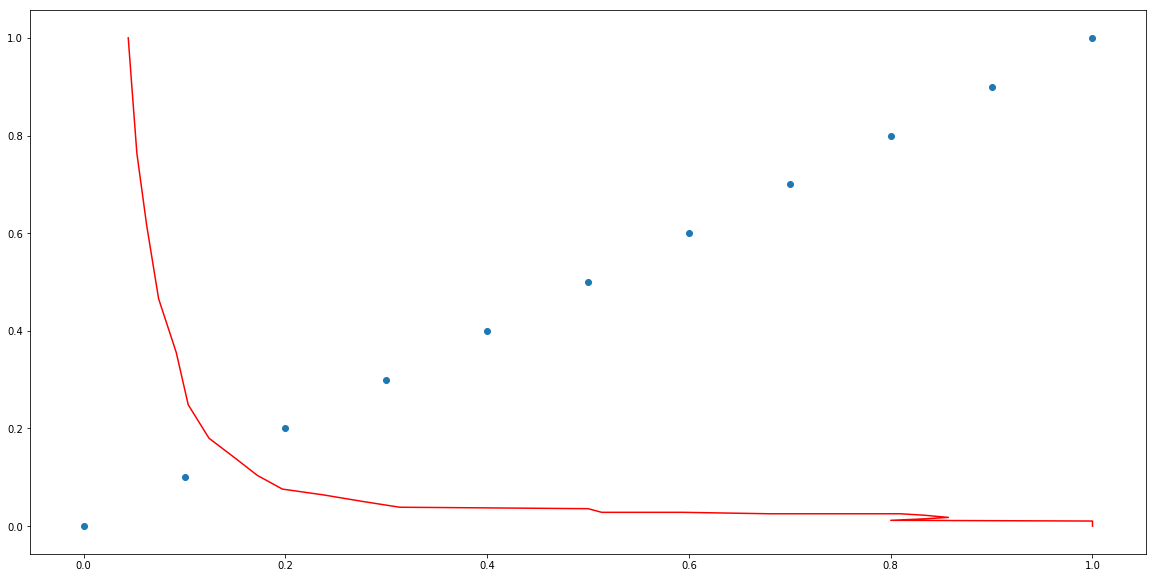

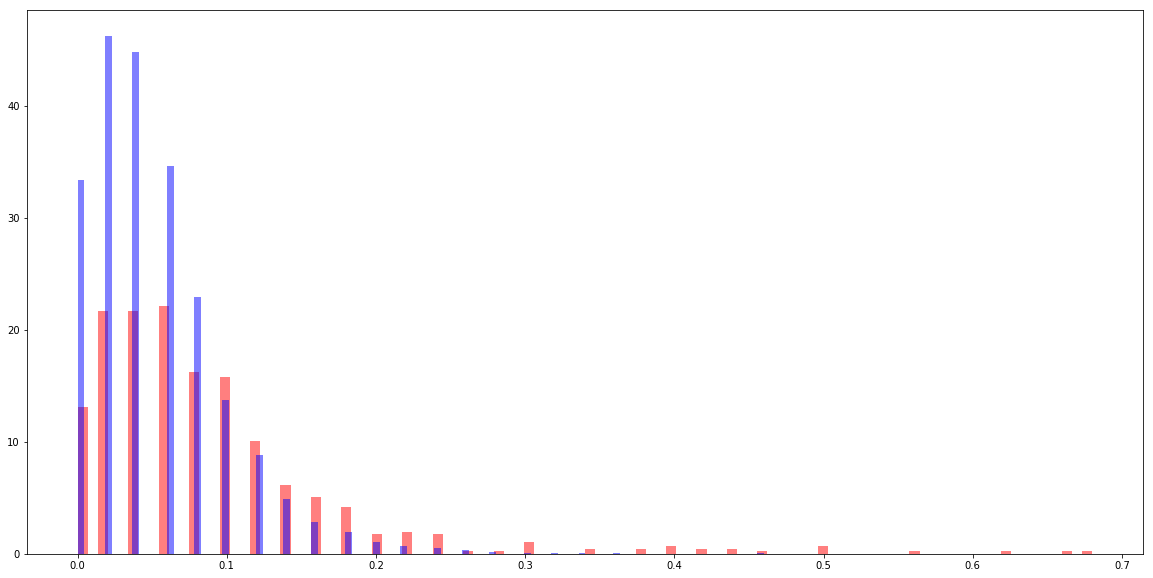

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow_wo_distance//all data stratified
target.mean=0.003705031213881696


5it [02:02, 24.46s/it]


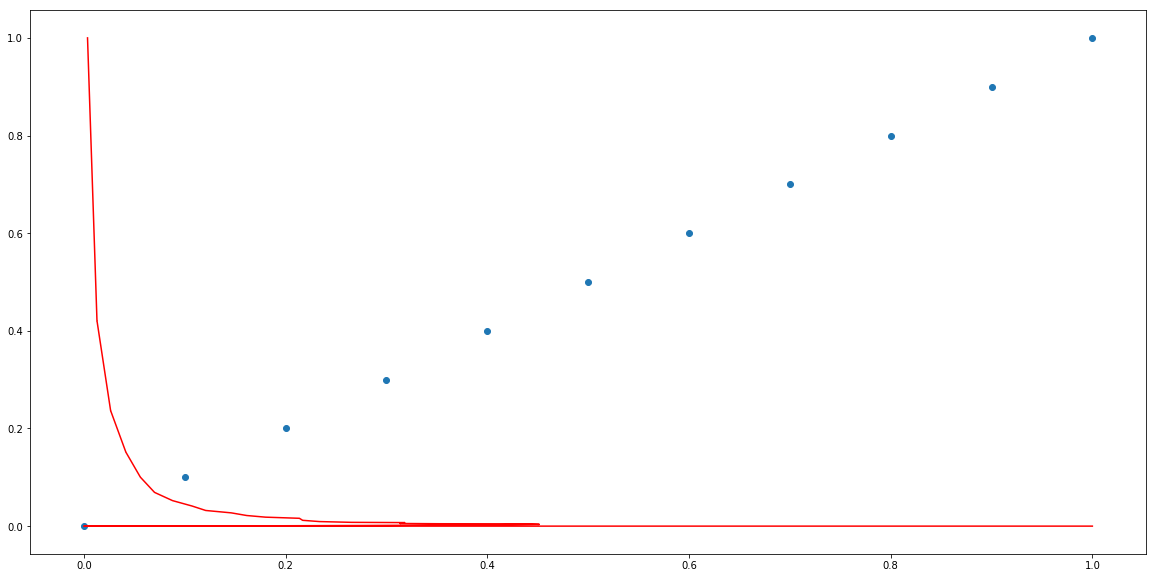

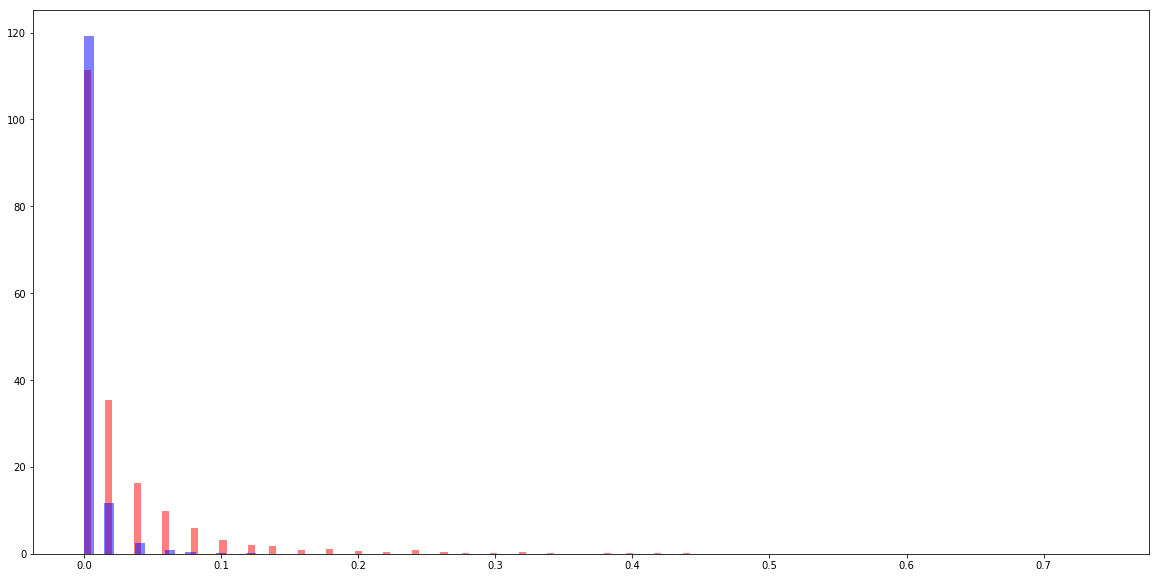

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow_wo_distance//stratified pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.04419889502762431


5it [00:02,  2.12it/s]


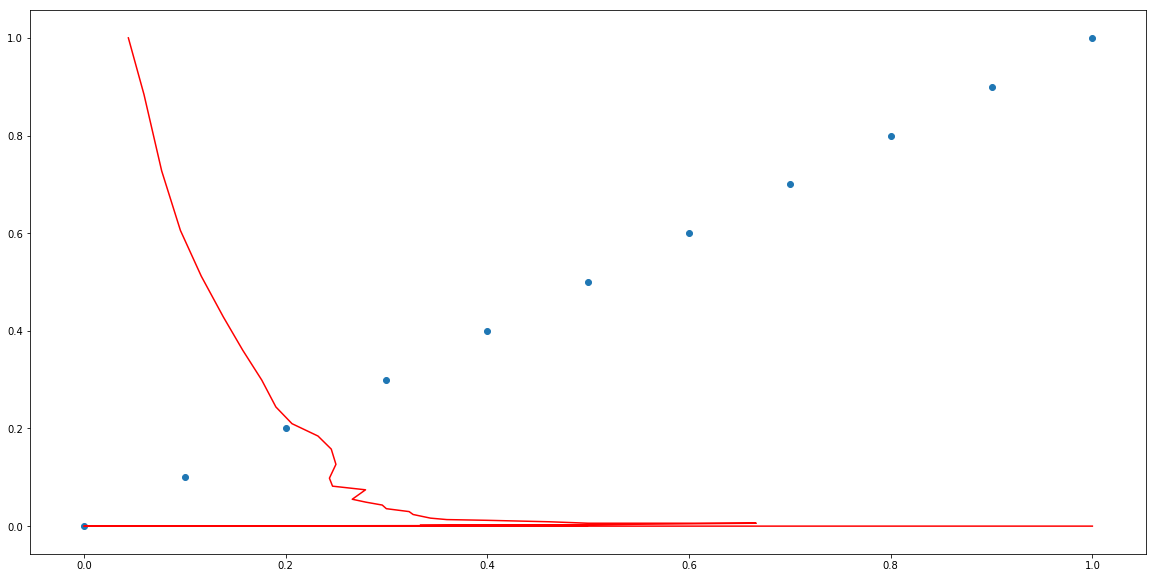

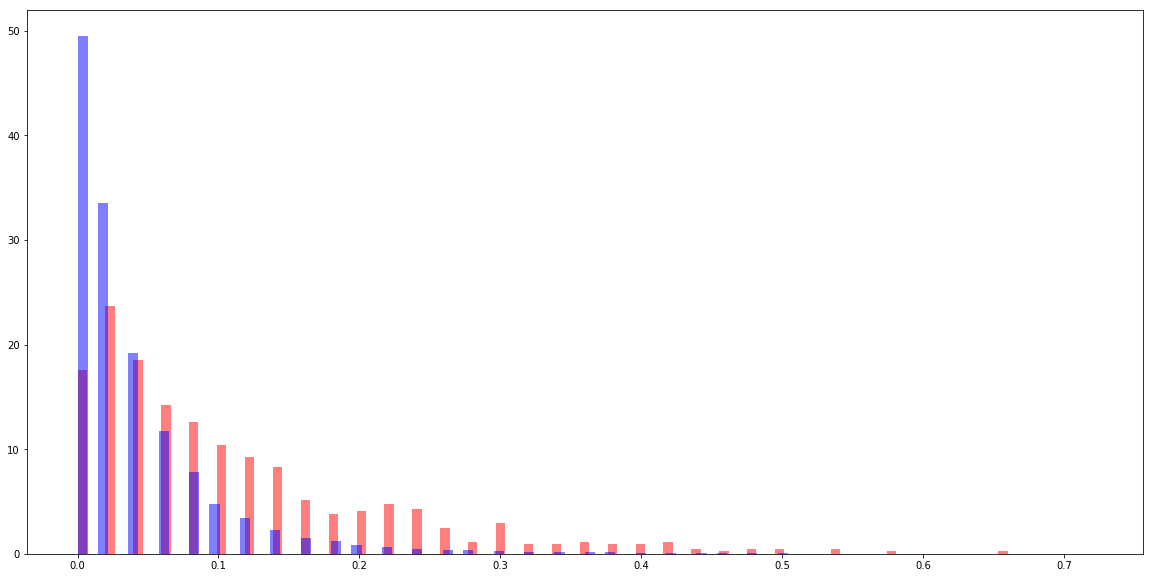

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow_wo_distance//cross chain short -> long
target.mean=0.003705031213881696


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


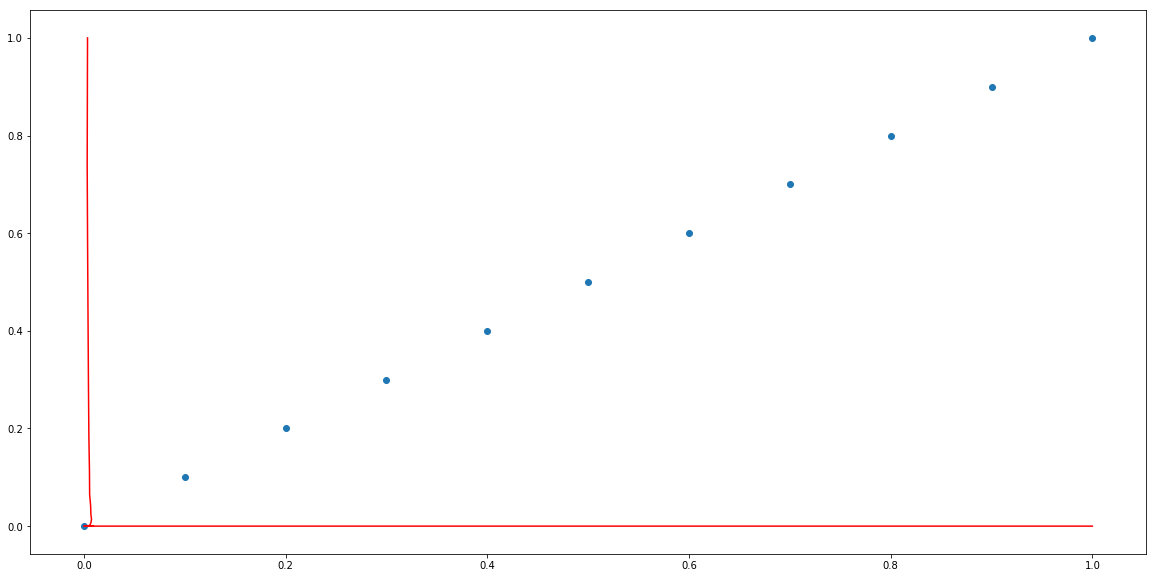

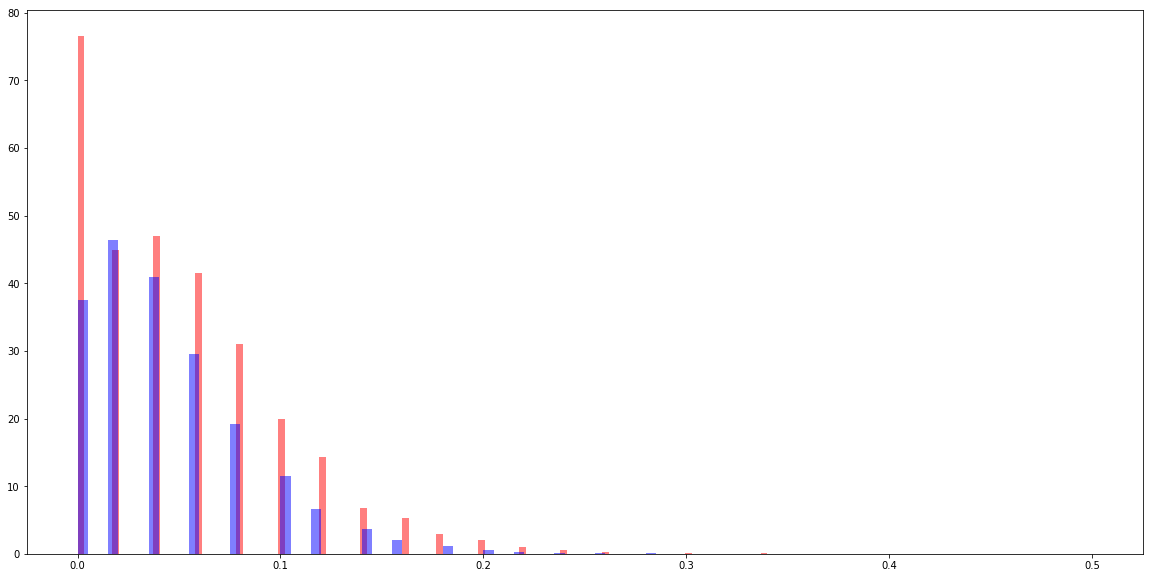

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow_wo_distance//cross chain long -> short
target.mean=0.003705031213881696


100%|██████████| 1/1 [00:31<00:00, 31.37s/it]


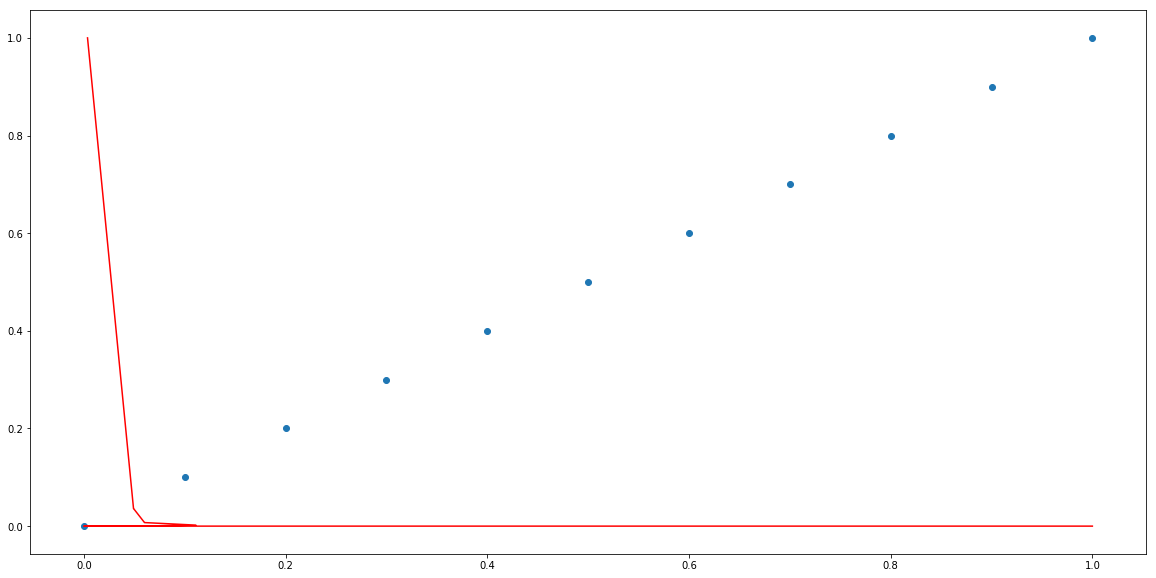

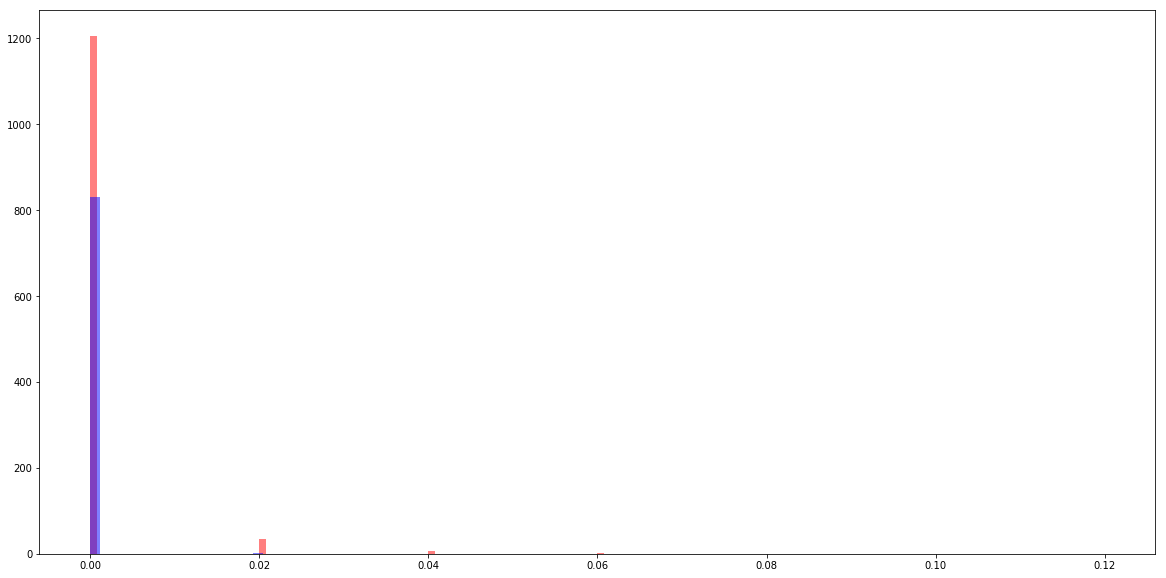

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow_wo_distance//chain pair experiment for chains 4y4o_1a, 6qzp_S2
target.mean=0.004850392167995523


100%|██████████| 2/2 [00:05<00:00,  2.54s/it]


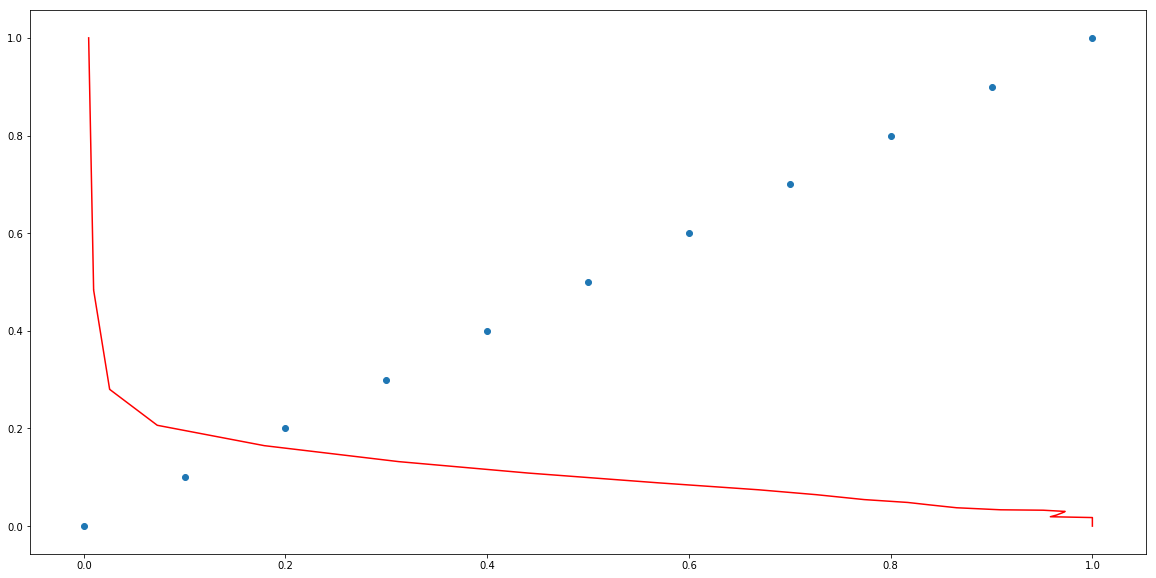

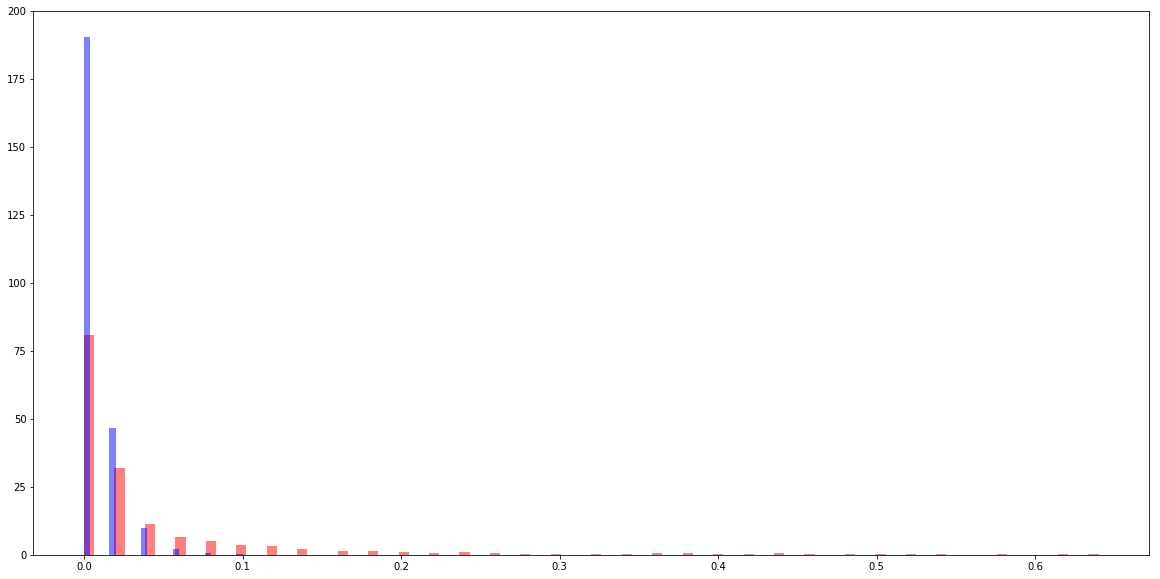

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow_wo_distance//chain pair experiment for chains 4y4o_2A, 6qzp_L5
target.mean=0.002537693723437524


100%|██████████| 2/2 [00:19<00:00,  9.63s/it]


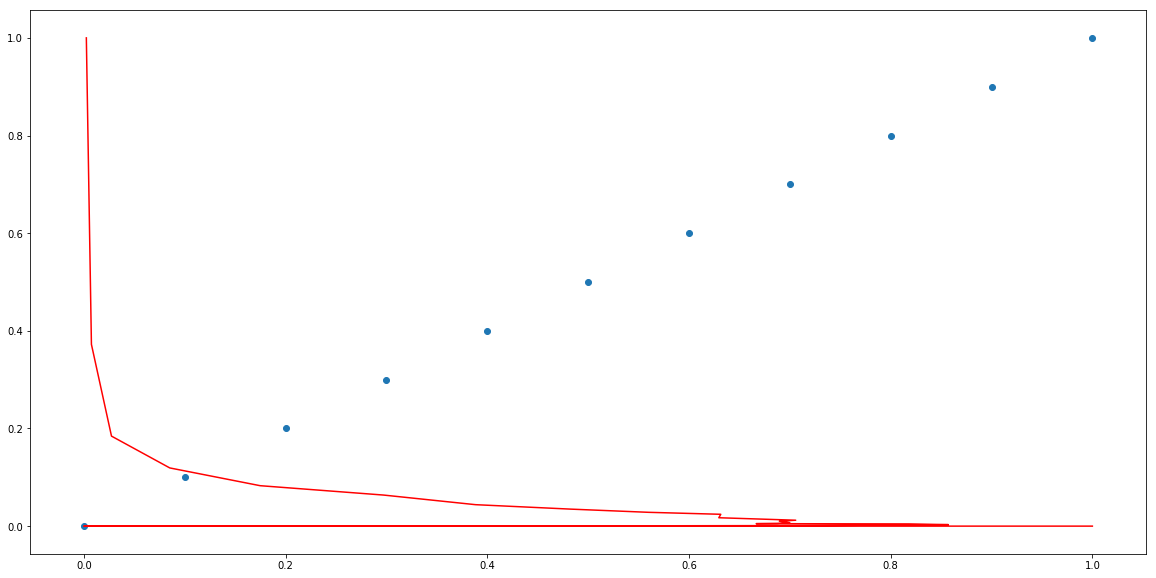

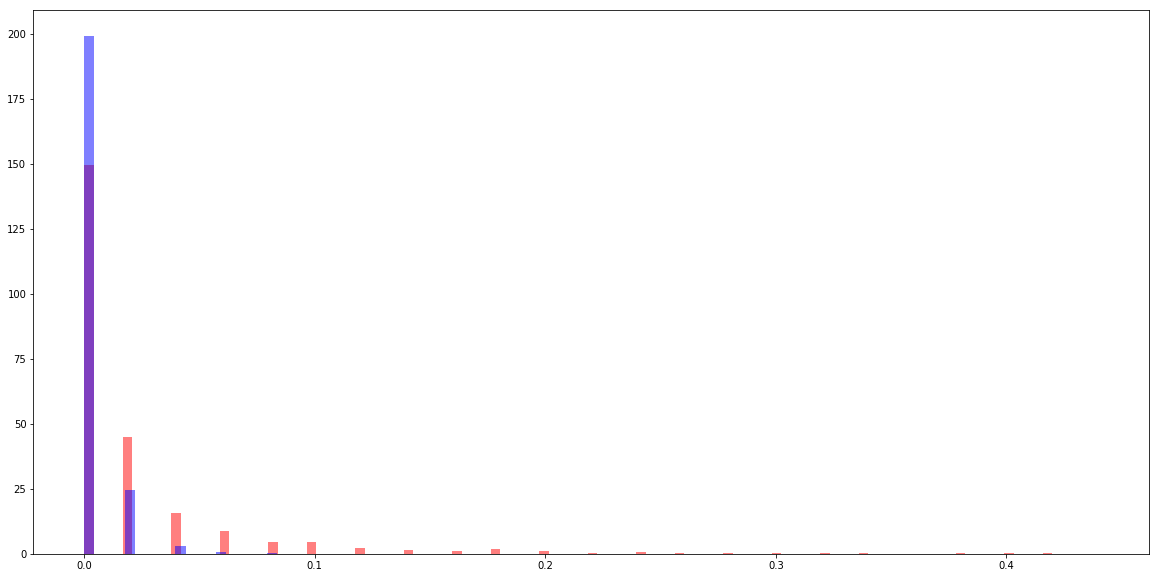

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow_wo_distance//chain experiment for chain 4y4o_1a
target.mean=0.00549666977010671


5it [00:08,  1.76s/it]


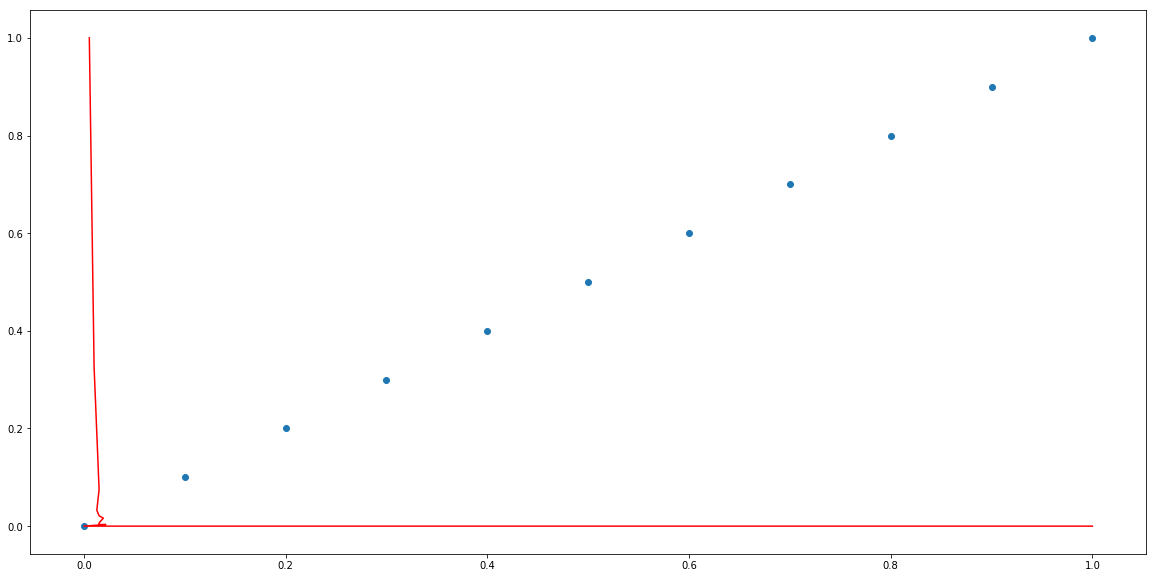

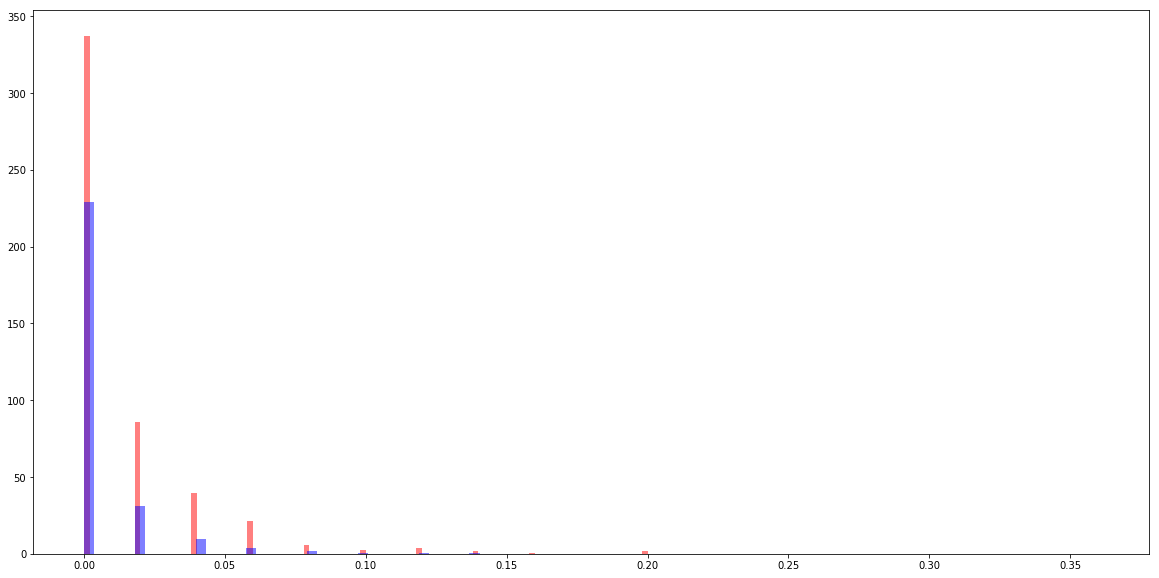

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow_wo_distance//chain experiment for chain 6qzp_S2
target.mean=0.004315138573779973


5it [00:10,  2.03s/it]


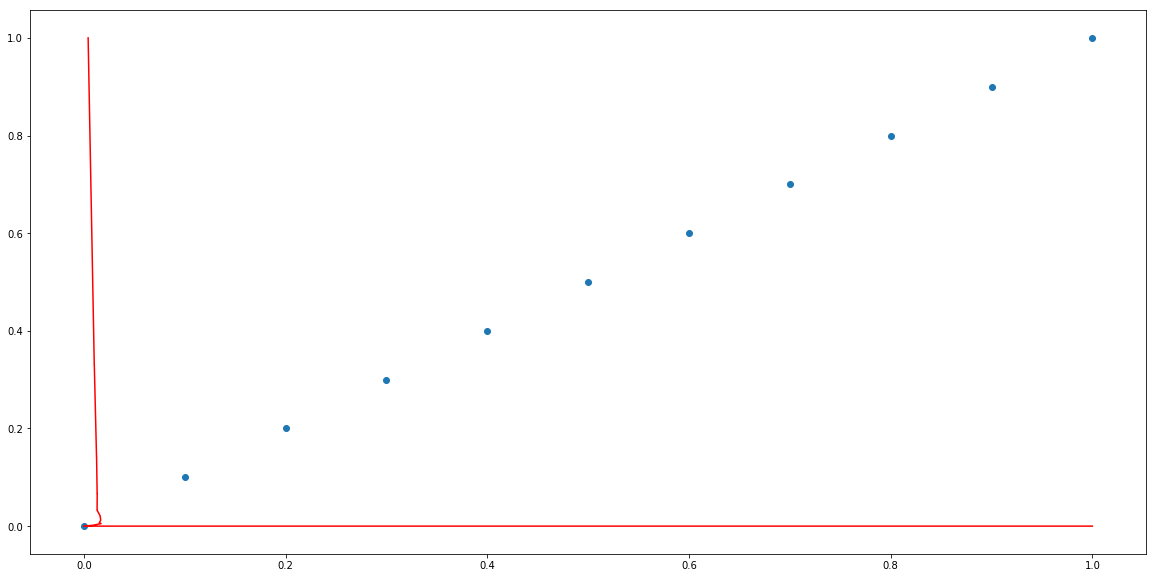

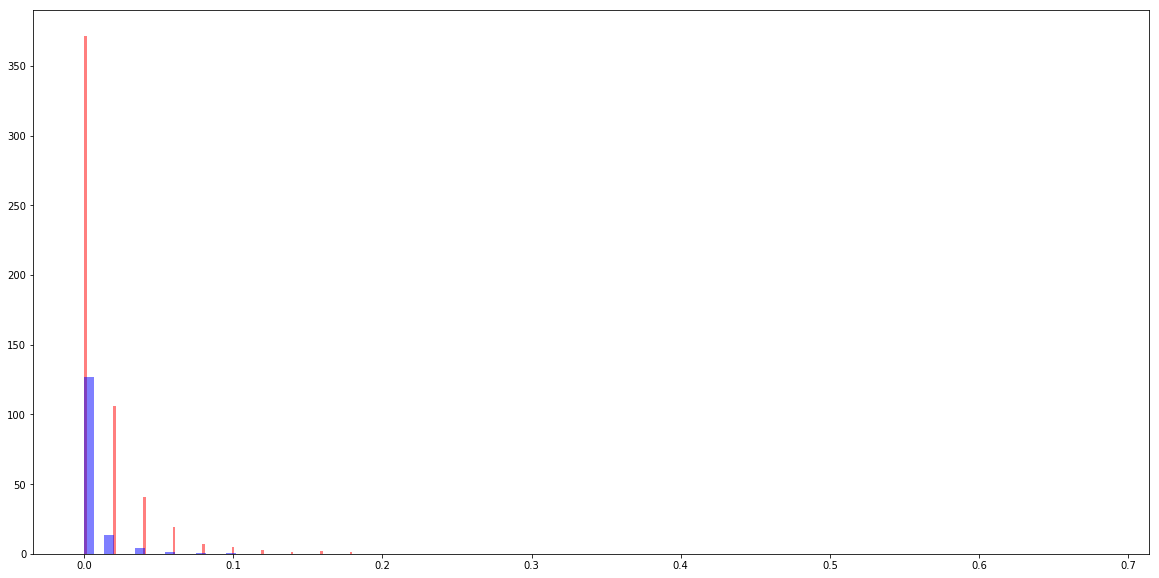

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow_wo_distance//chain experiment for chain 4y4o_2A
target.mean=0.0030810683453454724


5it [00:30,  6.07s/it]


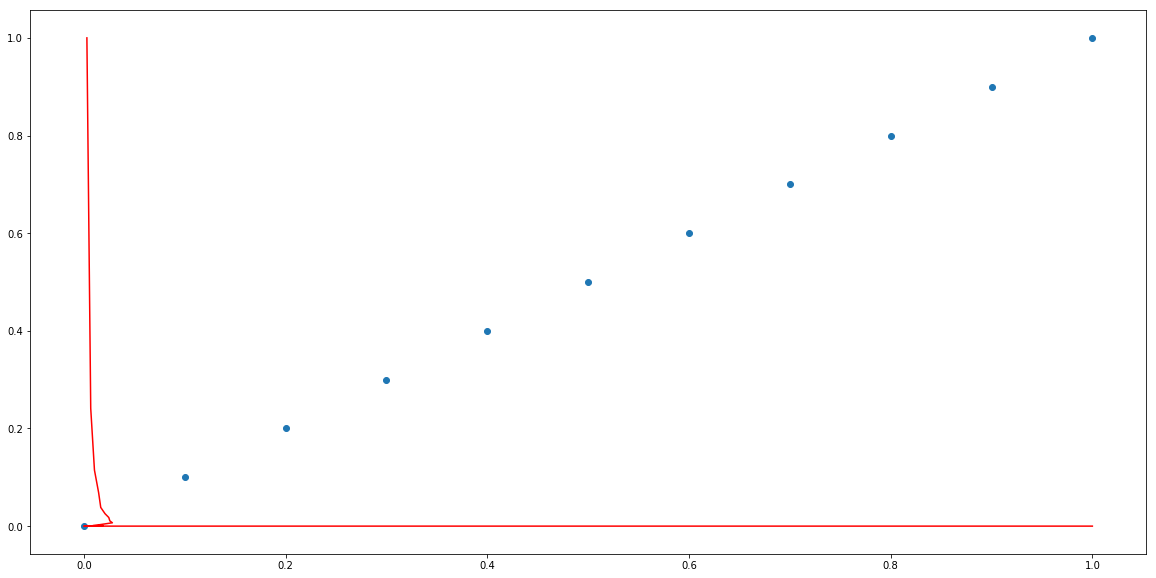

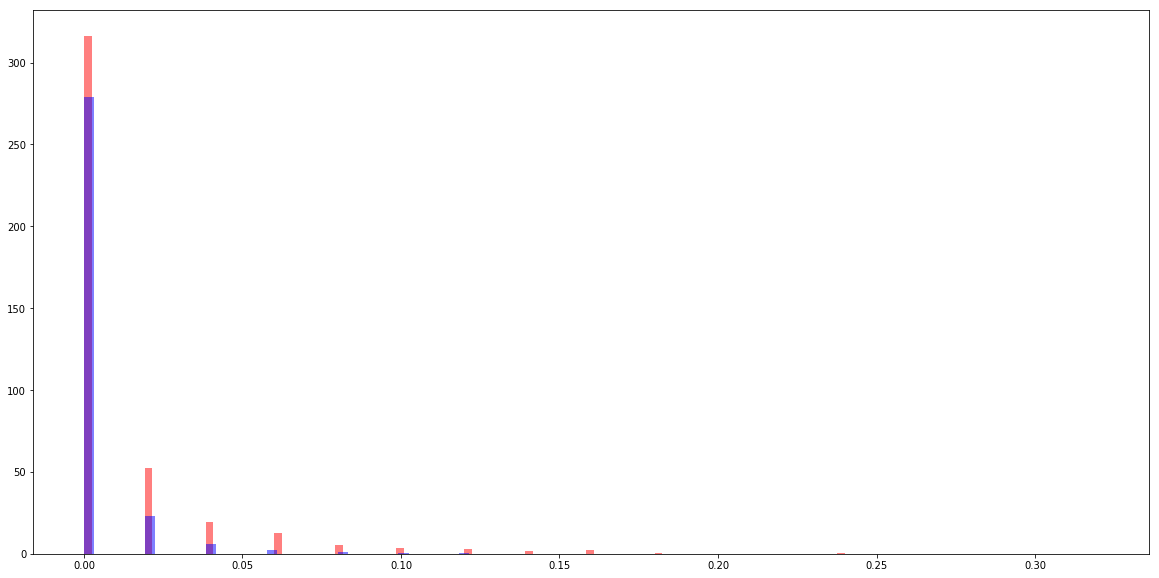

0it [00:00, ?it/s]

Experiment flt=10.fsdt=4.dt=4.nn=1.es=bow_wo_distance//chain experiment for chain 6qzp_L5
target.mean=0.0021372183213040595


5it [00:40,  8.07s/it]


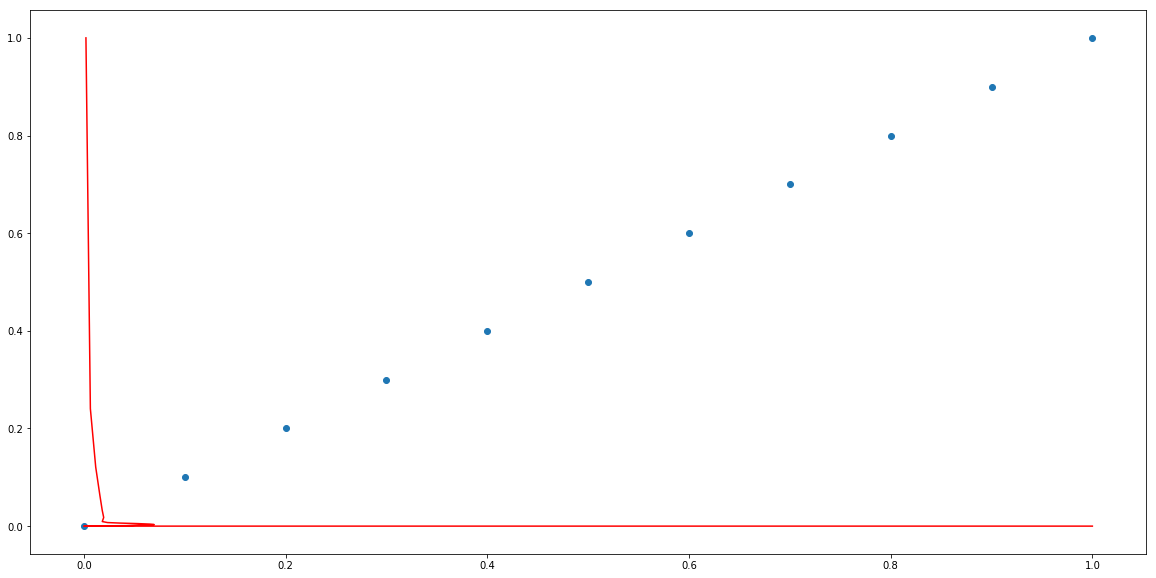

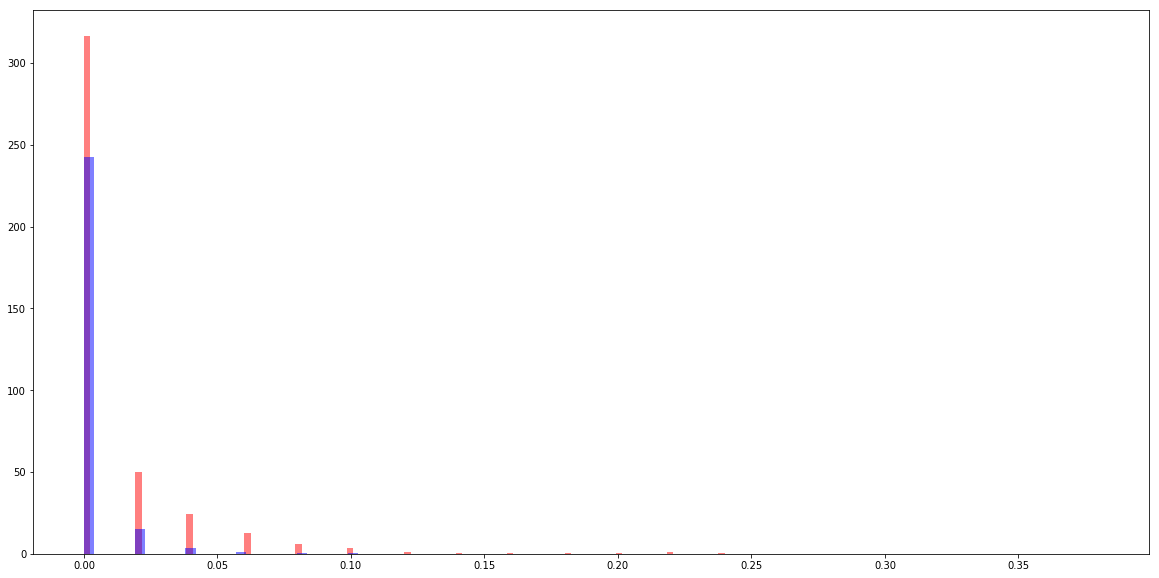

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow_wo_distance//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.10186941208344621


5it [00:02,  2.10it/s]


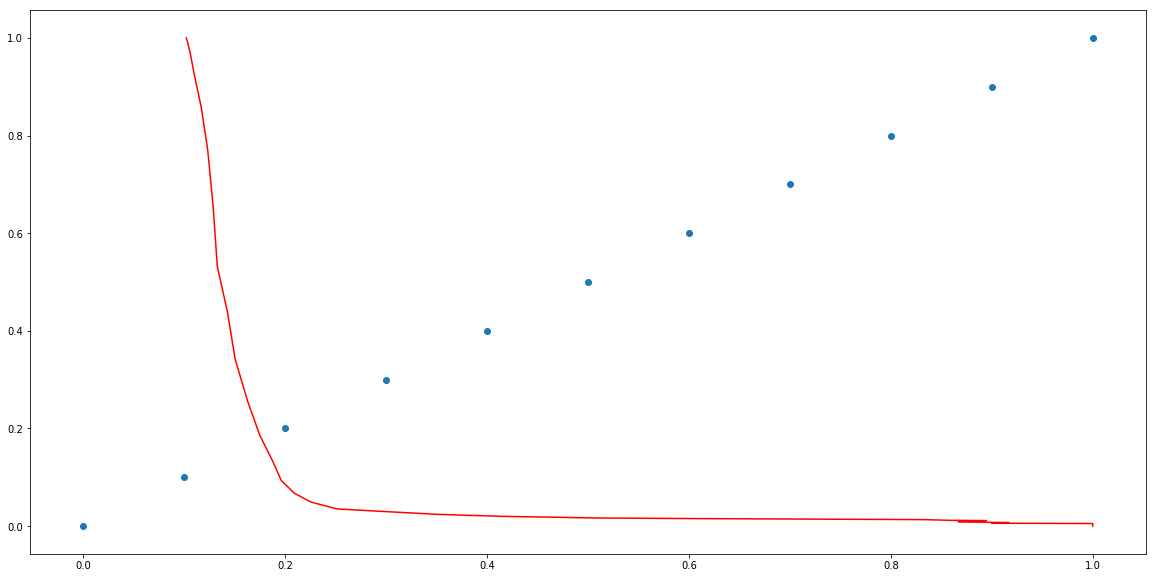

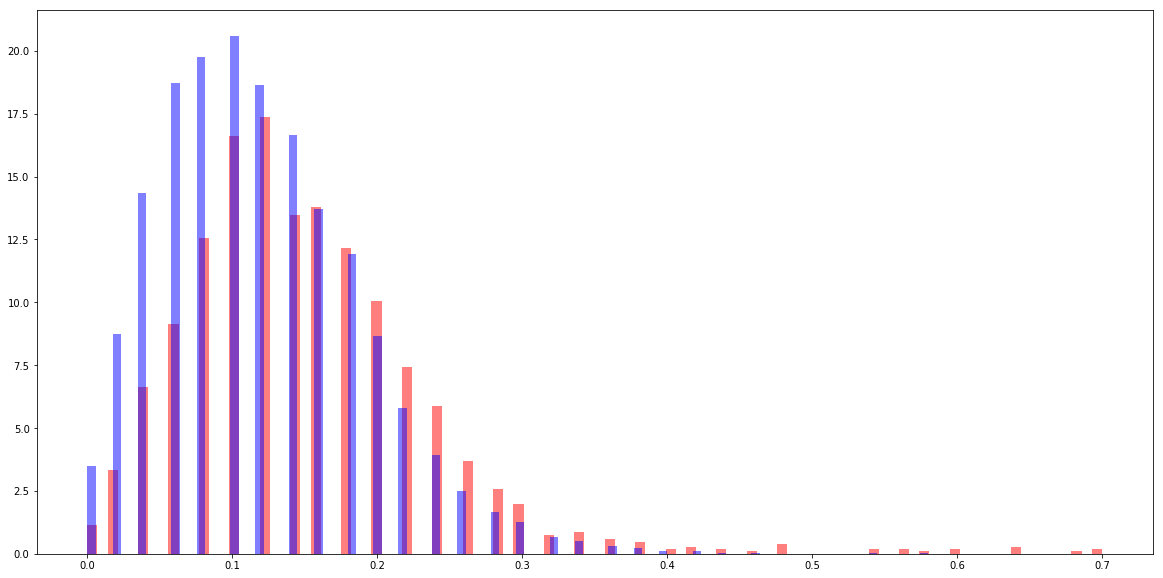

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow_wo_distance//all data stratified
target.mean=0.009263313973141575


5it [02:13, 26.78s/it]


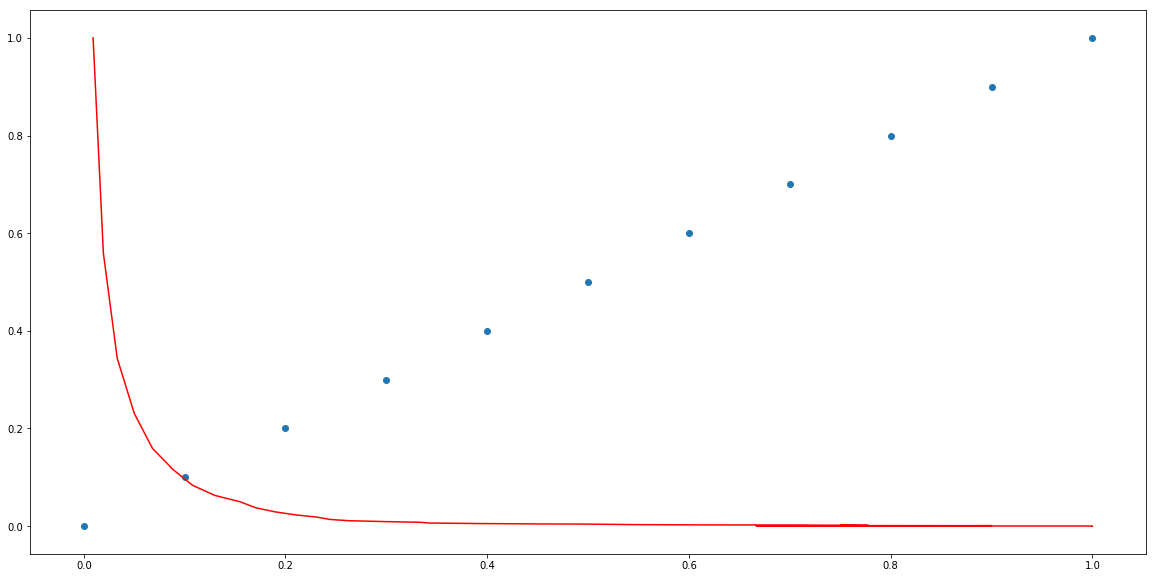

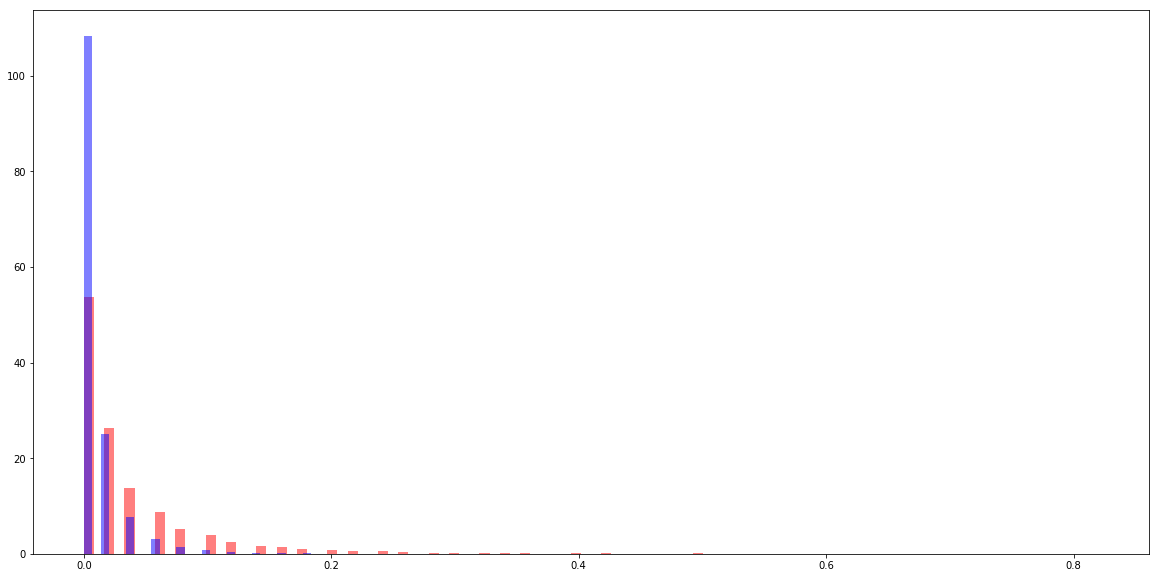

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow_wo_distance//stratified pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.10186941208344621


5it [00:02,  2.10it/s]


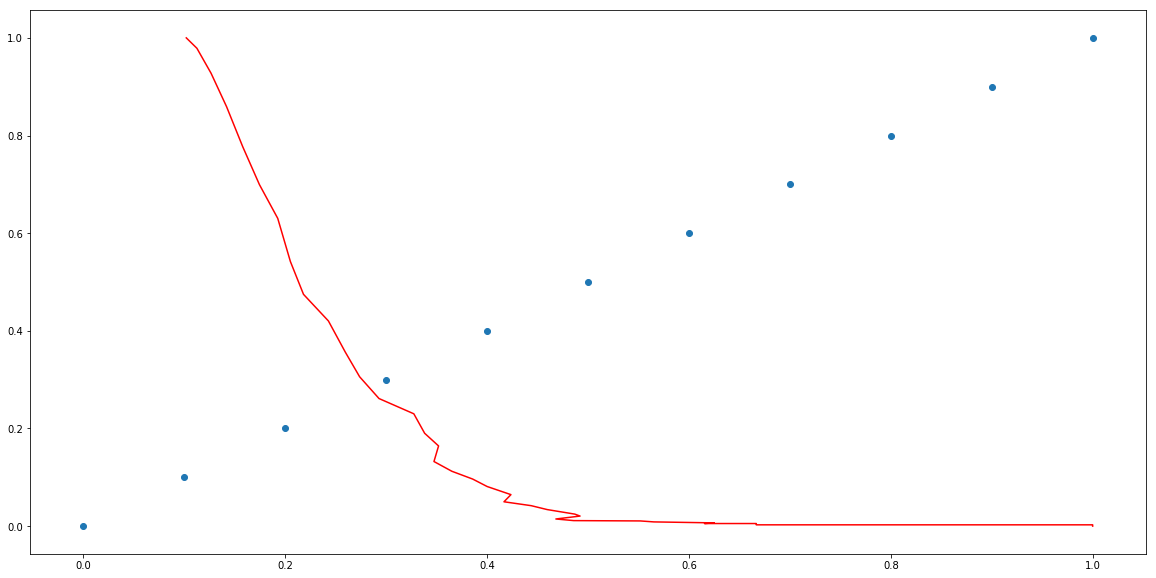

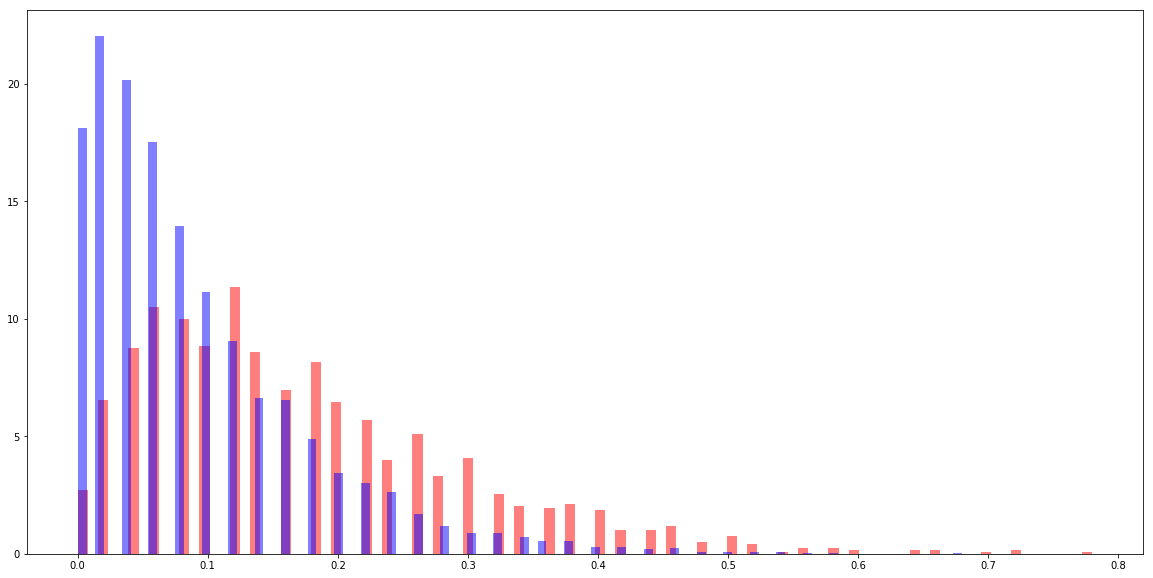

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow_wo_distance//cross chain short -> long
target.mean=0.009263313973141575


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


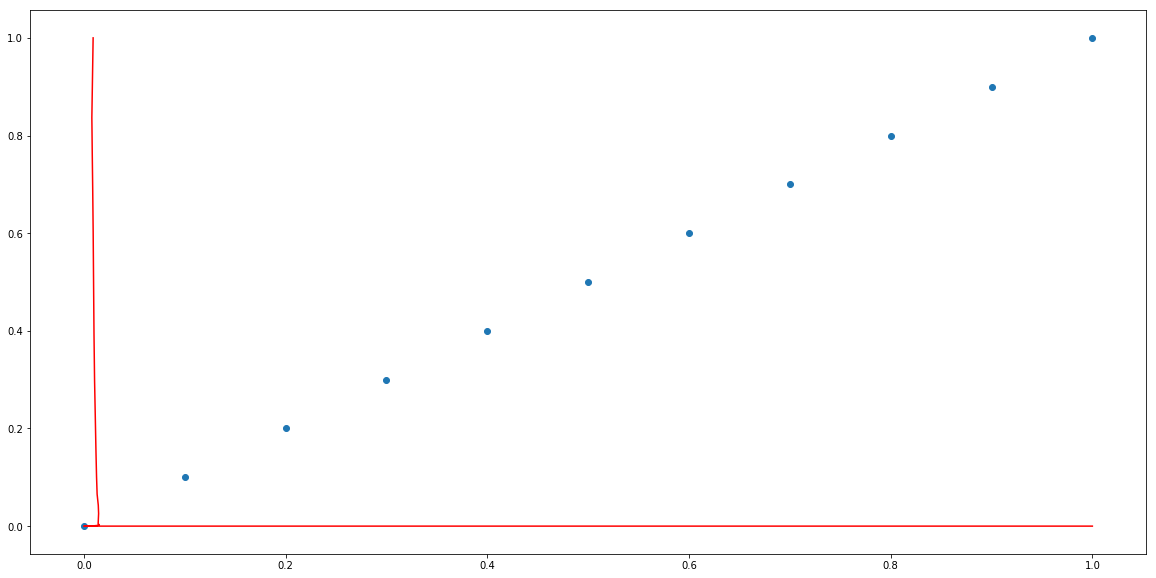

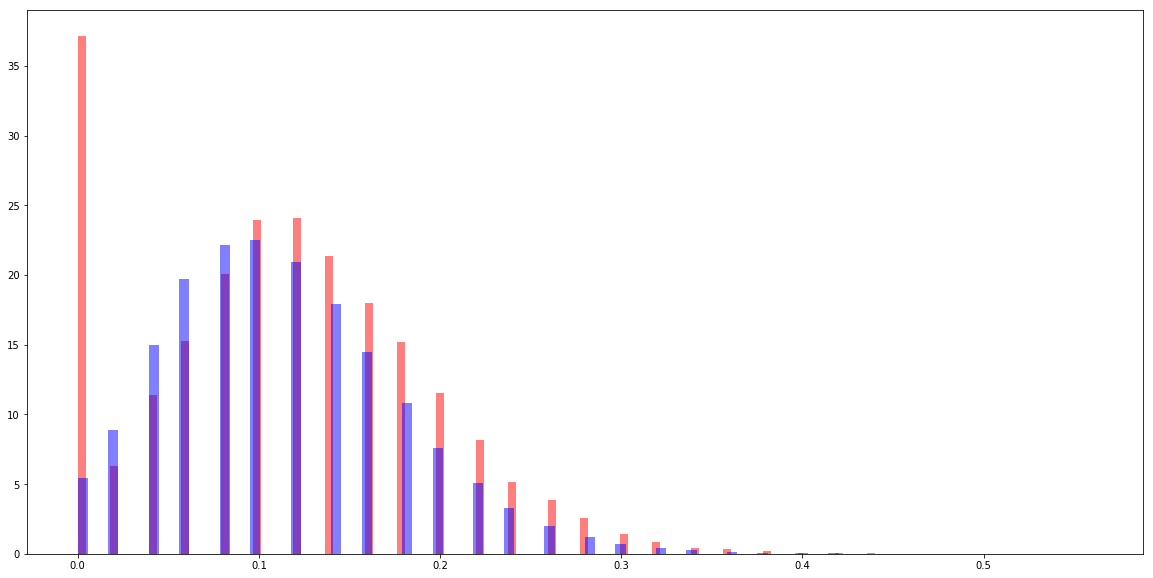

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow_wo_distance//cross chain long -> short
target.mean=0.009263313973141575


100%|██████████| 1/1 [00:33<00:00, 33.38s/it]


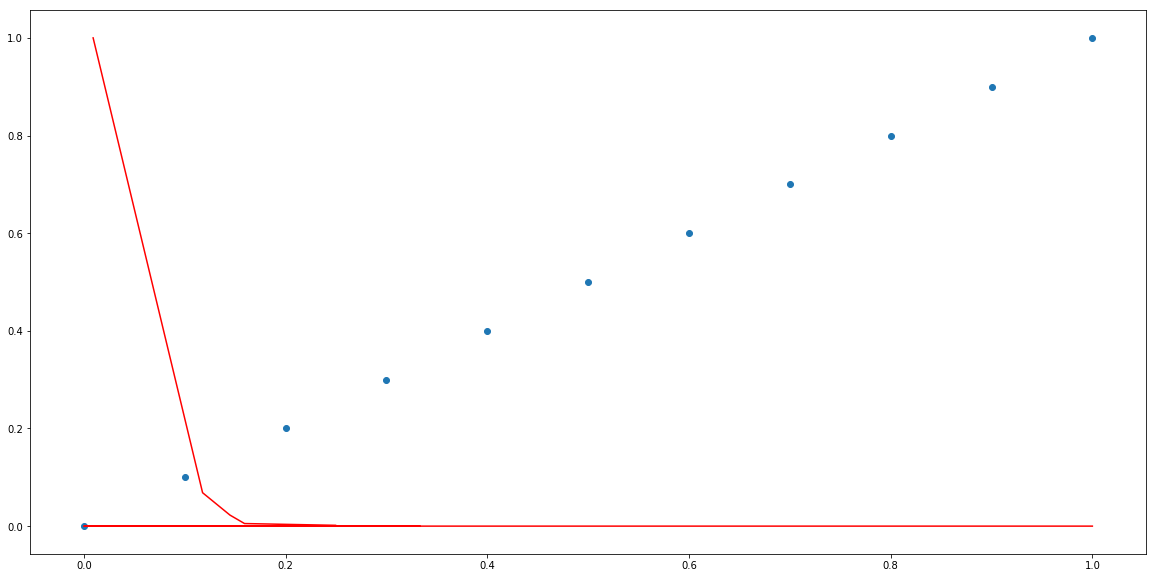

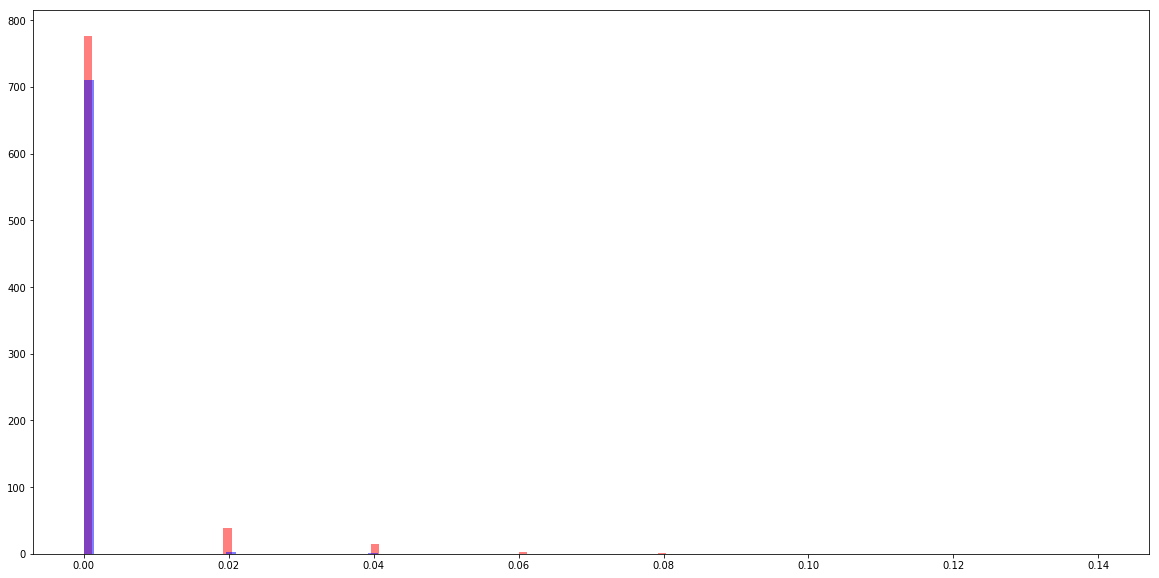

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow_wo_distance//chain pair experiment for chains 4y4o_1a, 6qzp_S2
target.mean=0.012053386253283775


100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


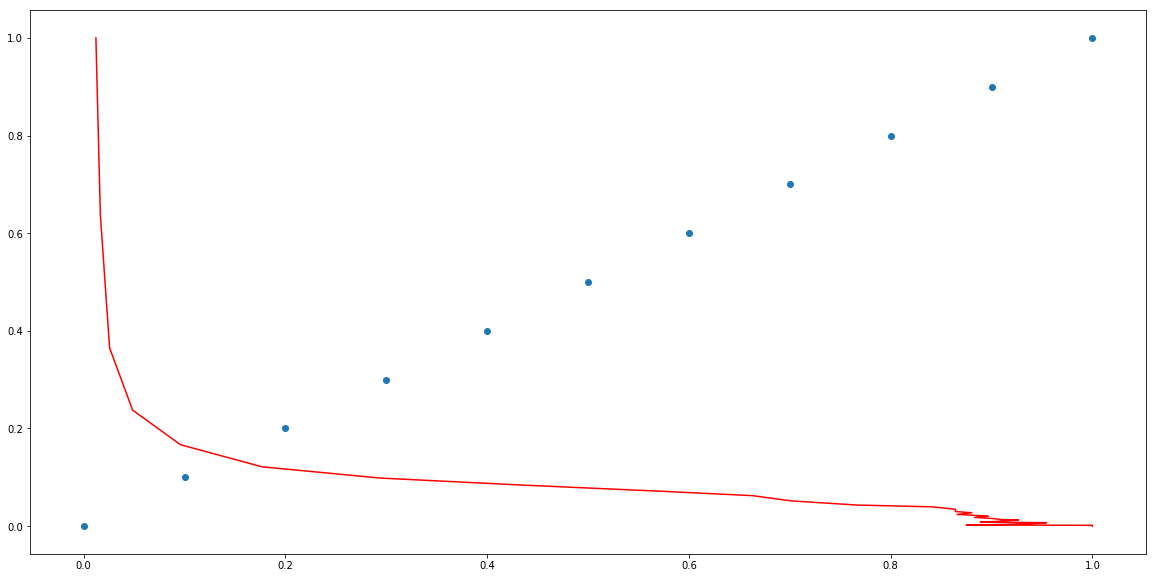

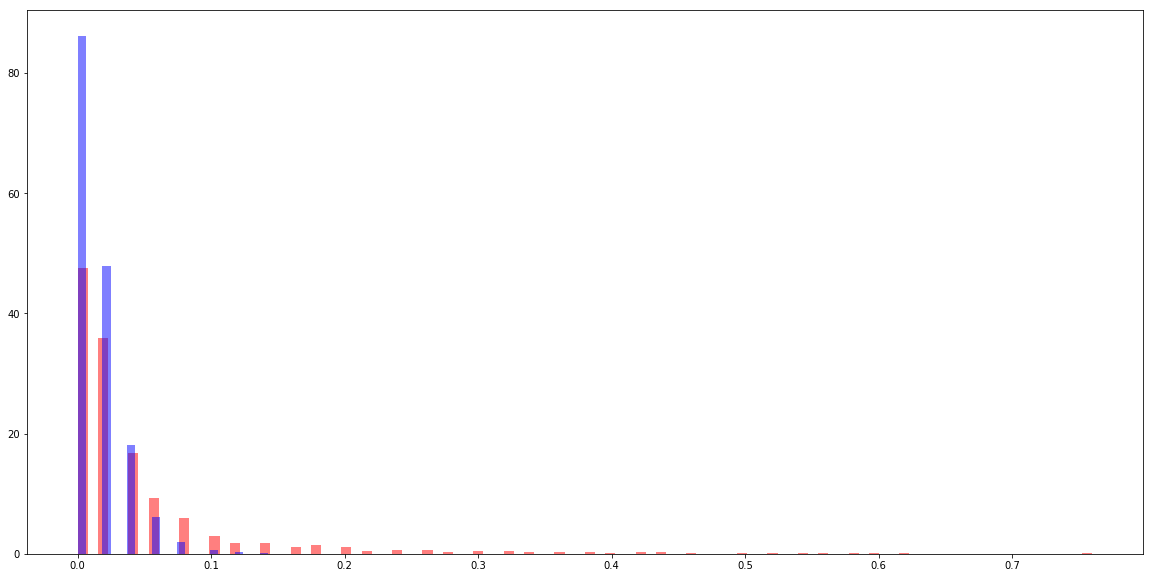

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow_wo_distance//chain pair experiment for chains 4y4o_2A, 6qzp_L5
target.mean=0.006552370197366732


100%|██████████| 2/2 [00:20<00:00, 10.46s/it]


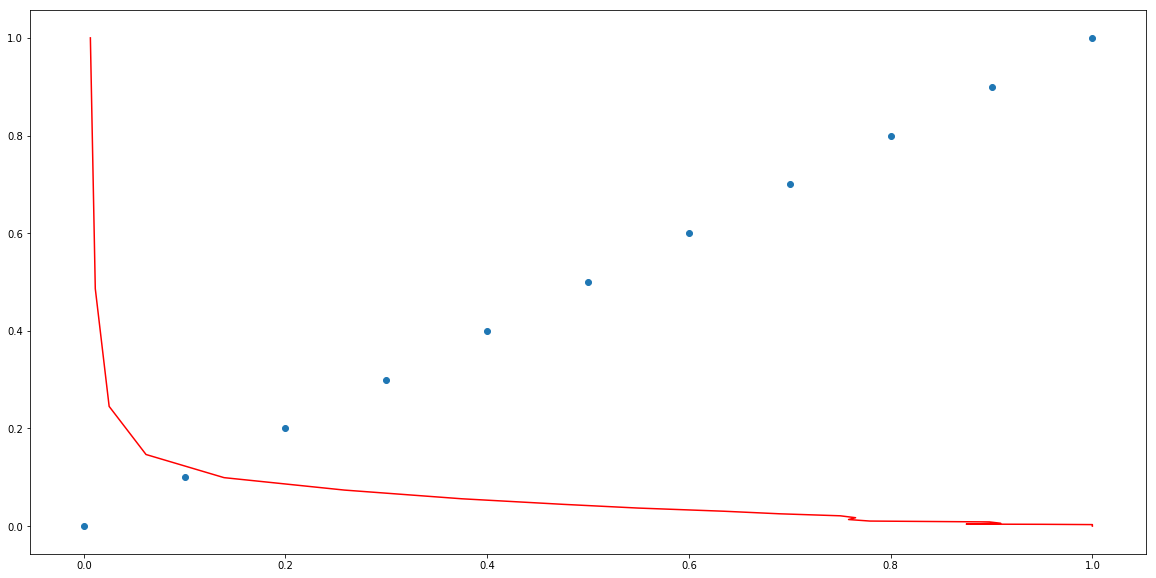

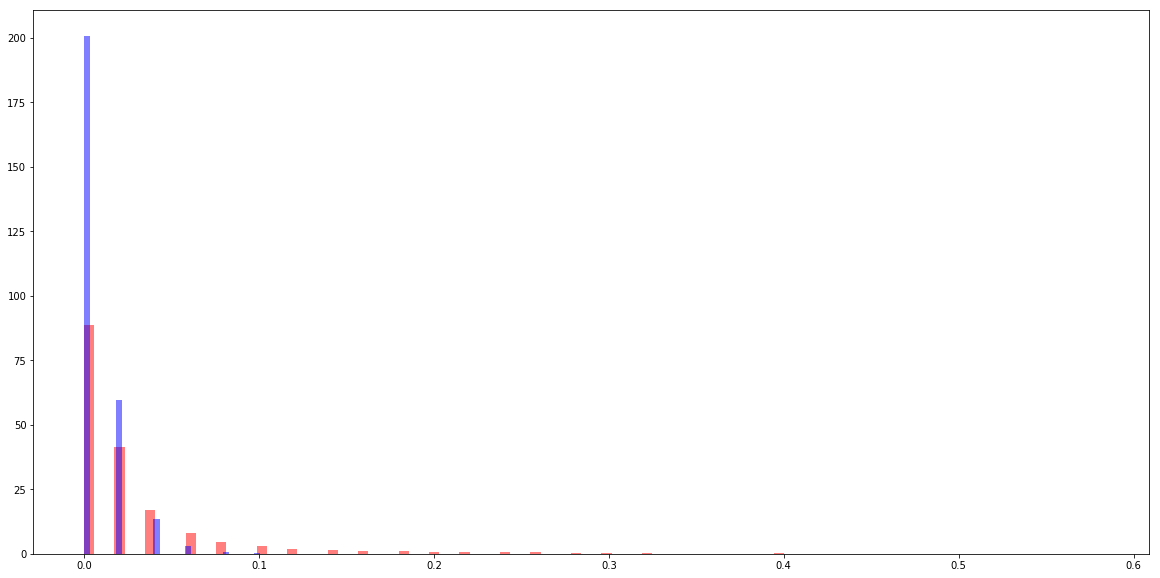

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow_wo_distance//chain experiment for chain 4y4o_1a
target.mean=0.013284265326272327


5it [00:08,  1.72s/it]


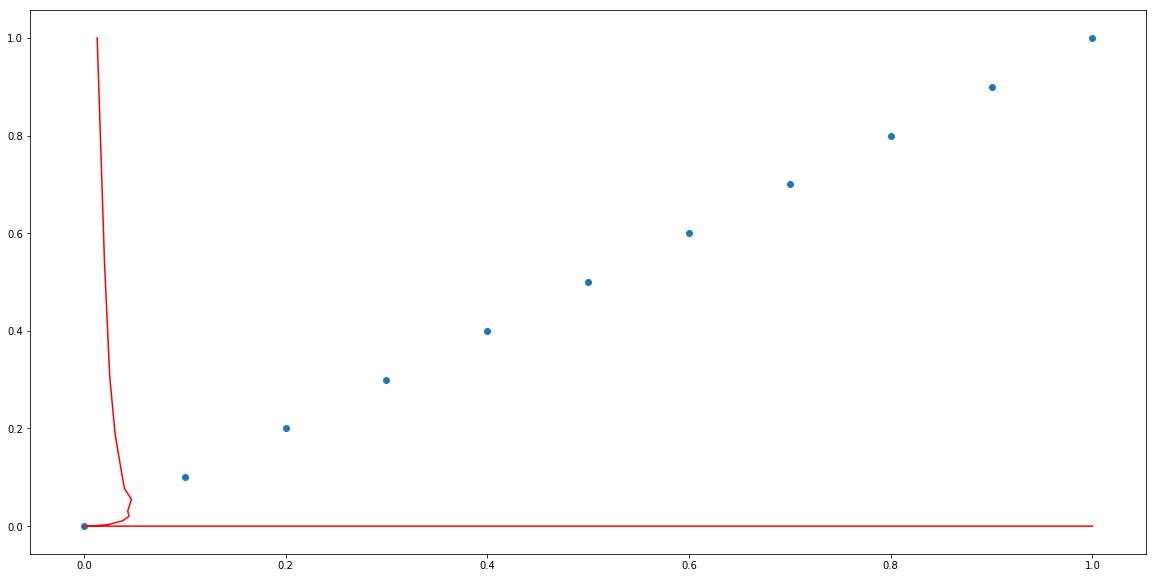

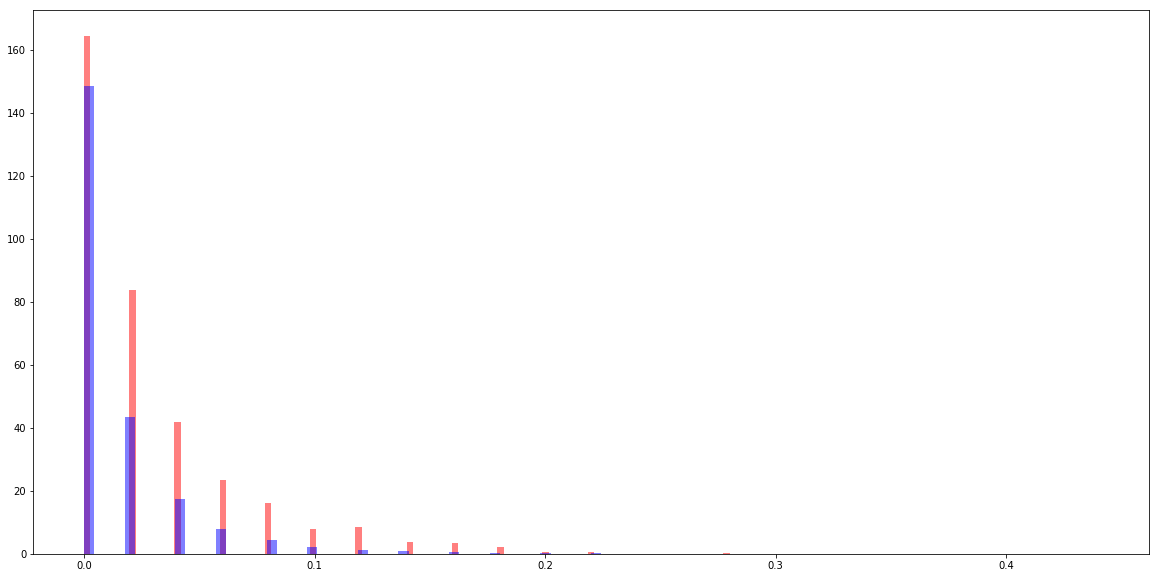

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow_wo_distance//chain experiment for chain 6qzp_S2
target.mean=0.011033785391387104


5it [00:11,  2.29s/it]


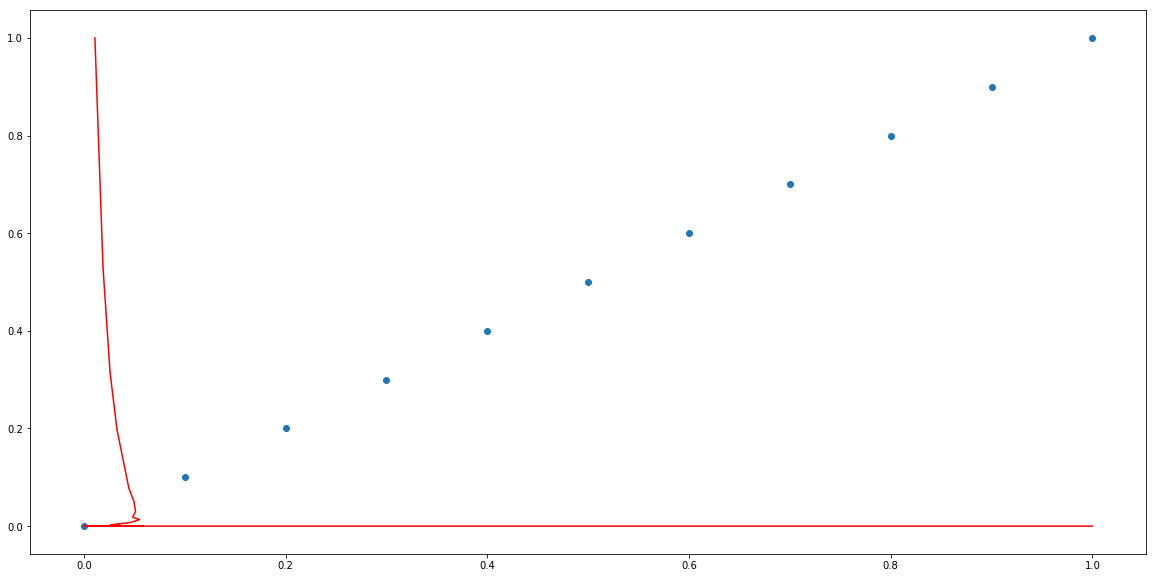

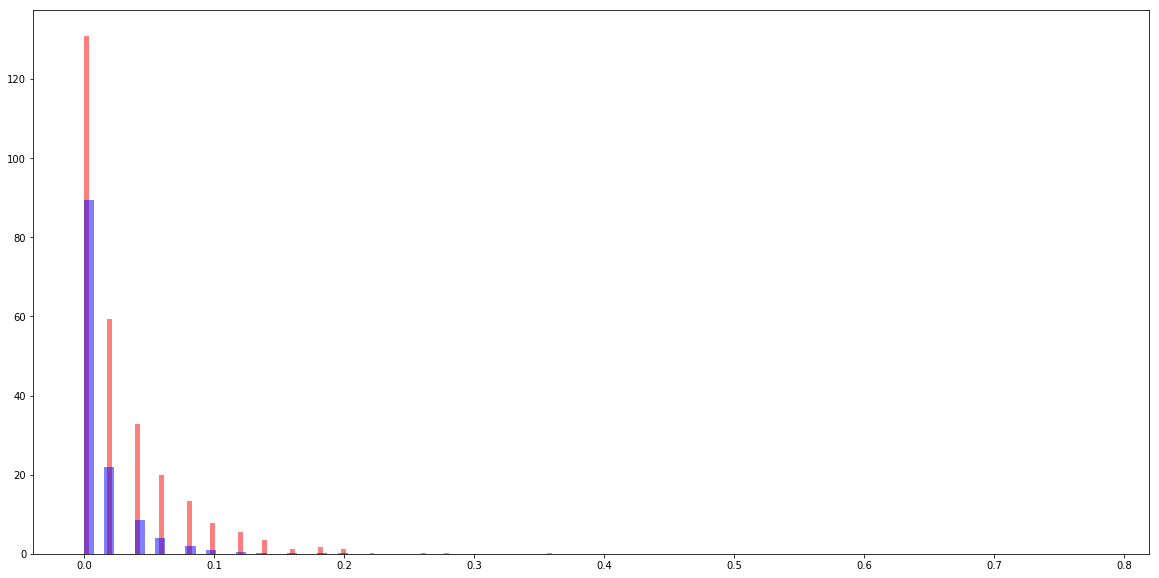

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow_wo_distance//chain experiment for chain 4y4o_2A
target.mean=0.007840053234929372


5it [00:32,  6.55s/it]


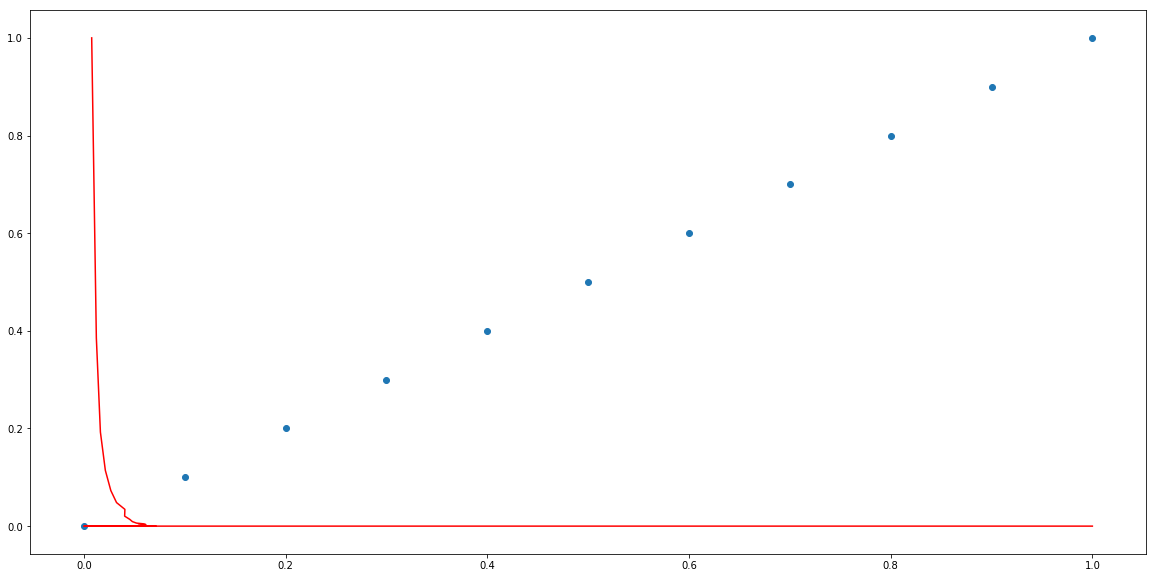

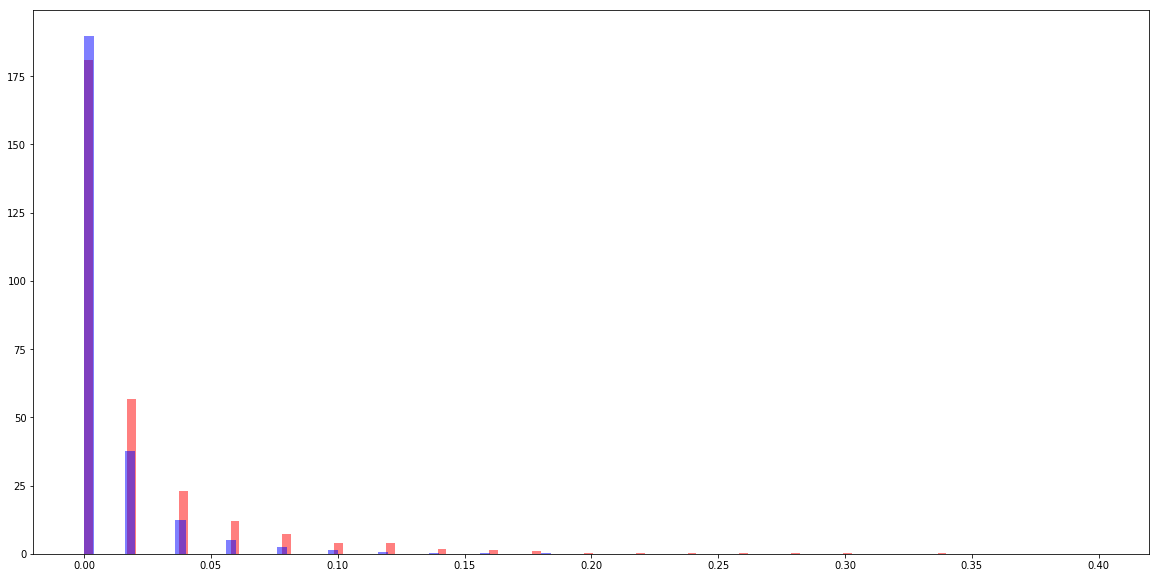

0it [00:00, ?it/s]

Experiment flt=10.fsdt=6.dt=8.nn=1.es=bow_wo_distance//chain experiment for chain 6qzp_L5
target.mean=0.0056034770979605485


5it [00:47,  9.48s/it]


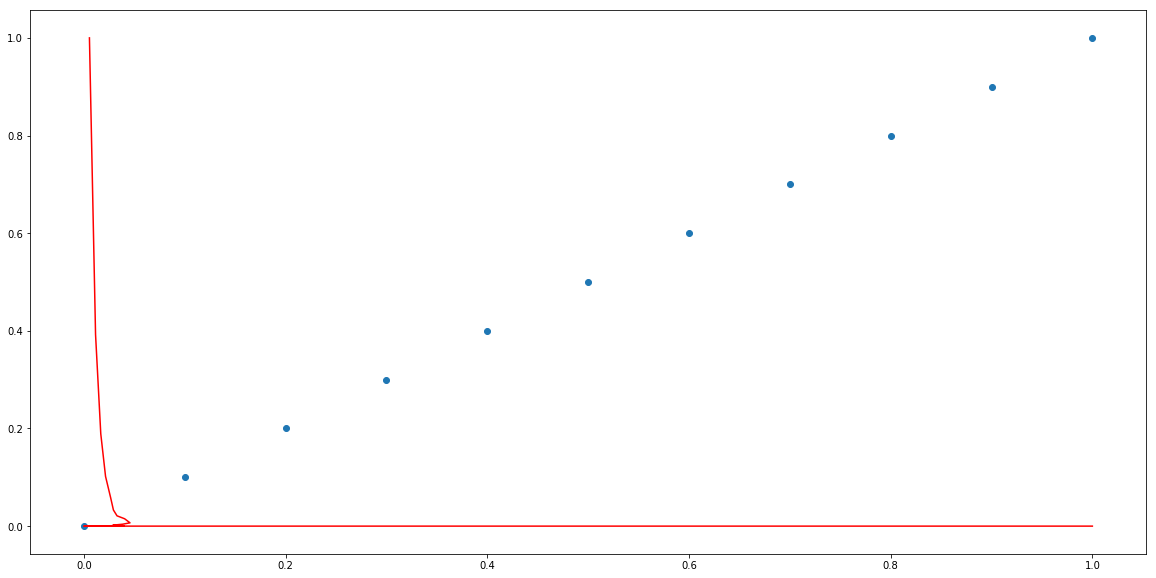

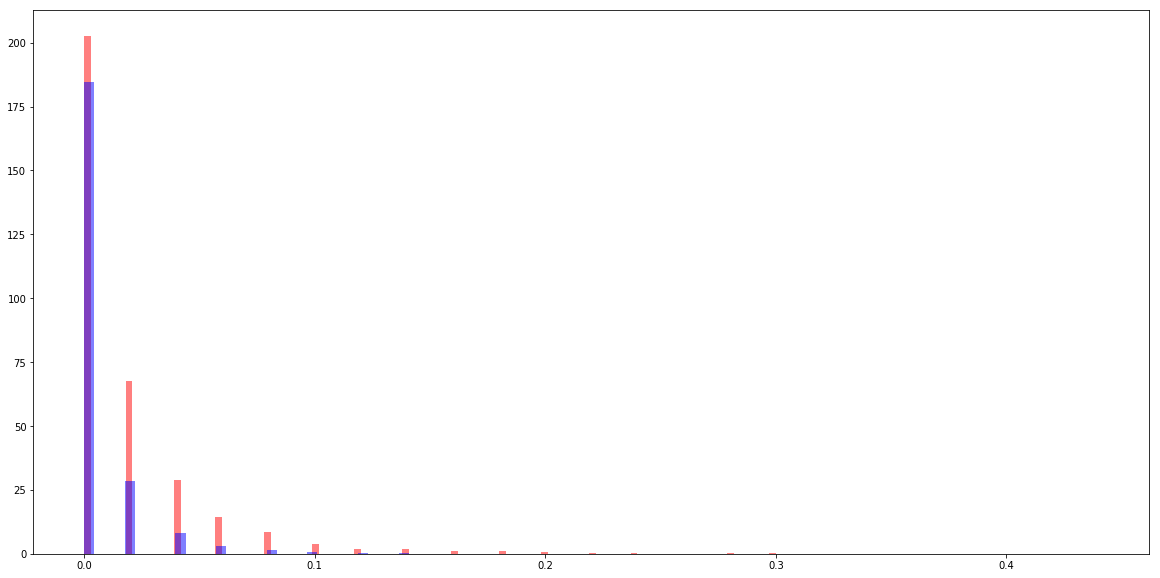

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow//pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.1683381088825215


5it [00:02,  2.03it/s]


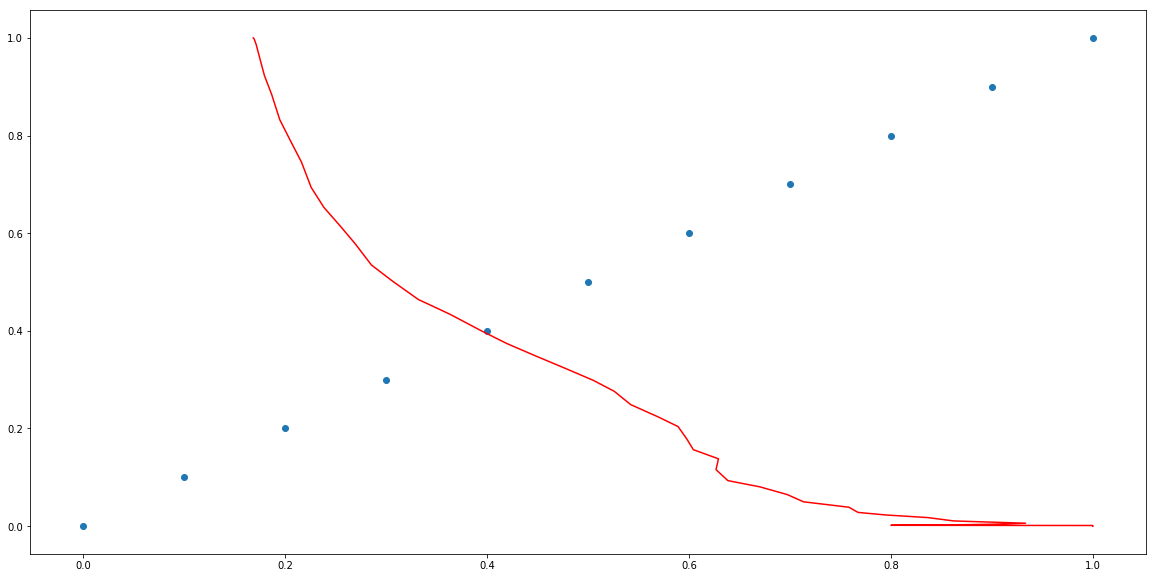

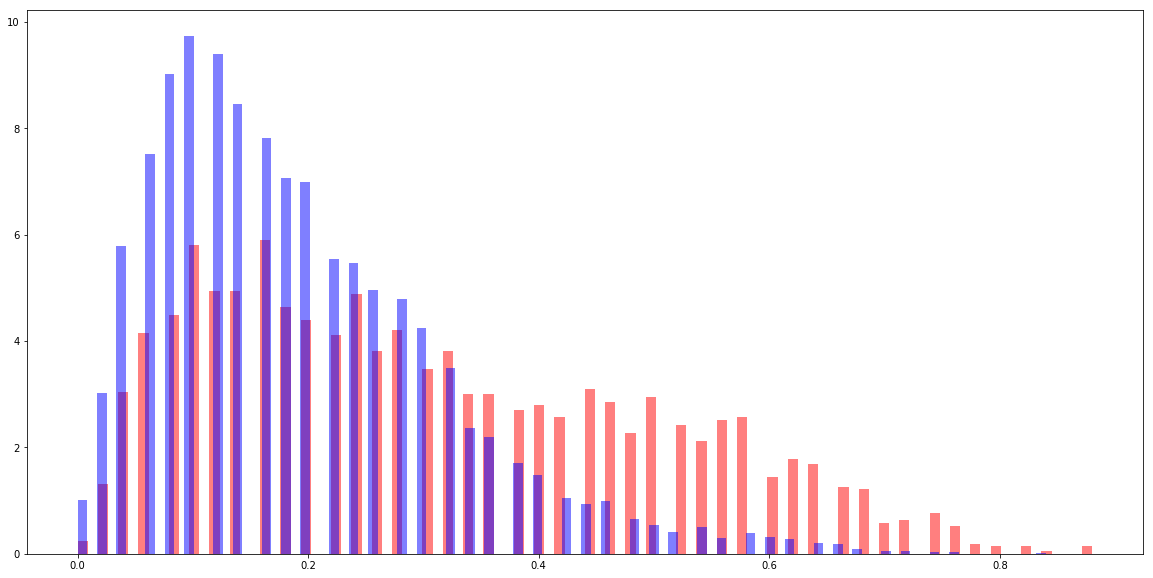

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow//all data stratified
target.mean=0.015558644194568837


5it [02:25, 29.11s/it]


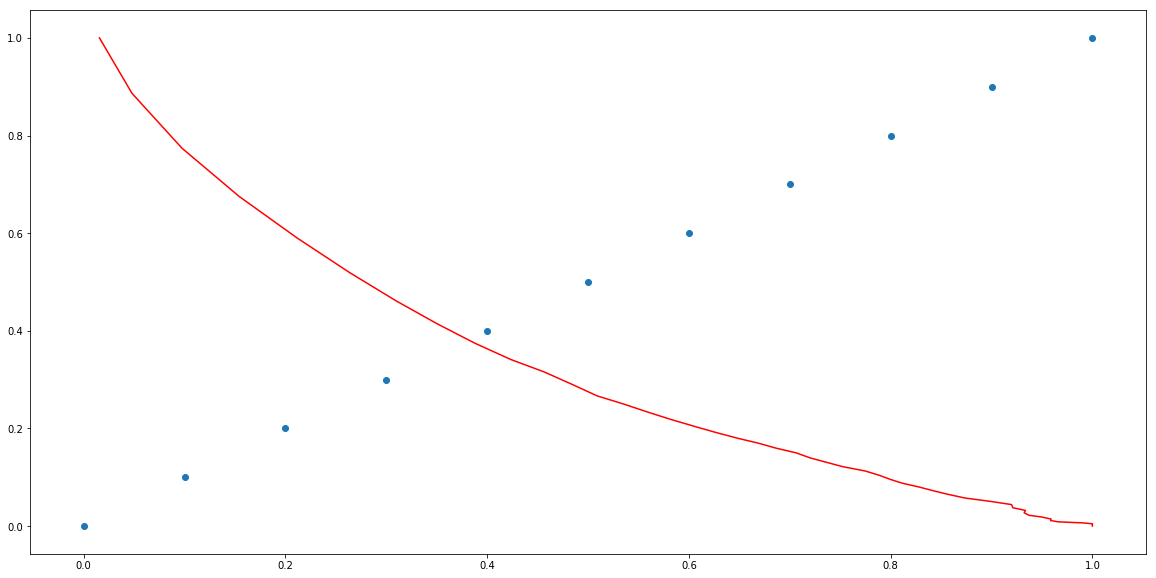

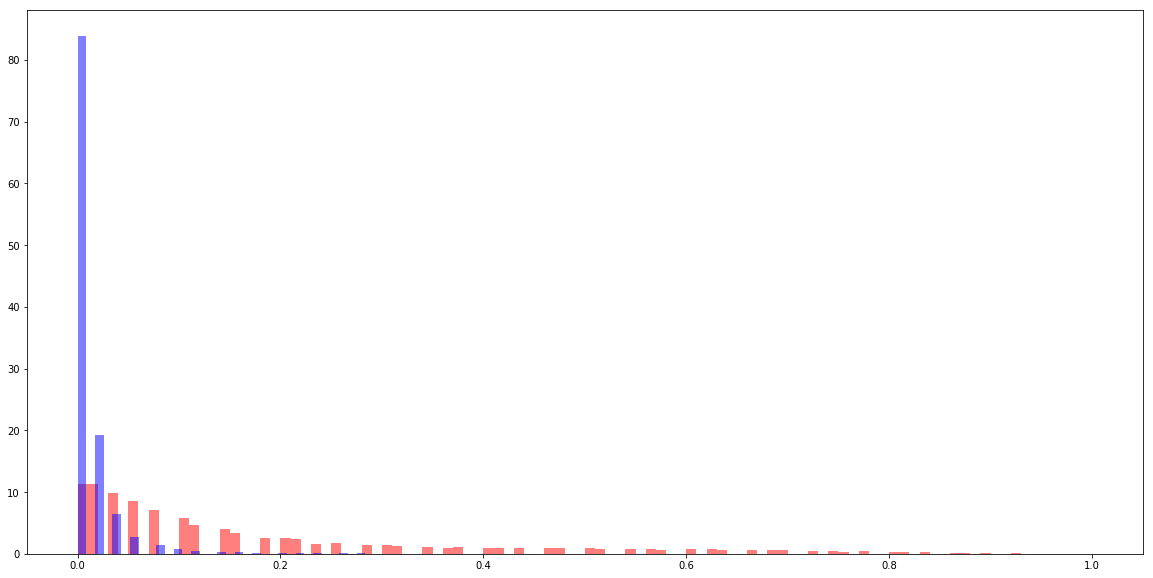

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow//stratified pdb_ids=['4y4o', '6qzp'] excluded
target.mean=0.1683381088825215


5it [00:02,  2.12it/s]


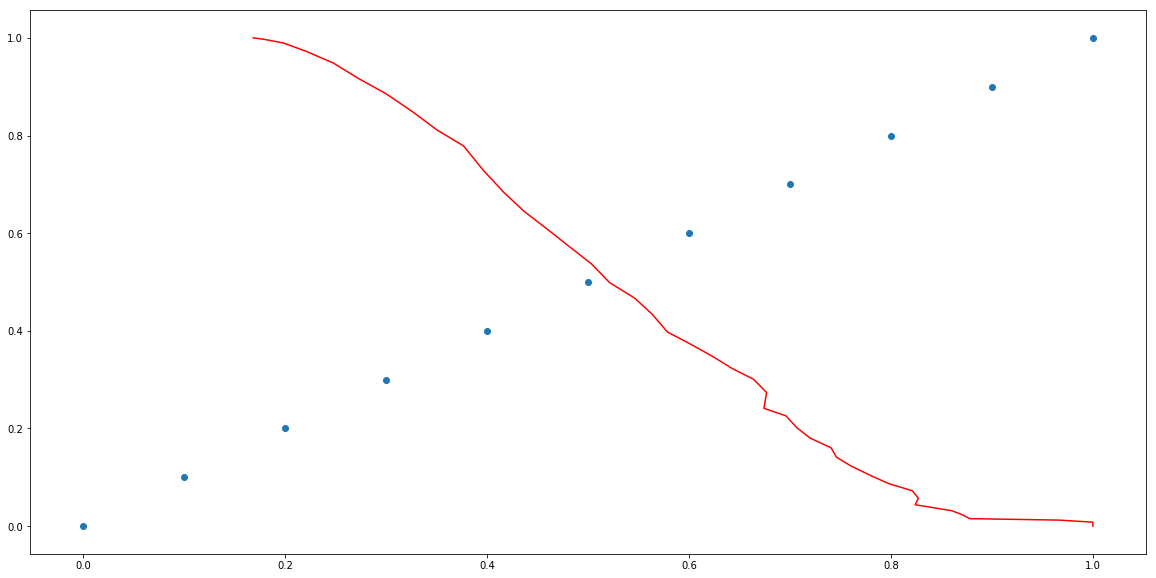

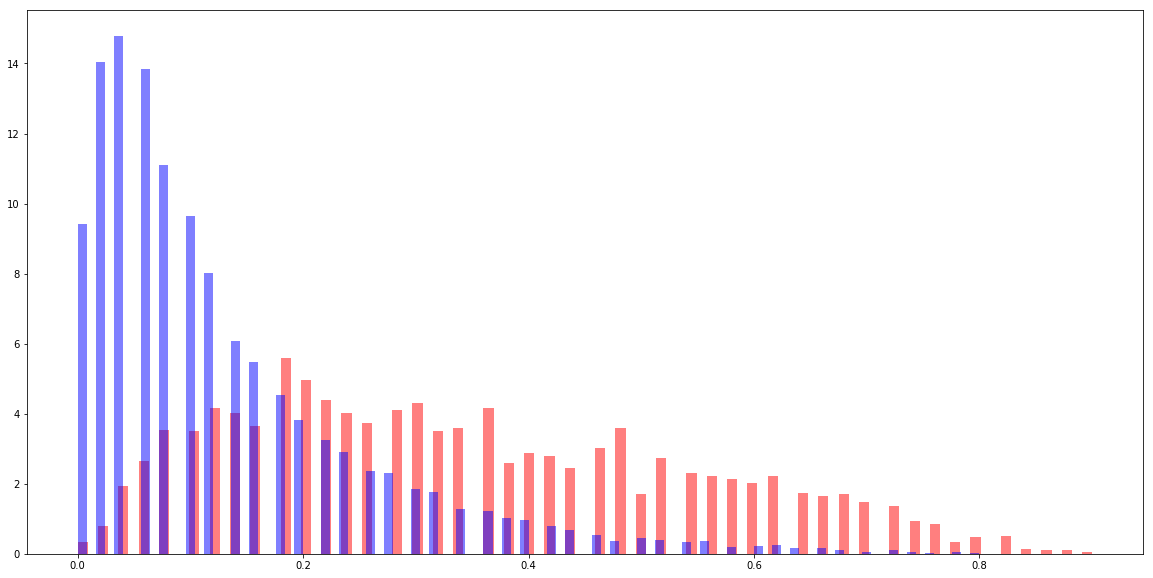

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow//cross chain short -> long
target.mean=0.015558644194568837


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


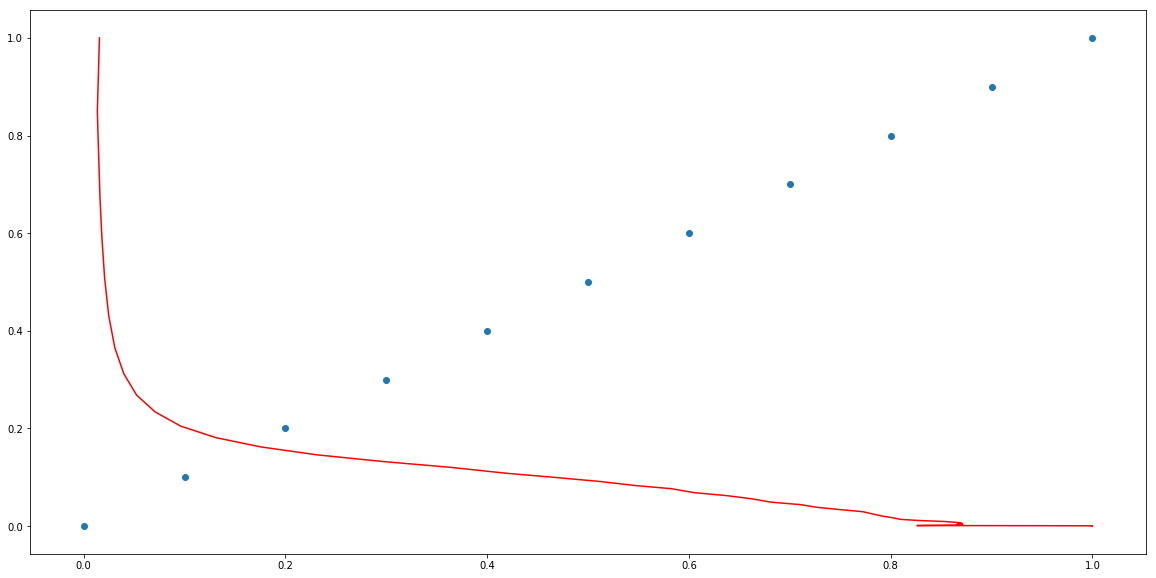

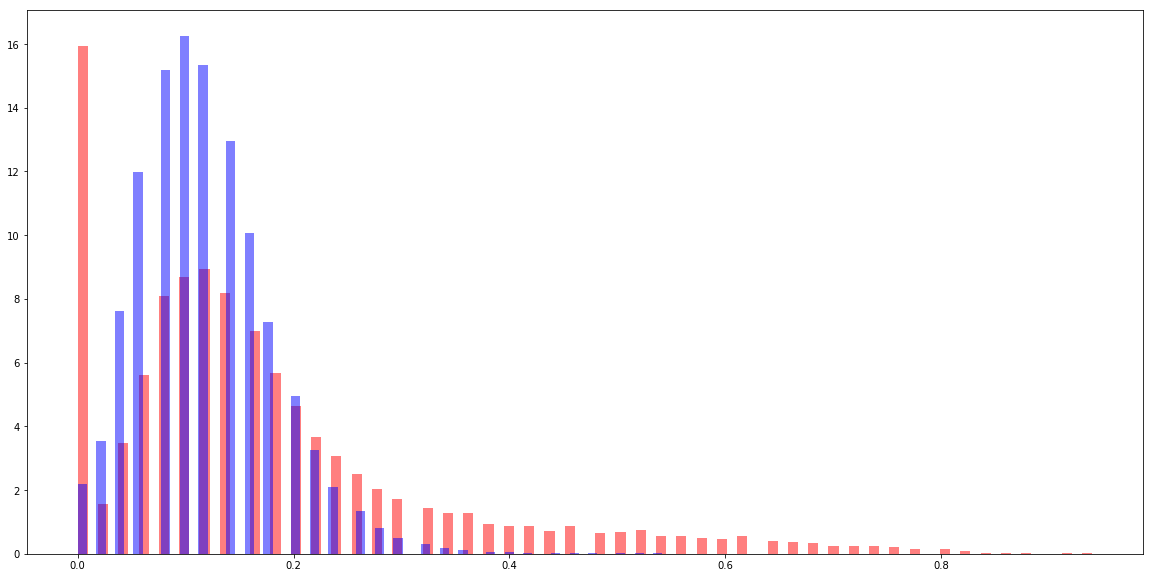

  0%|          | 0/1 [00:00<?, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow//cross chain long -> short
target.mean=0.015558644194568837


100%|██████████| 1/1 [00:36<00:00, 36.26s/it]


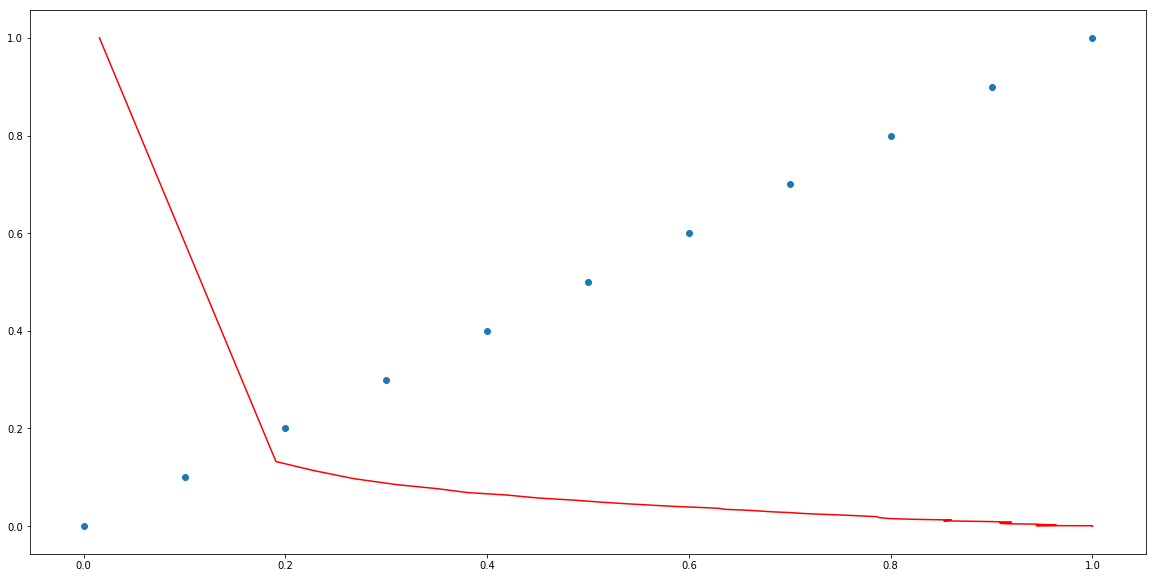

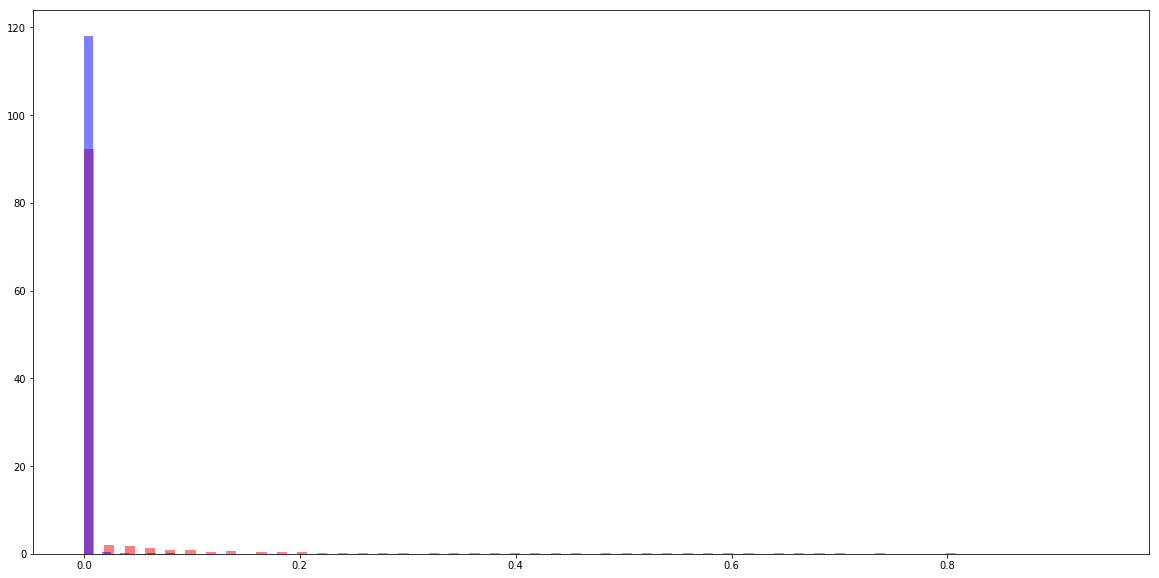

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow//chain pair experiment for chains 4y4o_1a, 6qzp_S2
target.mean=0.01991013071895425


100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


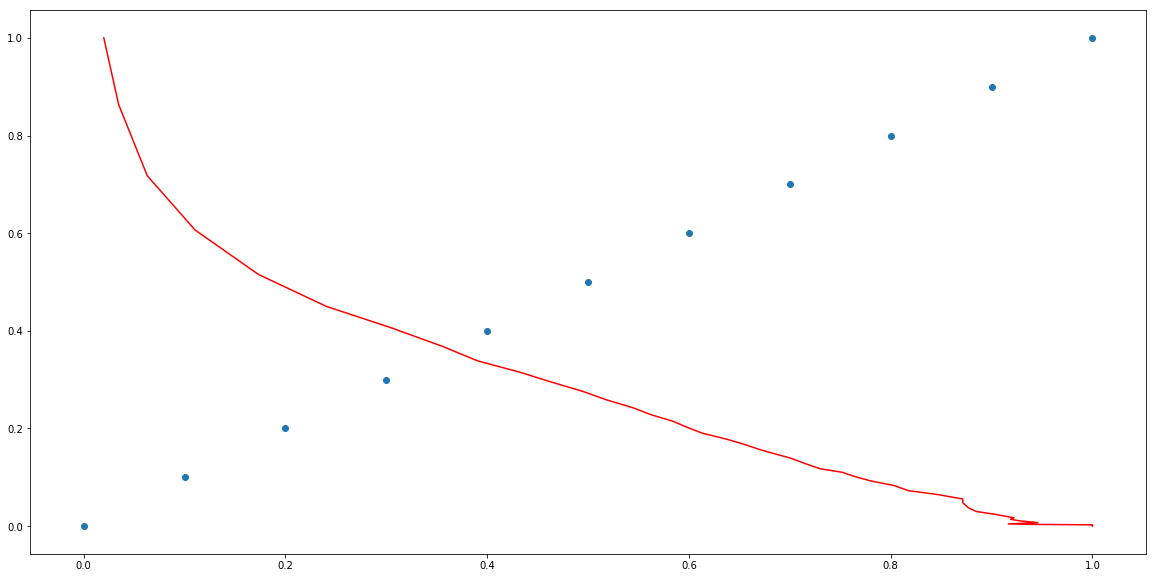

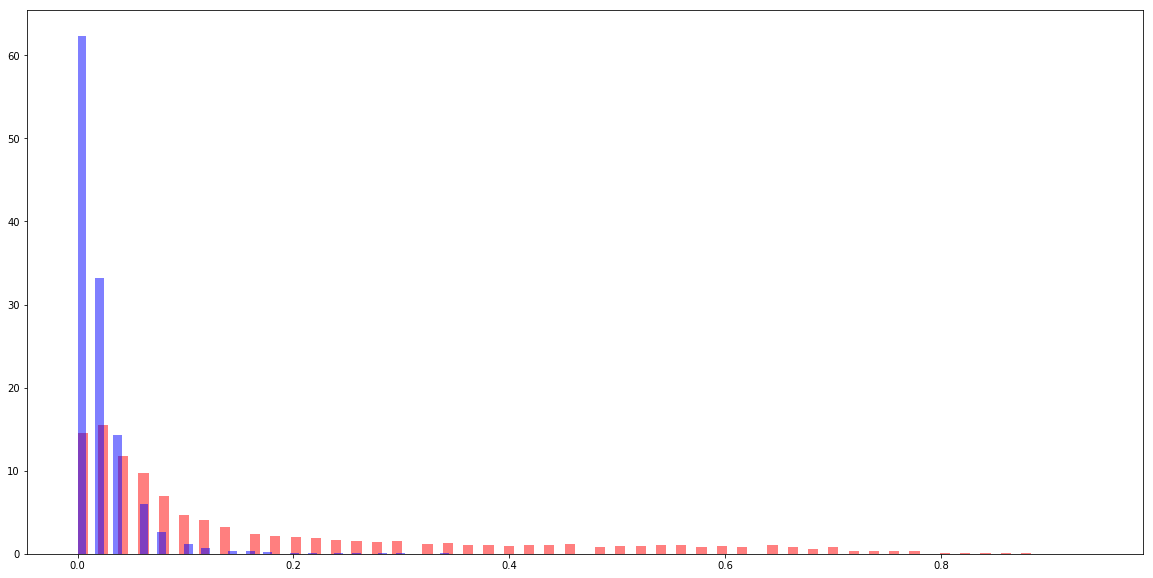

  0%|          | 0/2 [00:00<?, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow//chain pair experiment for chains 4y4o_2A, 6qzp_L5
target.mean=0.011332005906534747


100%|██████████| 2/2 [00:22<00:00, 11.41s/it]


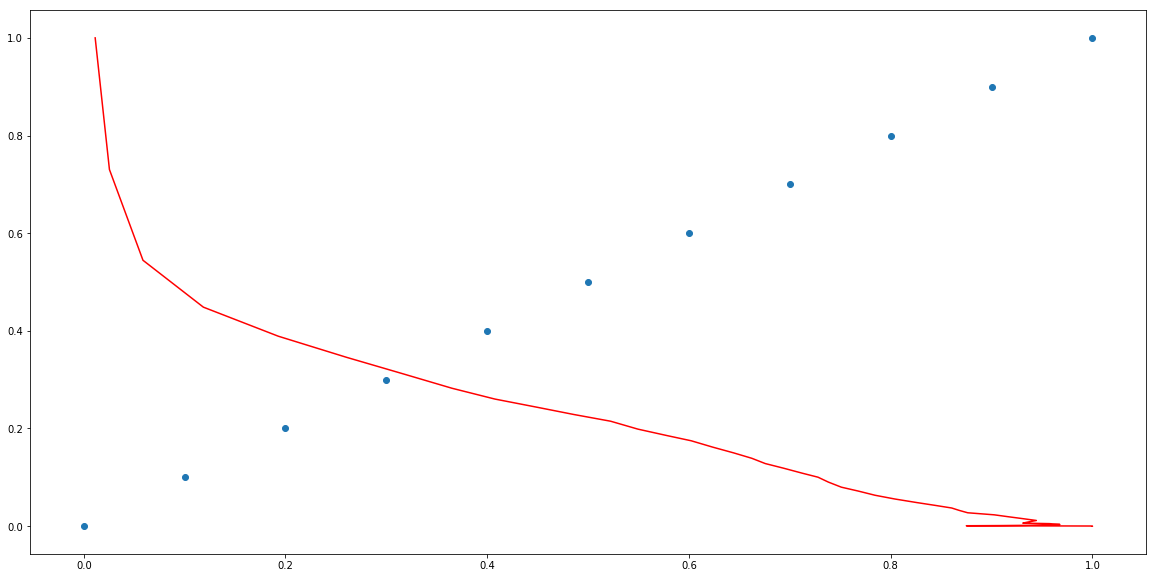

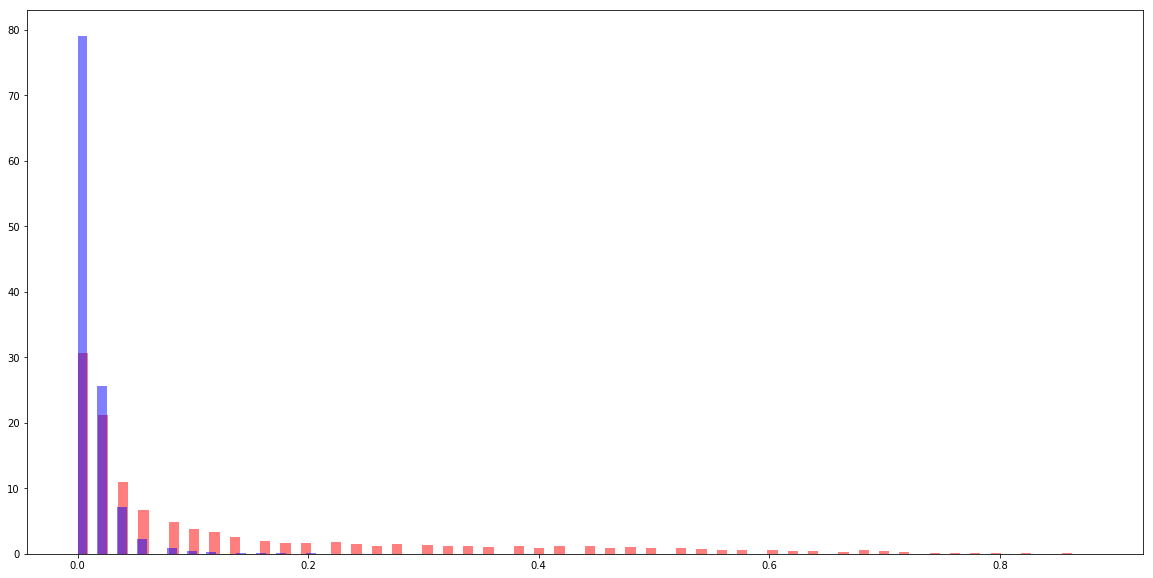

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow//chain experiment for chain 4y4o_1a
target.mean=0.022257092870154933


5it [00:09,  1.88s/it]


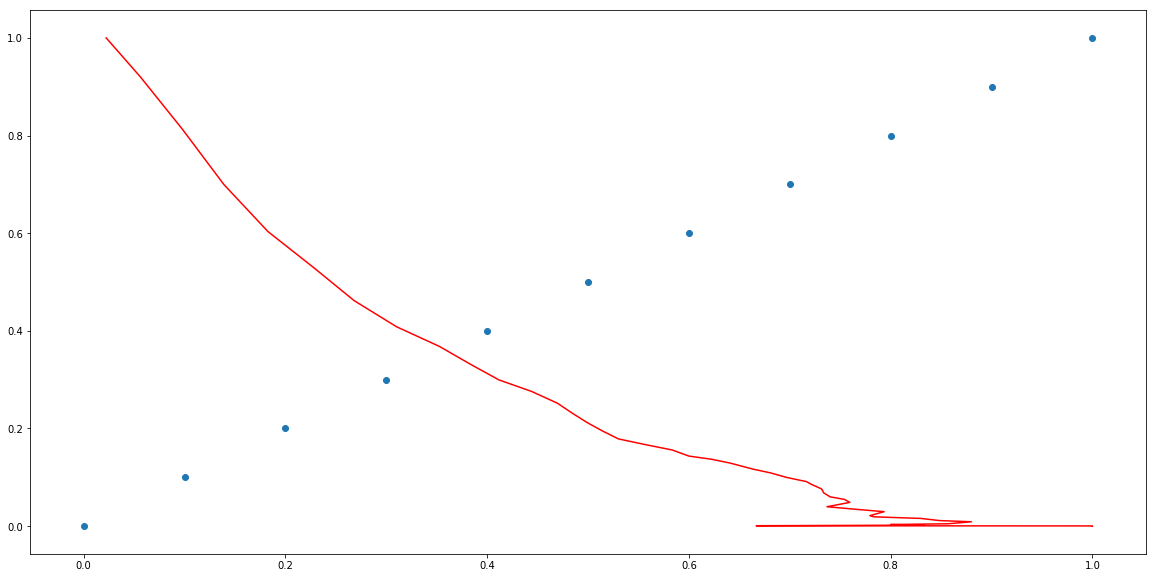

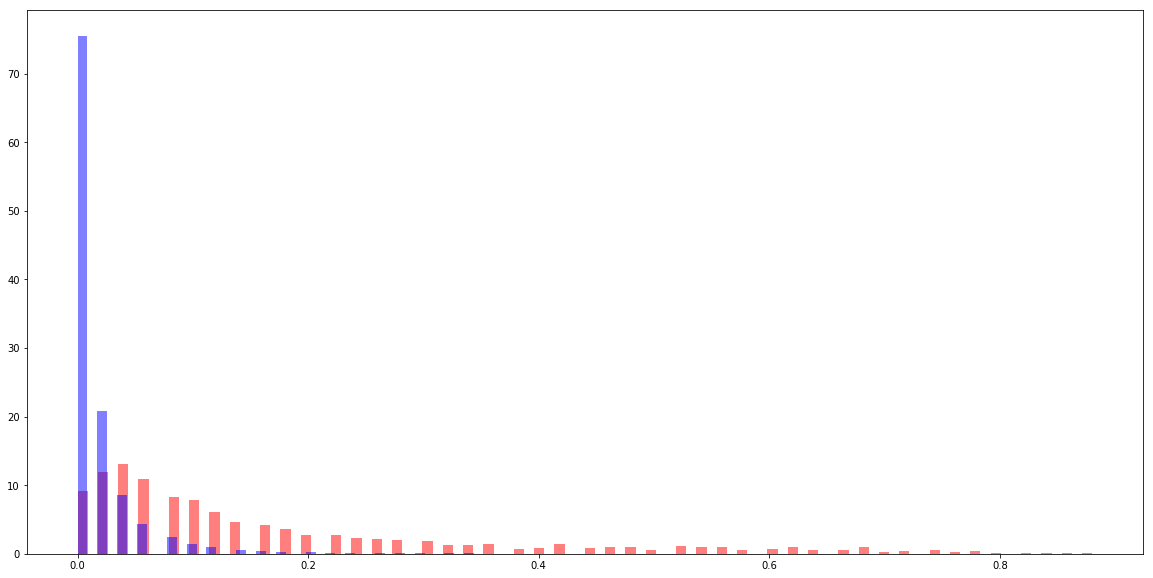

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow//chain experiment for chain 6qzp_S2
target.mean=0.017966754782920383


5it [00:12,  2.46s/it]


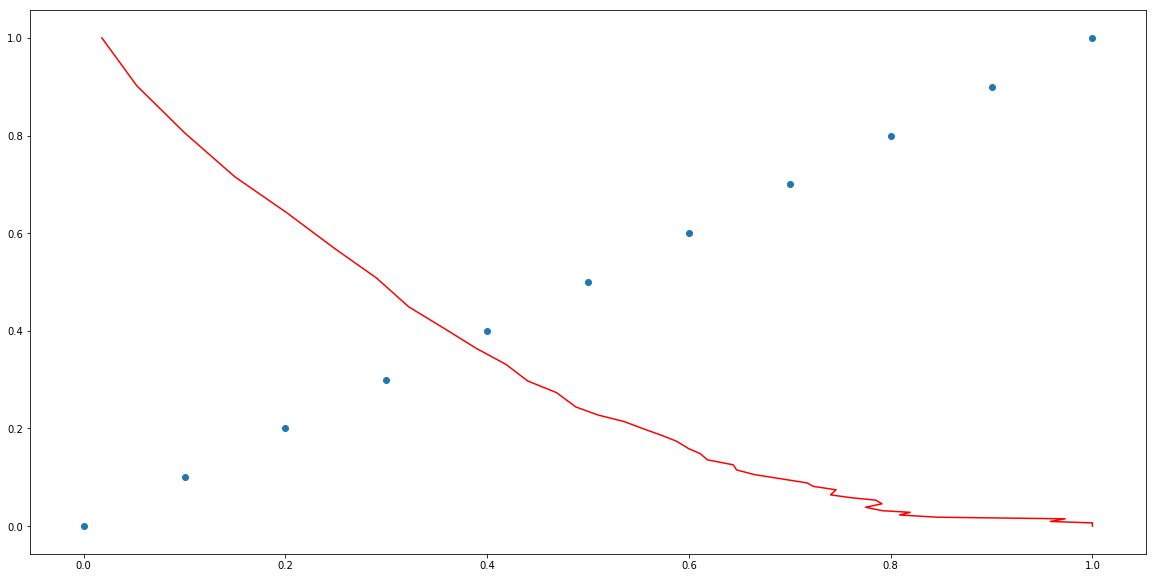

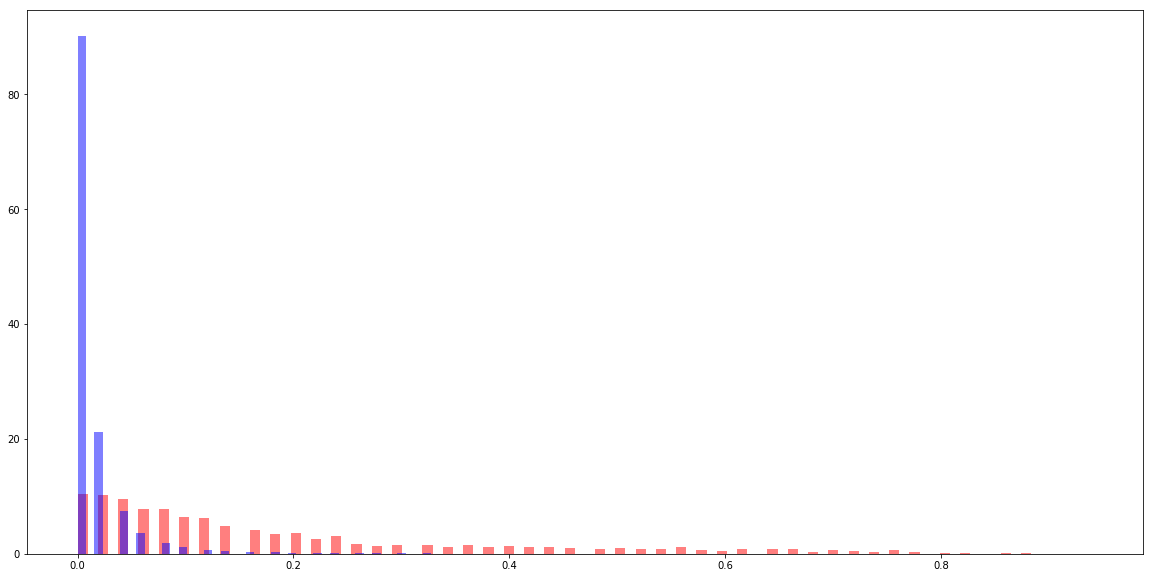

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow//chain experiment for chain 4y4o_2A
target.mean=0.01352007084541385


5it [00:35,  7.19s/it]


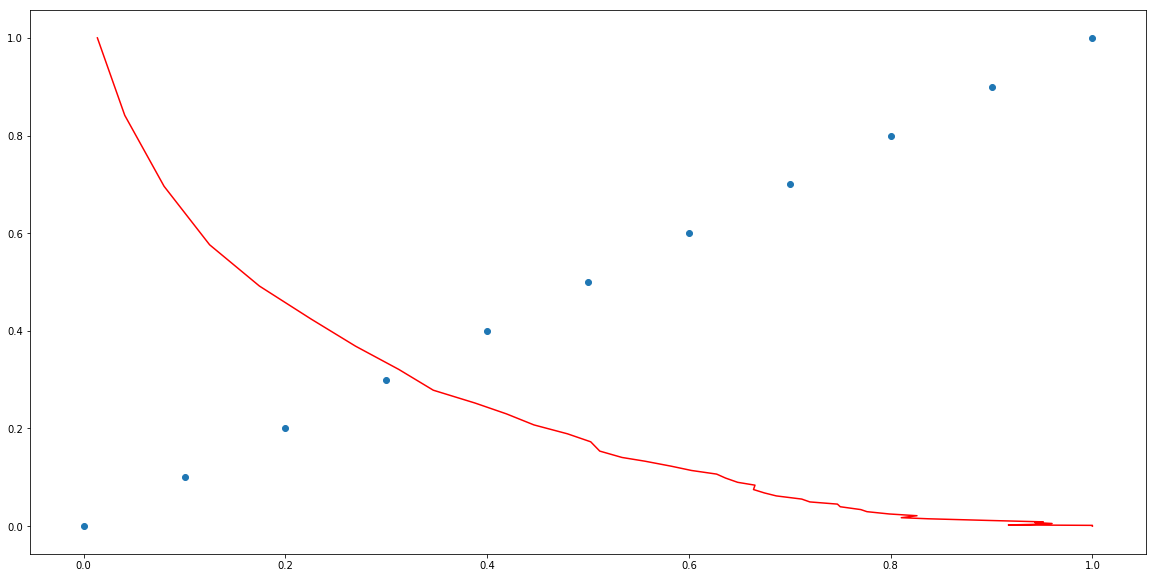

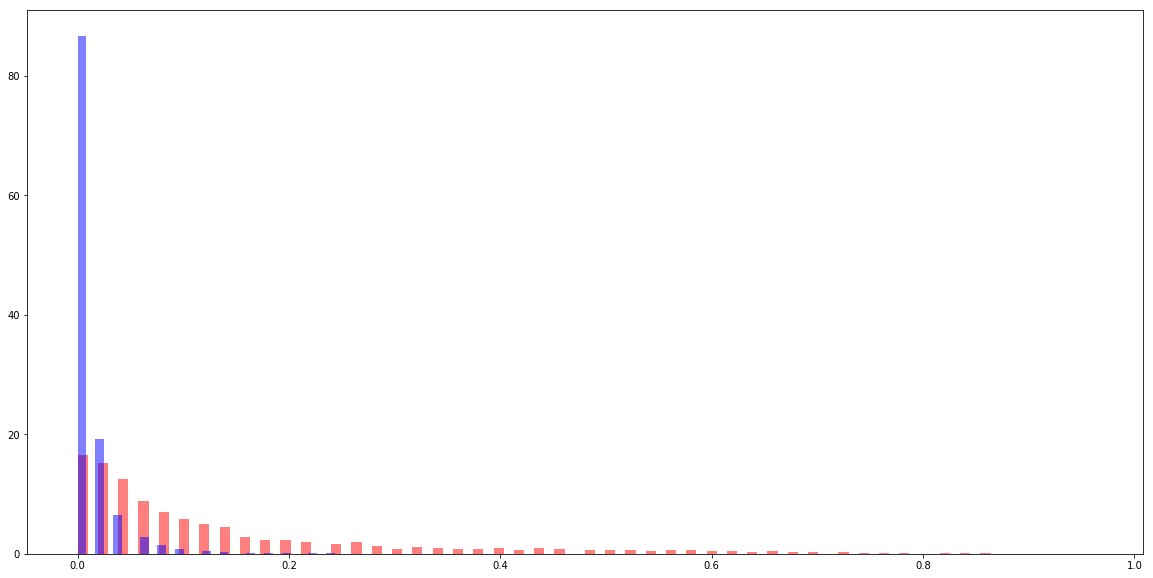

0it [00:00, ?it/s]

Experiment flt=10.fsdt=10.dt=11.nn=1.es=bow//chain experiment for chain 6qzp_L5
target.mean=0.009720534629404616


5it [00:48,  9.66s/it]


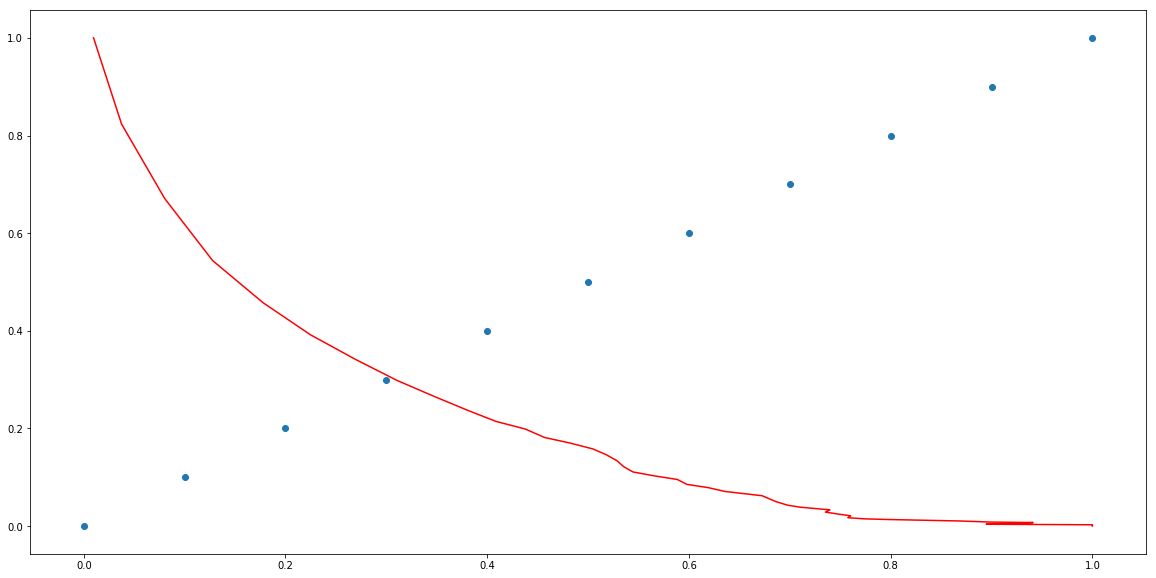

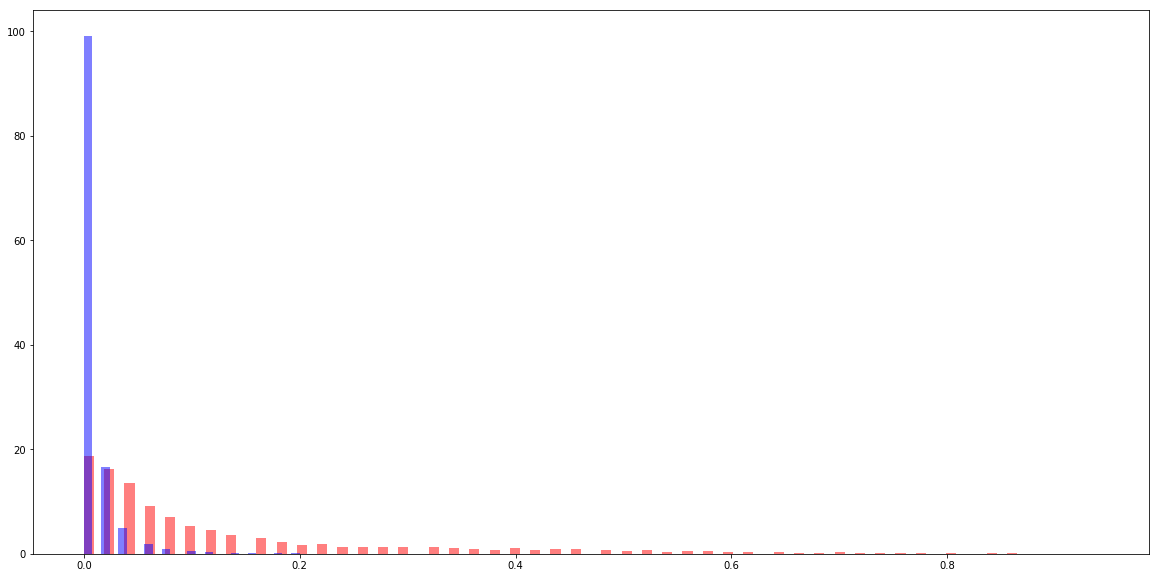

In [8]:
CHAIN_PAIRS = [('4y4o_1a', '6qzp_S2'), ('4y4o_2A', '6qzp_L5')]

experiment_results = {}
experiments = [
    SmallChainsExperiment, 
    AllDataStratifiedExperiment, 
    StratifiedSmallChainsExperiment, 
    CrossShortLongChainExperiment,
    CrossLongShortChainExperiment
]
experiments.extend([
    partial(ChainPairExperiment, chain_pair=cp) 
    for cp in CHAIN_PAIRS
])
experiments.extend([
    partial(LongChainExperiment, chain_label=cl) 
    for cl in chain.from_iterable(CHAIN_PAIRS)
])

for dataset_description, dataset in datasets.items():
    for experiment in experiments:
        experiment_instance = experiment(dataset, dataset_description)
        target, pred_proba, description, _ = experiment_instance.run()
        experiment_results[description] = (target, pred_proba)

In [9]:
def compare_pr_curves(experiment_results, graph_pair, name):
    fig, axes = plt.subplots(2, 1, figsize=(20, 20))
    
    for i, key in enumerate(graph_pair):
        ax = axes[i]
        results = experiment_results[key]
        
        ax.set_title('Results for key "{}"'.format(key), fontsize=25)
        
        xs = np.arange(0, 1.01, 0.1)
        ax.scatter(xs, xs)
        
        for target, pred_proba, description in results:
            precision, recall, thresholds = precision_recall_curve(target, pred_proba)
            ax.plot(precision, recall, label=description)
        
        ax.legend(fontsize=16)
    
    fig.savefig(f'/home/mikhail/{name}.png')

In [10]:
grouped_experiment_results = defaultdict(list)

for key, value in experiment_results.items():
    exp_id, exp_type = key.split('//')
    descr = dict([p.split('=') for p in exp_id.split(' ')[1].split('.')])
    
    grouped_experiment_results[exp_type].append((value[0], value[1], '{} {}'.format(descr['dt'], descr['es'])))

for key, value in grouped_experiment_results.items():
    grouped_experiment_results[key] = sorted(value, key=lambda a: (int(a[2].split()[0]), a[2].split()[1]))

In [12]:
graph_groups = [
    [
        "pdb_ids=['4y4o', '6qzp'] excluded",
        "stratified pdb_ids=['4y4o', '6qzp'] excluded"
    ],
    [
        'cross chain short -> long', 
        'cross chain long -> short'
    ],
    [
        'chain pair experiment for chains 4y4o_1a, 6qzp_S2',
        'chain pair experiment for chains 4y4o_2A, 6qzp_L5'
    ]
]

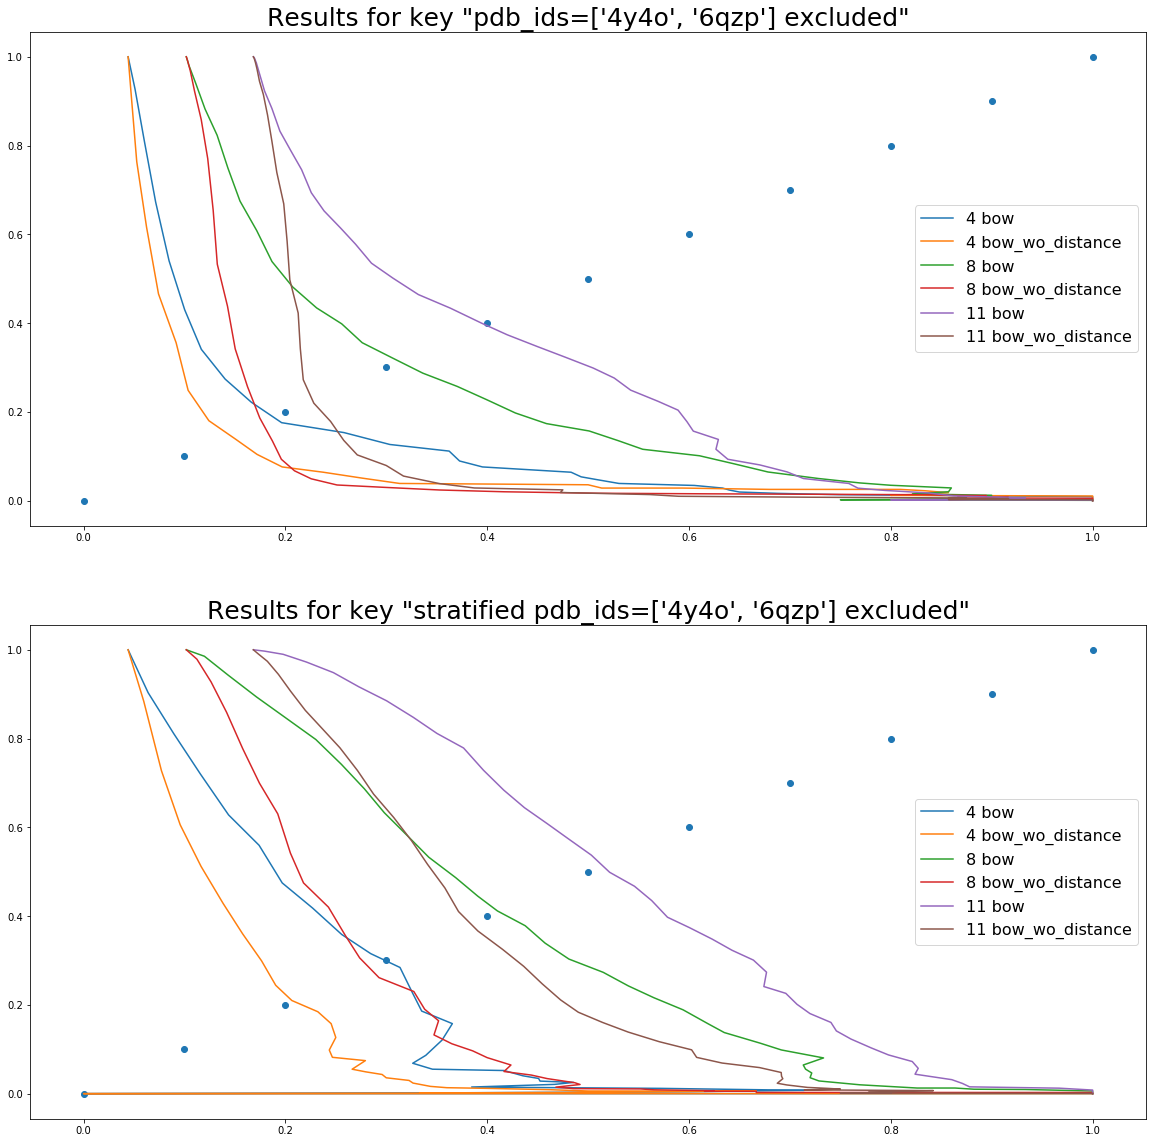

In [13]:
compare_pr_curves(grouped_experiment_results, graph_groups[0], 'short')

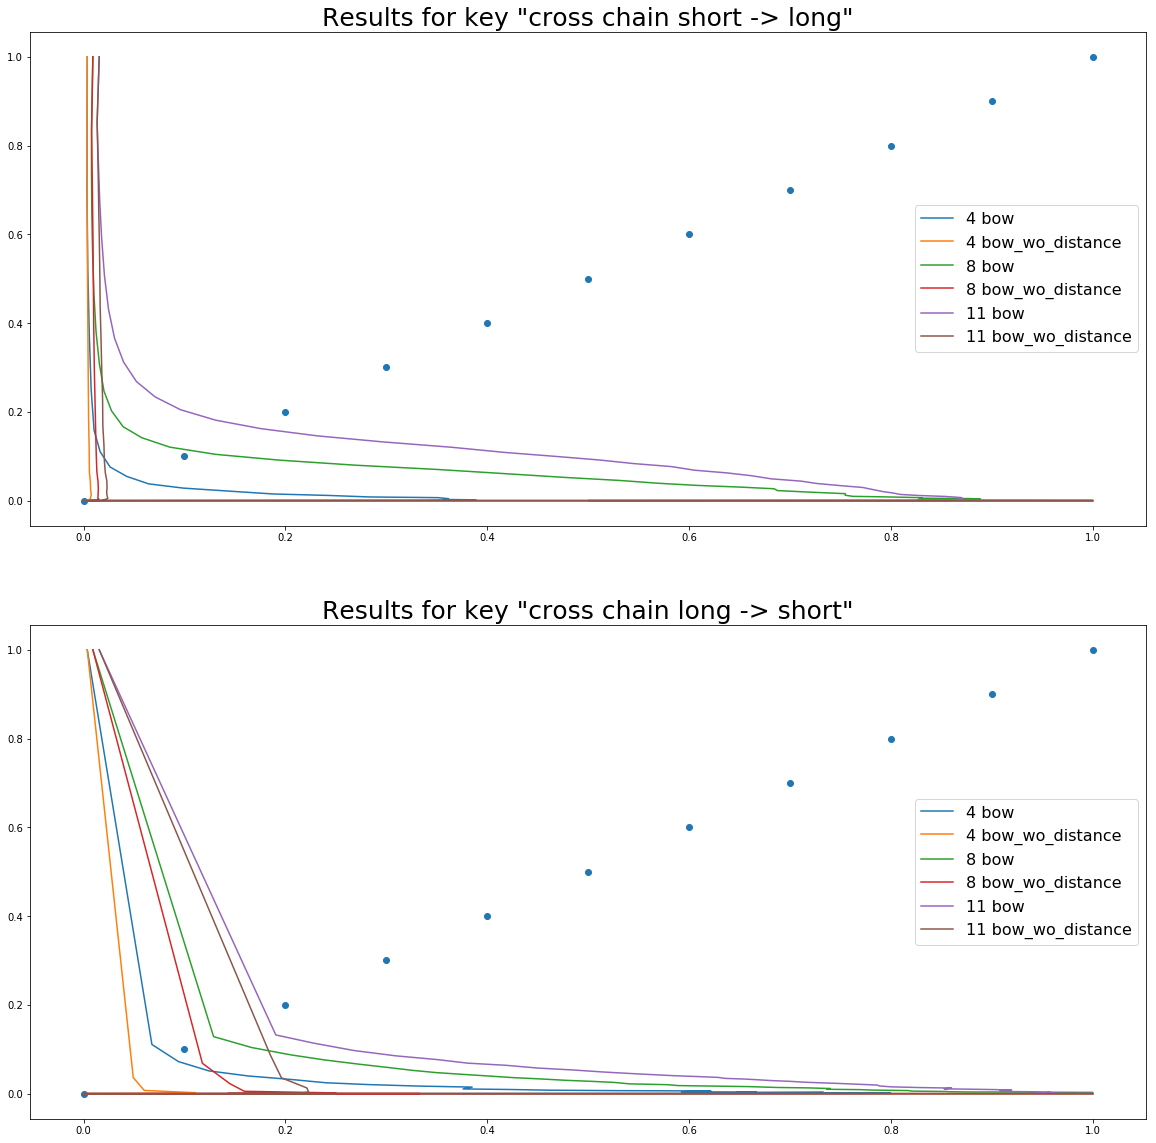

In [14]:
compare_pr_curves(grouped_experiment_results, graph_groups[1], 'cross')

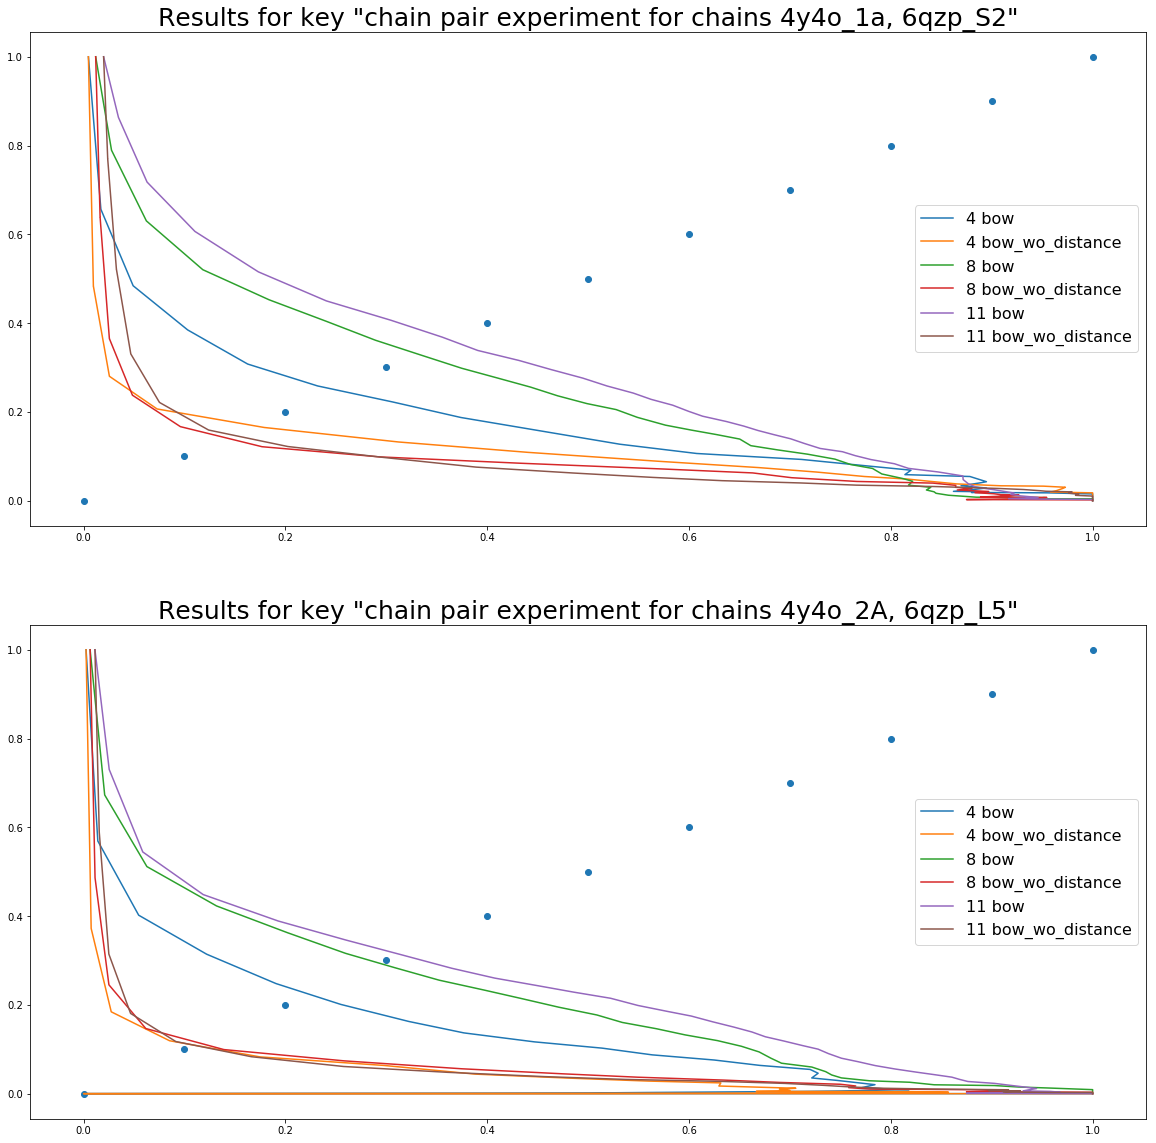

In [15]:
compare_pr_curves(grouped_experiment_results, graph_groups[2], 'long_pair')